### PROGRAM NAME: Reduced-Functioned Headset (FFH), Upstream (US) Traffic Modeling
### PROJECT:               MXR Traffic Pattern Recognition and Modeling
### DESCRIPTION

- This Python script processes and analyzes the upstream traffic captures from the Hololens2 node to to MXR rendering machine in the format of UDP messages.

### PROGRAMMER: YONGKANG LIU (FDA/CDRH/OSEL/DBP, yongkang.liu@fda.hhs.gov)
### Python-VERSION: 3.8.5 (checked by running sys.version_info)
### UPDATES

- 08/02/2023, Version 0.5, cleaned the code and add intermediate steps to include results for analysis decisions.
- 06/28/2024, Version 1.0.

## FDA software disclaimer
#### *This software and documentation (the "Software") were developed at the Food and Drug Administration (FDA) by employees of the Federal Government in the course of their official duties. Pursuant to Title 17, Section 105 of the United States Code, this work is not subject to copyright protection and is in the public domain. Permission is hereby granted, free of charge, to any person obtaining a copy of the Software, to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, or sell copies of the Software or derivatives, and to permit persons to whom the Software is furnished to do so. FDA assumes no responsibility whatsoever for use by other parties of the Software, its source code, documentation or compiled executables, and makes no guarantees, expressed or implied, about its quality, reliability, or any other characteristic. Further, use of this code in no way implies endorsement by the FDA or confers any advantage in regulatory decisions. Although this software can be redistributed and/or modified freely, we ask that any derivative works bear some notice that they are derived from it, and any modified versions bear some notice that they have been modified.*

### Step 0. Load system libraries and pre-defined functions

In [1]:
import sys
print(sys.version_info)

import pandas as pd
import fnmatch
import os
import csv

import matplotlib.pyplot as plt
import numpy as np

# Plot function with x boundary limits
def scatterplot(x_data, y_data, x_xlim=[0, 0], y_ylim=[0, 0], x_label="", y_label="", \
                title="", color = "r", yscale_log=False, figSave=False, fig_index=""):

    plt.figure()
    # Create the plot object
    _, ax = plt.subplots()

    # Plot the data, set the size (s), color and transparency (alpha)
    # of the points
    ax.scatter(x_data, y_data, s = 5, color = color, alpha = 0.75, marker='.')

    if yscale_log == True:
        ax.set_yscale('log')

    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if x_xlim[0]<x_xlim[1]:        
        ax.set_xlim(x_xlim[0], x_xlim[1])
        
    if y_ylim[0]<y_ylim[1]:        
        ax.set_ylim(y_ylim[0], y_ylim[1])
        
#     ax.set_xticks(np.arange(x_xlim[0], x_xlim[1], round((x_xlim[1]-x_xlim[0])/10)+1))
#     arr_time = np.arange(0, 700, step = 20)
#     ax.set_xticks(arr_time)
    
    
#     ax.set_xticks(np.arange(0, 690, step=30))
    
    if figSave:
        plt.rcParams["figure.figsize"] = [12.00, 8.0]
        plt.rcParams["figure.autolayout"] = True
        #plt.savefig('test_'+fig_index+'.png', bbox_inches='tight')
        plt.savefig('test_'+fig_index+'.svg', format='svg', dpi=1200)

sys.version_info(major=3, minor=11, micro=7, releaselevel='final', serial=0)


### Step 1. Load Traffic Capture data from CSV file(s)

In [2]:
listFile = []

file_path = 'ul_filtered.csv'

pcap_start_time = 0

# If the csv file is found and the file full path is saved in a variable, filePath
with open(file_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    real_row_count = 0
    stream_dir_list = []
    ana_mat = []
    for row in csv_reader:
        if line_count == 0: # the first row
            cols = {k: v for v, k in enumerate(row)} # save column names into a dict {key:value}={columnName:index}
#             cols["stream_id"]=len(cols) # add a new column storing IP stream ID (direction)
#             cols["ip.len.eqv"]=cols["stream_id"]+1 # add one more new column storing the equivalent IP length, which is\
            # a theoretical value showing the IP packet length needed to contain a single Application Layer PDU
            print(cols)
        else:
            if line_count == 1: #Get the start time of the PCAP data
                pcap_start_time = float(row[cols["frame.time_epoch"]])
                print(pcap_start_time)
                
            # we can access row's element by calling the column name, e.g., row[cols['column1_name']]
            # If the capture is an IP packet and is not in the banned IP range
            if row[cols["ip.proto"]]!="" \
                and row[cols["ip.dst"]]!="255.255.255.255" \
                and row[cols["ip.dst"]]!="239.255.255.250" \
                and row[cols["ip.dst"]]!="224.0.0.251": 
                #print(row)
                #print(type(row))
#                 stream_dir = row[cols["ip.src"]] + "-->" + row[cols["ip.dst"]]
#                 if stream_dir not in stream_dir_list:
#                     stream_dir_list.append(stream_dir)
                
                row_tmp = row.copy()
                row_tmp[cols["frame.time_epoch"]] = float(row_tmp[cols["frame.time_epoch"]])-pcap_start_time
#                 row_tmp.append(stream_dir_list.index(stream_dir)) #corresponding to cols["stream_id"]
                
#                 row_tmp.append(0) # corresponding to cols["ip.len.eqv"]
                ana_mat.append(row_tmp) 
                real_row_count += 1
                
                
            #if real_row_count > 20:
                #break
            
        line_count += 1

pcap_end_time = ana_mat[-1][cols["frame.time_epoch"]]

print('total pcap pkts: ', len(ana_mat))

print('PCAP starts at ', pcap_start_time)
print('PCAP period length (sec): ', pcap_end_time)

{'frame.number': 0, 'frame.time_epoch': 1, 'eth.type': 2, 'ip.proto': 3, 'ip.len': 4, 'ip.src': 5, 'ip.dst': 6, 'tcp.flags': 7, 'tcp.segment': 8, 'tcp.analysis.acks_frame': 9, 'udp.stream': 10, 'udp.srcport': 11, 'udp.dstport': 12, 'udp.length': 13, 'ssl.record.version': 14, 'ssl.record.length': 15, 'ssl.record.opaque_type': 16, 'data.len': 17, 'data.data': 18}
1662578431.802563
total pcap pkts:  62437
PCAP starts at  1662578431.802563
PCAP period length (sec):  683.2568249702454


In [3]:
ana_mat[1001][cols["data.data"]][:38] #check loaded data

'80:00:01:20:00:00:00:00:e0:6a:04:01:04'

### Step 2. Data Exploration

#### Overview of the UL traffic associated with XR content rendered remotely

There are multiple message types that can be distinguished by the first 4 hex digitals at the beginning of application messages.

We keep three most frequent ones that also occupy the majority of the total traffic load. 




In [4]:
# define new columns at the right end
  
if "data.type" not in cols: # store the major message type, i.e., [0:5] with the first 4 digits at the message beginning
    cols["data.type"] = len(cols)
    
if "data.type.second" not in cols: # store the secondary message type, i.e., [6:11] with the next 4 digits following the major type 
    cols["data.type.second"] = len(cols)
    
if "data.type.sub" not in cols: # store the secondary message type, i.e., [30:35] with 4 digits, used by "80:00"
    cols["data.type.sub"] = len(cols) 
    
if "data.seg.idx" not in cols: # store the burst/segment index for "80:00" messages
    cols["data.seg.idx"] = len(cols)
    
if "data.seg.tap.idx" not in cols: # store the index for "80:00" messages within a burst/seg
    cols["data.seg.tap.idx"] = len(cols)
    
if "data.type.name" not in cols: # store the index for "80:00" messages within a burst/seg
    cols["data.type.name"] = len(cols)
    
for i in ana_mat:
    row_data_prefix = i[cols["data.data"]][:38]  # truncate the original data sequence (keep only first four pairs)
    i[cols["data.data"]] = row_data_prefix
    
    i.append(row_data_prefix[:5]) # "data.type"
    i.append(row_data_prefix[6:11]) # "data.type.second"
    i.append(row_data_prefix[30:35]) # "data.type.sub"
    i.append(-1) # initial value for "data.seg.idx", -1 means NA
    i.append(-1) # initial value for "data.seg.tap.idx", -1 means NA
    i.append("NA") # initial value for "data.type.name"
    

# check all unique "data.type" and find the population
msg_type_dict = {}
type_id = 0
type_ins_count = [0 for i in range(10)]
for i in ana_mat:
    row_data_prefix = i[cols["data.type"]]
    if row_data_prefix not in msg_type_dict:
        msg_type_dict[row_data_prefix] = type_id
        type_id += 1
    type_ins_count[msg_type_dict[row_data_prefix]] += 1
    
# for i in msg_type_dict:
#     print("{}, {}".format(i, type_ins_count[msg_type_dict[i]]))    

    
# check all unique "data.type" and find the population
msg_type_dict = {}
type_id = 0
type_ins_count = [0 for i in range(10)]
type_ins_byte_sum = [0 for i in range(10)]
for i in ana_mat:
    row_data_prefix = i[cols["data.type"]]
    row_data_len = i[cols["data.len"]]
    if row_data_prefix not in msg_type_dict:
        msg_type_dict[row_data_prefix] = type_id
        type_id += 1
    type_ins_count[msg_type_dict[row_data_prefix]] += 1
    type_ins_byte_sum[msg_type_dict[row_data_prefix]] += int(row_data_len)
    
sum_pkt_total = sum(type_ins_count)
sum_byte_total = sum(type_ins_byte_sum)   
for i in msg_type_dict:
    print("{}, {}, ratio:{}, sum_byte:{}, sum_byte_ratio:{}".format(i, type_ins_count[msg_type_dict[i]], type_ins_count[msg_type_dict[i]]/sum_pkt_total, \
                                                                    type_ins_byte_sum[msg_type_dict[i]], type_ins_byte_sum[msg_type_dict[i]]/sum_byte_total))   

80:66, 8, ratio:0.0001281291541874209, sum_byte:9436, sum_byte_ratio:0.0005149701821022103
80:65, 673, ratio:0.010778865096016785, sum_byte:921972, sum_byte_ratio:0.05031666900520761
80:64, 2, ratio:3.203228854685523e-05, sum_byte:43, sum_byte_ratio:2.3467271969473334e-06
80:61, 29, ratio:0.00046446818392940084, sum_byte:1241, sum_byte_ratio:6.772763840492189e-05
80:68, 123, ratio:0.0019699857456315964, sum_byte:125190, sum_byte_ratio:0.006832250646182249
80:23, 6892, ratio:0.11038326633246312, sum_byte:172198, sum_byte_ratio:0.00939771464790551
80:00, 54709, ratio:0.8762272370549514, sum_byte:17093307, sum_byte_ratio:0.9328681028527962
6a:e0, 1, ratio:1.6016144273427613e-05, sum_byte:4, sum_byte_ratio:2.1830020436719383e-07


The frames with the prefix __"80:00"__ and __"80:65"__ dominate the traffic load so that we focus on characterizing their patterns in the model.

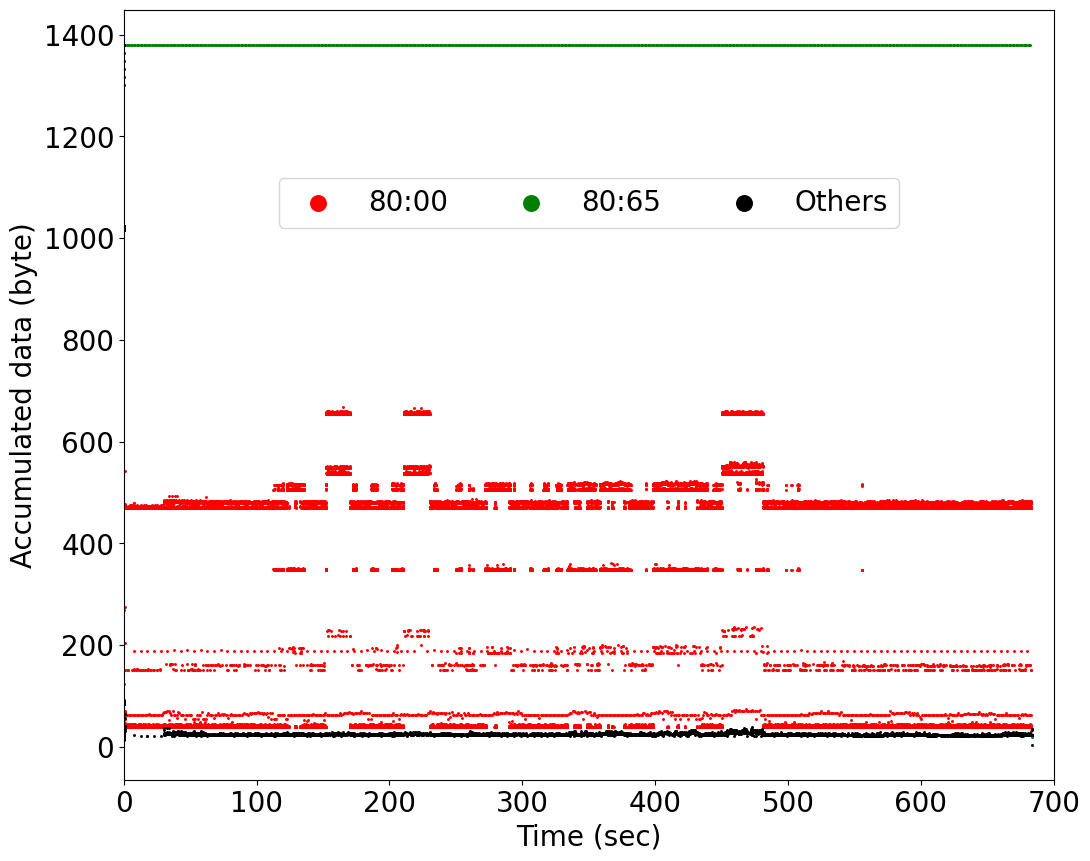

In [5]:
# list 0: 80:00; list 1: 80:65; list 2: other

list_lst_time_plot = [[],[],[]]
list_lst_pkt_plot = [[],[],[]]

for i in ana_mat:
    if i[cols["data.type"]] in ["80:00"]:
        lst_ind = 0
    elif i[cols["data.type"]] in ["80:65"]:
        lst_ind = 1
    else:
        lst_ind = 2
        
    list_lst_time_plot[lst_ind].append(i[cols["frame.time_epoch"]])
    list_lst_pkt_plot[lst_ind].append(int(i[cols["data.len"]]))
    

colors = ['r', 'g', 'k']

labels = ['80:00', '80:65', "Others"]
    
markers = ['.', 'o', 'x']
    
_, ax = plt.subplots(figsize=(12, 10))

for i in range(3):
    # Create the plot object
    

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
    ax.scatter(list_lst_time_plot[i], list_lst_pkt_plot[i], s = 5, 
               color = colors[i], label = labels[i], alpha = 1, marker='.')


# # Label the axes and provide a title
# ax.set_title(title)
ax.set_xlabel("Time (sec)", fontsize = 20)
ax.set_ylabel("Accumulated data (byte)", fontsize = 20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# if x_xlim[0]<x_xlim[1]:
ax.set_xlim(0, 700)
ax.legend(fontsize = 20, bbox_to_anchor=(0.5, 0.8), loc='upper center', ncol=3, markerscale=10)

# # # Label the axes and provide a title
# # ax.set_title(title)
# ax.set_xlabel("Time (sec)")
# ax.set_ylabel("Accumulated data (byte)")
# # if x_xlim[0]<x_xlim[1]:
# ax.set_xlim(0, 700)
# ax.legend()
    

Figure saved as  Application Data Rate (all inclusive)


<Figure size 640x480 with 0 Axes>

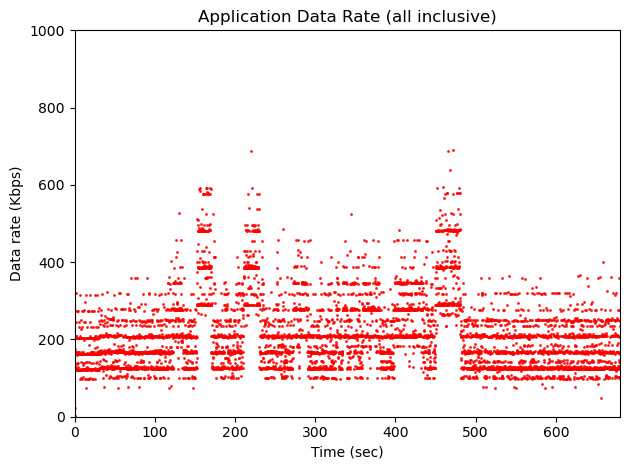

In [7]:
# Overview of the throughput

# Throughput of the captured data stream

import math

step = .1 #sec

start_time = 0
end_time = math.ceil(ana_mat[-1][cols["frame.time_epoch"]]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat:
    len_tmp = int(i[cols["data.len"]])
    time_tmp = i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

lst_rate_mbps = [i/1000 for i in lst_rate_kbps]
    


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]
pic_title = "Application Data Rate (all inclusive)"
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 680#pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
            y_ylim=[0, 1000], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

(0.0, 0.8)

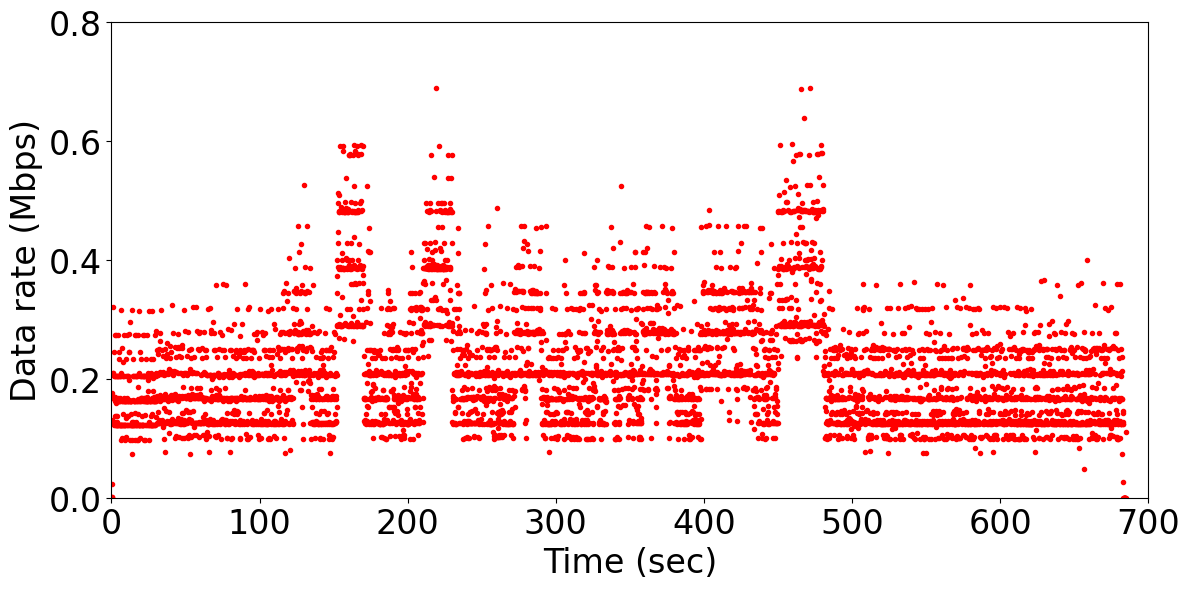

In [8]:
# Overview of the throughput

# Throughput of the captured data stream

import math

step = .1 #sec

start_time = 0
end_time = math.ceil(ana_mat[-1][cols["frame.time_epoch"]]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat:
    len_tmp = int(i[cols["data.len"]])
    time_tmp = i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

lst_rate_mbps = [i/1000 for i in lst_rate_kbps]

_, ax = plt.subplots(figsize=(12, 6))


ax.scatter(arr_time, lst_rate_mbps, s = 35, color = 'r', 
               alpha = 1, marker='.')




# ax.set_title(title)
ax.set_xlabel("Time (sec)", fontsize = 24)
ax.set_ylabel("Data rate (Mbps)", fontsize = 24)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
ax.set_xlim(0, 700)
# if x_xlim[0]<x_xlim[1]:
ax.set_ylim(0, .8)
# ax.legend(fontsize = 20, bbox_to_anchor=(0.5, 0.1), loc='lower center', ncol=3, markerscale=10,)

    


# # print("After:", lst_rate_kbps[300:350])

# # pic_title = "Link: "+stream_dir_list[stream_id]
# pic_title = "Application Data Rate (all inclusive)"
# print('Figure saved as ', pic_title)
# x_min_display = 0
# x_max_display = 680#pcap_end_time
# scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 1000], \
#             x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

The three major frame types are the frames with prefix of __["80:65", "80:23", "80:00"]__, which are similar to the downstream case. Hereafter, we will have them being examined individually.

#### Type-specific analysis


First, we want to identify the one(s) with stable distributions that don't vary very much across different operation states.

#### Case 1. 80:65

This type of messages was spotted from the start to the end during the measurement. It serves in the whole session.

673
673
Figure saved as  Packet TransmissionsData Type_80:65


<Figure size 1200x800 with 0 Axes>

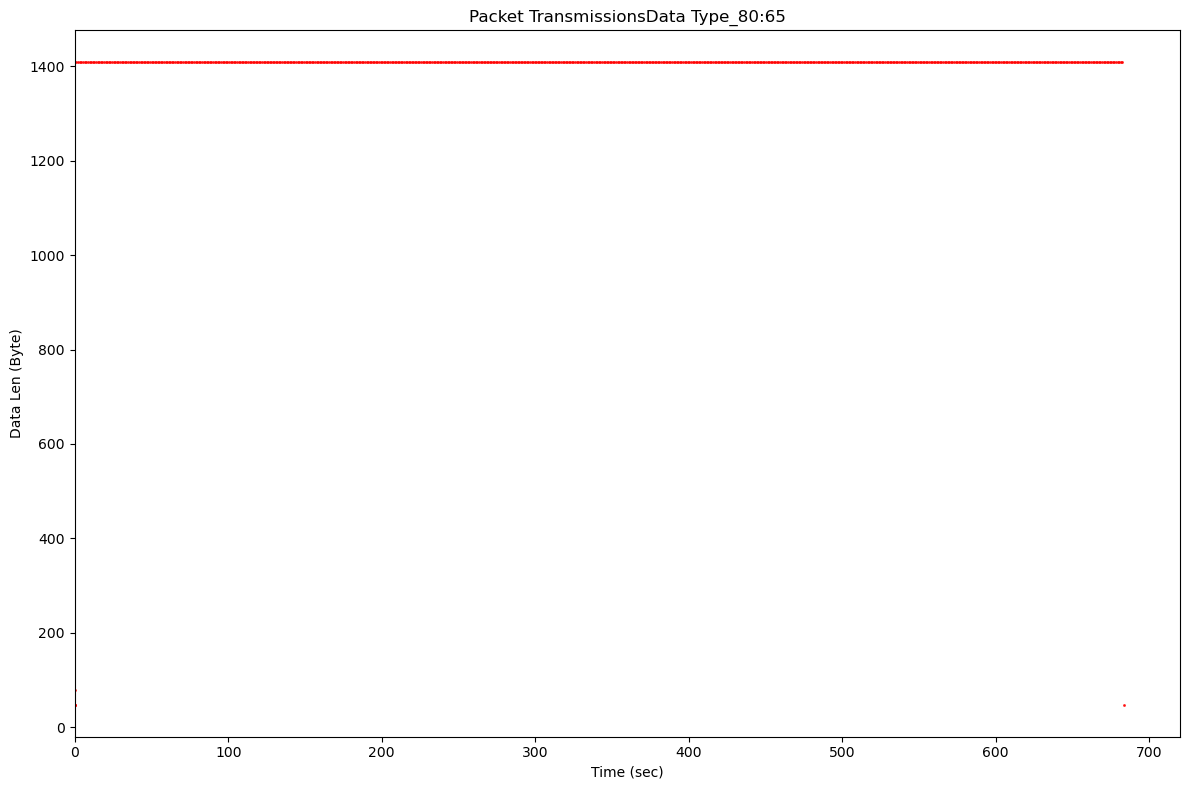

In [9]:
ana_mat_lean = []

lst_display_data_type = ["80:65"]

for i in ana_mat:
    if i[cols["data.type"]] in ["80:65"]:
#     if i[cols["data.type"]] in ["80:65", "80:66", "80:64", "80:61", "80:68"]:
#     if i[cols["data.type"]] in ["80:65", "80:23", "80:00"]:
#     if i[cols["data.type"]] in ["80:23"] and i[cols["data.data"]][6:11] == "00:00":
        ana_mat_lean.append(i.copy())
        
len(ana_mat_lean)

timeline = []
len_list = []

for i in ana_mat_lean:
    #print(i[:])
#     if i[cols['stream_id']]==stream_id:
    timeline.append(i[cols['frame.time_epoch']])
    len_list.append(int(i[cols['ip.len']]))
        
print(len(timeline))
# print(stream_dir_list[stream_id])
print(len(timeline))

# pic_title = "Link: "+stream_dir_list[stream_id]
str_displayed_data_type =""
for i in lst_display_data_type:
    str_displayed_data_type += "_"
    str_displayed_data_type += i
    

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 720#pcap_end_time
scatterplot(timeline, len_list, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Data Len (Byte)", title=pic_title, figSave=True, fig_index="")

[0.896, 11.04, 11.04, 11.04, 11.04, 11.04, 11.04, 11.04, 11.04, 11.04]
Figure saved as  Packet TransmissionsData Type_80:65


<Figure size 1200x800 with 0 Axes>

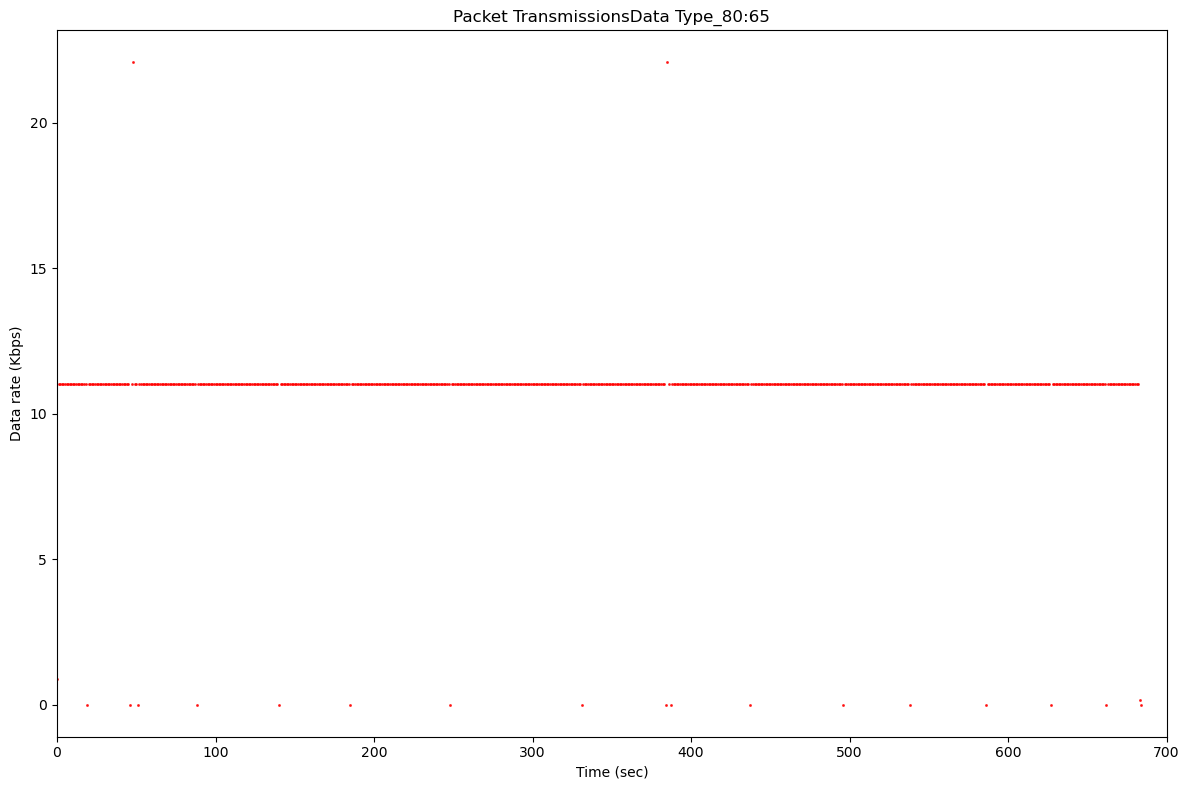

In [10]:
# Throughput of the selected data stream

import math

step = 1 #sec

start_time = 0
end_time = math.ceil(ana_mat_lean[-1][cols["frame.time_epoch"]]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat_lean:
    len_tmp = int(i[cols["data.len"]])
    time_tmp = i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

print(lst_rate_kbps[:10])


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 700#pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

672
672
Size > 200 frame counts:  668
Length > 0.8 sec frame counts:  668


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


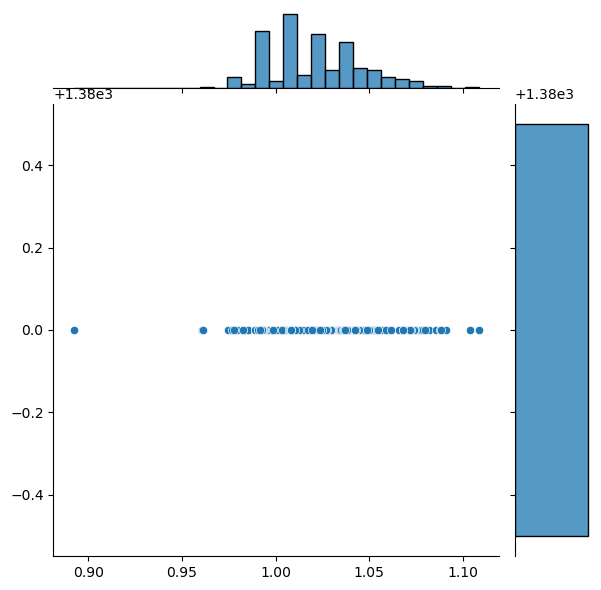

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for j in [0, 1, 2, 3]: # four size state

lst_frame_size = [int(ana_mat_lean[i][cols['data.len']]) for i in range(len(ana_mat_lean[1:]))]
print(len(lst_frame_size))

lst_next_frame_interval = [ana_mat_lean[i+1][cols['frame.time_epoch']]-ana_mat_lean[i][cols['frame.time_epoch']] \
                           for i in range(len(ana_mat_lean)-1)]
print(len(lst_next_frame_interval))

print("Size > 200 frame counts: ", len([i for i in lst_frame_size if i > 200]))

print("Length > 0.8 sec frame counts: ", len([i for i in lst_next_frame_interval if i > 0.8]))


# for i in range(len(lst_seg_time)):
#     tmp_time = lst_seg_time[i]
#     tmp_tap_count = lst_seg_tap_count[i]
#     if tmp_tap_count > 2 and tmp_time > 0.02 and tmp_time < 0.09:
#         lst_seg_time_trim.append(tmp_time)
#         lst_seg_tap_count_trim.append(tmp_tap_count)

# # Generate some test data
x = np.array(lst_next_frame_interval[4:])
y = np.array(lst_frame_size[4:])
# sns.jointplot(x=x, y=y, xlim=[0.95, 1.05], ylim=[1200, 1500], kind='scatter')
sns.jointplot(x=x, y=y, kind='scatter')
plt.show()

Observation

The above message type has an unique frame size 1380 bytes and inter-frame interval length around 1 sec. It can be viewed as some heart beat signals in DL at 1 Hz. The data rate is around 11+ kbps.


#### Case 2. 80:23

This type of messages was also spotted from the start to the end during the measurement. It serves in the whole session.

6892
6892
Figure saved as  Packet TransmissionsData Type_80:23


<Figure size 1200x800 with 0 Axes>

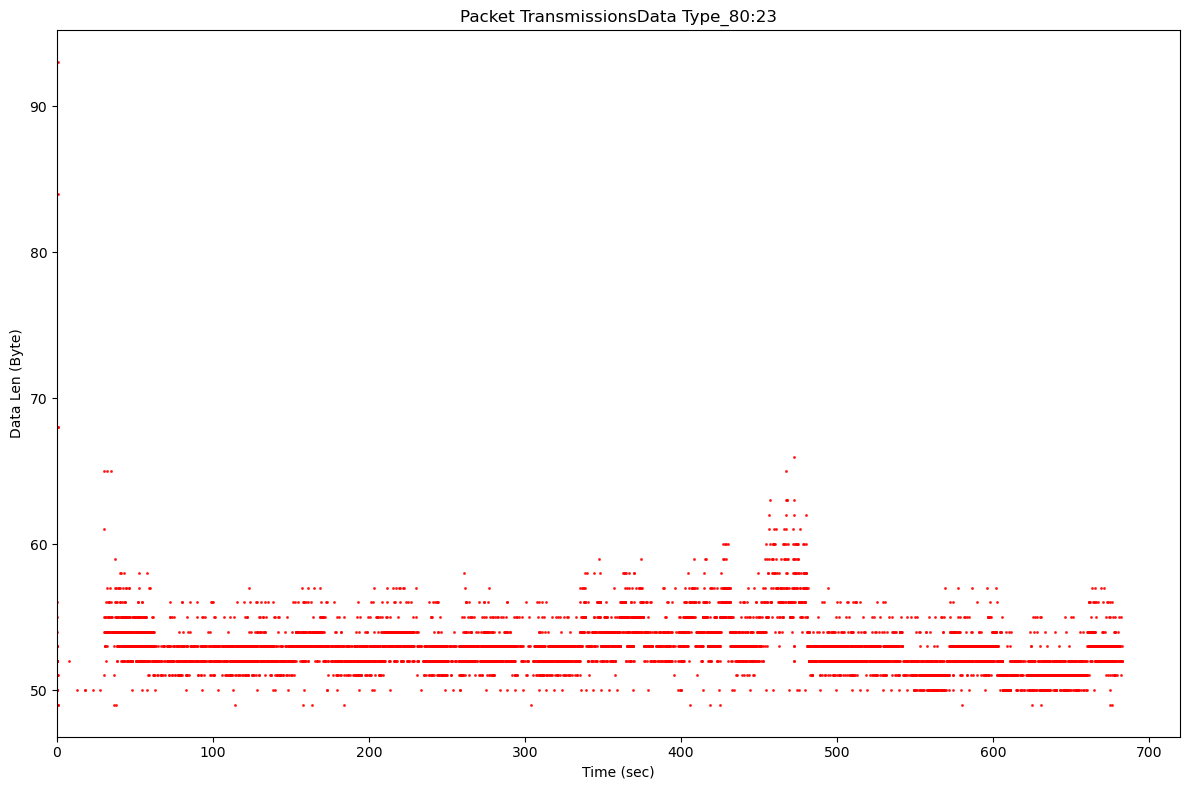

In [12]:
ana_mat_lean = []

lst_display_data_type = ["80:23"]

for i in ana_mat:
    if i[cols["data.type"]] in ["80:23"]:
#     if i[cols["data.type"]] in ["80:65", "80:23", "80:00"]:
#     if i[cols["data.type"]] in ["80:23"] and i[cols["data.data"]][6:11] == "00:00":
        ana_mat_lean.append(i.copy())
        
len(ana_mat_lean)

timeline = []
len_list = []

for i in ana_mat_lean:
    #print(i[:])
#     if i[cols['stream_id']]==stream_id:
    timeline.append(i[cols['frame.time_epoch']])
    len_list.append(int(i[cols['ip.len']]))
        
print(len(timeline))
# print(stream_dir_list[stream_id])
print(len(timeline))

# pic_title = "Link: "+stream_dir_list[stream_id]
str_displayed_data_type =""
for i in lst_display_data_type:
    str_displayed_data_type += "_"
    str_displayed_data_type += i
    

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 720#pcap_end_time
scatterplot(timeline, len_list, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Data Len (Byte)", title=pic_title, figSave=True, fig_index="")

[8.384, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.192, 0.0, 0.0]
Figure saved as  Packet TransmissionsData Type_80:23


<Figure size 1200x800 with 0 Axes>

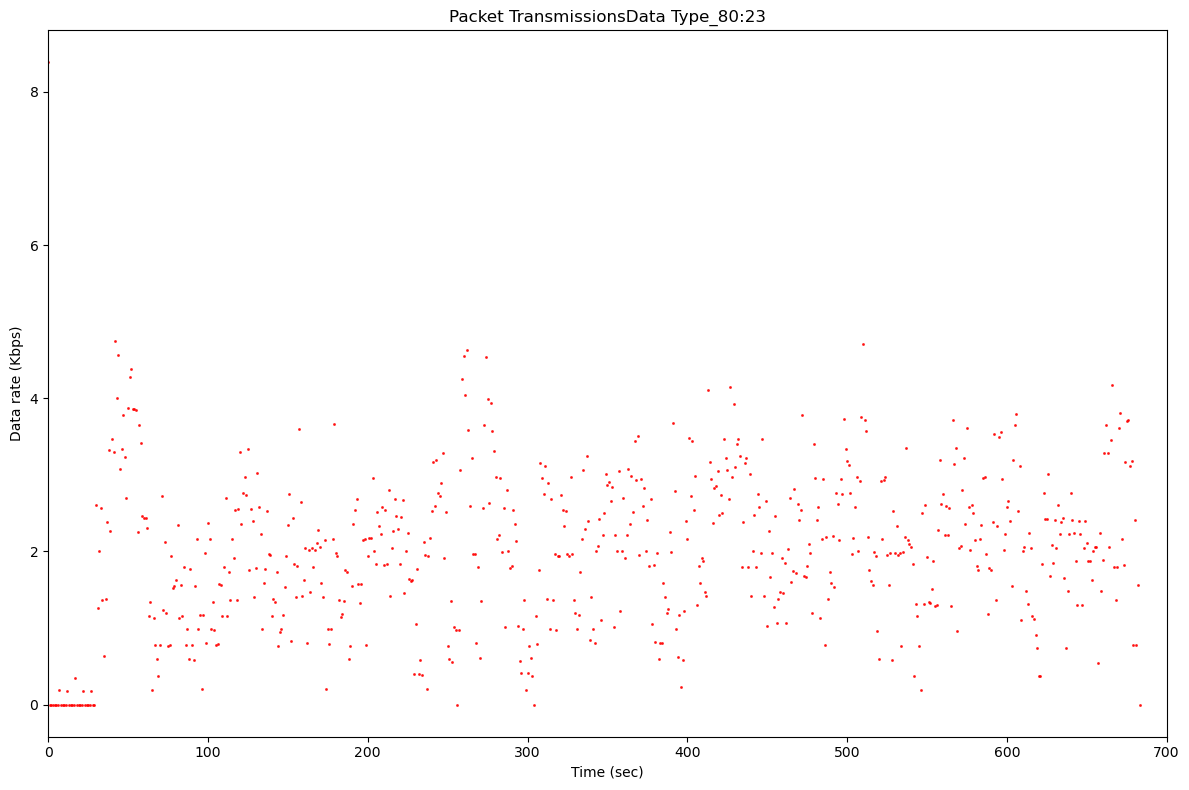

In [13]:
# Throughput of the selected data stream

import math

step = 1 #sec

start_time = 0
end_time = math.ceil(ana_mat_lean[-1][cols["frame.time_epoch"]]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat_lean:
    len_tmp = int(i[cols["data.len"]])
    time_tmp = i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

print(lst_rate_kbps[:10])


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 700#pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

6891
6891
Size < 100 frame counts:  6891
Length > 0.8 sec frame counts:  19


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


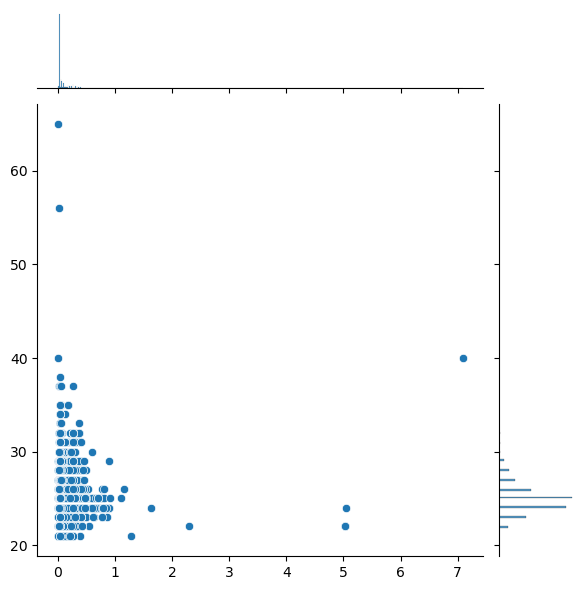

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for j in [0, 1, 2, 3]: # four size state

lst_frame_size = [int(ana_mat_lean[i][cols['data.len']]) for i in range(len(ana_mat_lean[1:]))]
print(len(lst_frame_size))

lst_next_frame_interval = [ana_mat_lean[i+1][cols['frame.time_epoch']]-ana_mat_lean[i][cols['frame.time_epoch']] \
                           for i in range(len(ana_mat_lean)-1)]
print(len(lst_next_frame_interval))

print("Size < 100 frame counts: ", len([i for i in lst_frame_size if i < 100]))

print("Length > 0.8 sec frame counts: ", len([i for i in lst_next_frame_interval if i > 0.8]))


# for i in range(len(lst_seg_time)):
#     tmp_time = lst_seg_time[i]
#     tmp_tap_count = lst_seg_tap_count[i]
#     if tmp_tap_count > 2 and tmp_time > 0.02 and tmp_time < 0.09:
#         lst_seg_time_trim.append(tmp_time)
#         lst_seg_tap_count_trim.append(tmp_tap_count)

# # Generate some test data
x = np.array(lst_next_frame_interval)
y = np.array(lst_frame_size)
# sns.jointplot(x=x, y=y, xlim=[0.95, 1.05], ylim=[1200, 1500], kind='scatter')
sns.jointplot(x=x, y=y, kind='scatter')
plt.show()

#### Observation

This stream didn't contribute much to the entire data rate since it only added less than 1 kbps in the DL. We will skipp modeling this stream in the traffic model. 

#### Case 3. 80:00

This type of messages contain data for the rendered MXR content. Therefore, they are the real meat in this study. 

54709
54709
Figure saved as  Packet TransmissionsData Type_80:00


<Figure size 1200x800 with 0 Axes>

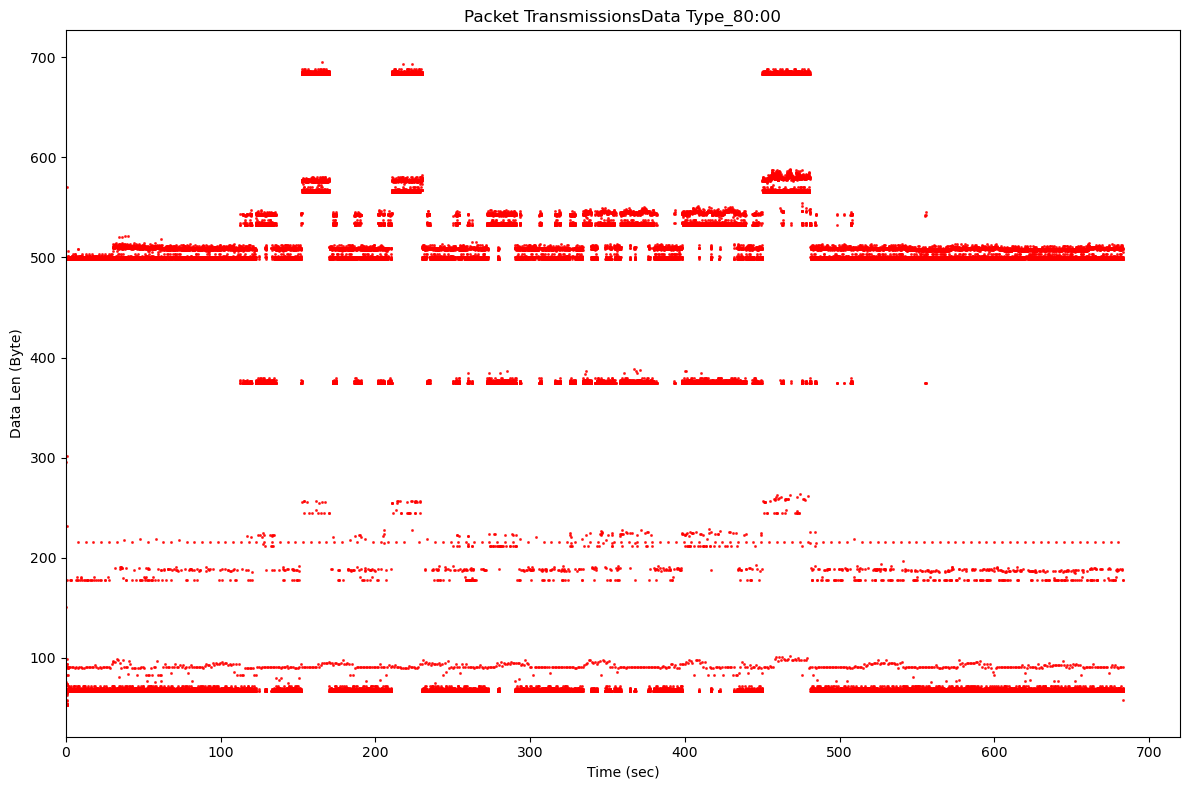

In [15]:
#### New matrix stores 80:00 data ONLY
ana_mat_lean = []
####

lst_display_data_type = ["80:00"]

for i in ana_mat:
    if i[cols["data.type"]] in ["80:00"]:
#     if i[cols["data.type"]] in ["80:65", "80:23", "80:00"]:
#     if i[cols["data.type"]] in ["80:23"] and i[cols["data.data"]][6:11] != "00:00":
        ana_mat_lean.append(i.copy())
        
len(ana_mat_lean)

timeline = []
len_list = []

for i in ana_mat_lean:
    #print(i[:])
#     if i[cols['stream_id']]==stream_id:
    timeline.append(i[cols['frame.time_epoch']])
    len_list.append(int(i[cols['ip.len']]))
        
print(len(timeline))
# print(stream_dir_list[stream_id])
print(len(timeline))

# pic_title = "Link: "+stream_dir_list[stream_id]
str_displayed_data_type =""
for i in lst_display_data_type:
    str_displayed_data_type += "_"
    str_displayed_data_type += i
    

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 720#pcap_end_time
scatterplot(timeline, len_list, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Data Len (Byte)", title=pic_title, figSave=True, fig_index="")

[72.536, 179.696, 160.968, 154.632, 151.544, 172.056, 148.952, 158.768, 151.512, 142.28]
Figure saved as  Packet TransmissionsData Type_80:00


<Figure size 1200x800 with 0 Axes>

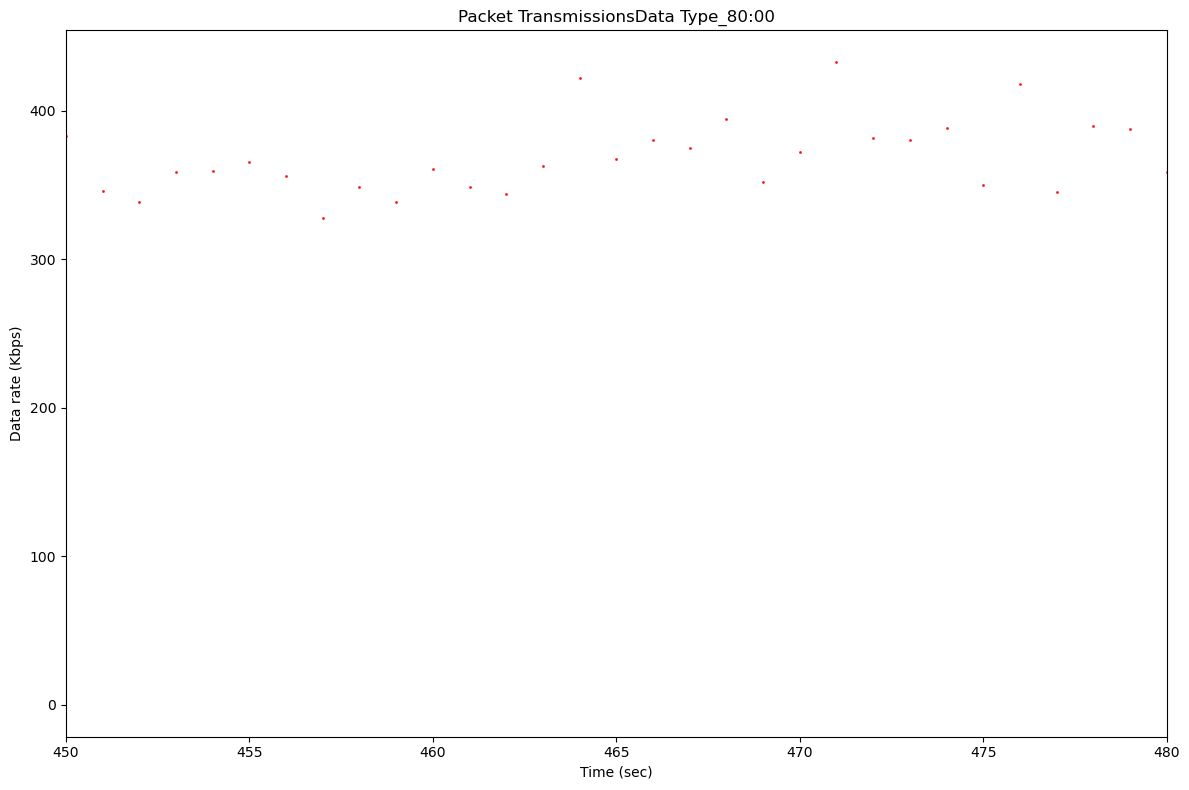

In [16]:
# Throughput of the selected data stream

import math

step = 1 #sec

start_time = 0
end_time = math.ceil(ana_mat_lean[-1][cols["frame.time_epoch"]]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat_lean:
    len_tmp = int(i[cols["data.len"]])
    time_tmp = i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

print(lst_rate_kbps[:10])


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 450
x_max_display = 480#pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

54708
54708
Length < 0.08 sec frame counts:  54705


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


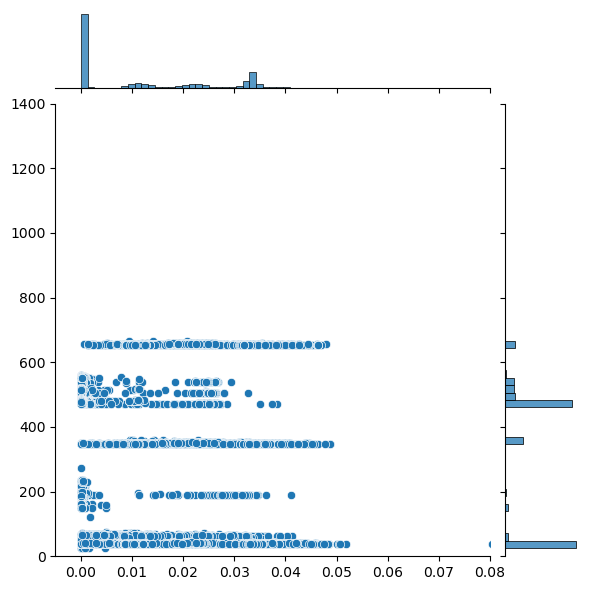

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for j in [0, 1, 2, 3]: # four size state

lst_frame_size = [int(ana_mat_lean[i][cols['data.len']]) for i in range(len(ana_mat_lean[1:]))]
print(len(lst_frame_size))

lst_next_frame_interval = [ana_mat_lean[i+1][cols['frame.time_epoch']]-ana_mat_lean[i][cols['frame.time_epoch']] for i in range(len(ana_mat_lean)-1)]
print(len(lst_next_frame_interval))

# print("Size < 100 frame counts: ", len([i for i in lst_frame_size if i < 100]))

# print("Length > 0.8 sec frame counts: ", len([i for i in lst_next_frame_interval if i > 0.8]))
print("Length < 0.08 sec frame counts: ", len([i for i in lst_next_frame_interval if i < 0.08]))

# for i in range(len(lst_seg_time)):
#     tmp_time = lst_seg_time[i]
#     tmp_tap_count = lst_seg_tap_count[i]
#     if tmp_tap_count > 2 and tmp_time > 0.02 and tmp_time < 0.09:
#         lst_seg_time_trim.append(tmp_time)
#         lst_seg_tap_count_trim.append(tmp_tap_count)

# # Generate some test data
x = np.array(lst_next_frame_interval)
y = np.array(lst_frame_size)
sns.jointplot(x=x, y=y, xlim=[-0.005, .08], ylim=[0, 1400], kind='scatter')
# sns.jointplot(x=x, y=y, kind='scatter')
plt.show()

#### The following is the burst-based pattern analysis

First, identify all possible bursts in the DL traffic with the message type of "80:00"


In [18]:
### Create a new matrix to store the data for analysis, inherit the columns from the copied one
ana_mat_burst = [] 
####

for i in ana_mat_lean:
    i[cols["data.seg.idx"]] = -1
    i[cols["data.seg.tap.idx"]] = -1
    i[cols["data.type.name"]] = "NA"

    ana_mat_burst.append(i.copy())
    
# safety check
for i in ana_mat_burst:
    if i[cols["data.type"]] != "80:00":
        print("Alert!! Unrecognized message types: ", i[cols["data.type"]])
        
# 
len_ana_mat_burst = len(ana_mat_burst)

print(len(ana_mat_burst))


lst_frame_states = ["head", "tail"]

idx_burst_curr = -1
idx_burst_tap_curr = -1

time_last_burst = -1

burst_seq_last = "ffff"


state_burst_curr = "head"

state_frame_last = "tail"
time_frame_last = 0

max_tap_idx = -1

num_outliers = 0
dict_outliers = {}
lst_outlier_count = [0 for i in range(10)]

for i in range(len(ana_mat_burst)):
    
    i_time = ana_mat_burst[i][cols["frame.time_epoch"]]
    i_frame_type_second = ana_mat_burst[i][cols["data.type.second"]] # identify unique burst
    i_frame_type_sub = ana_mat_burst[i][cols["data.type.sub"]] # identify "head"/"tail" frames in a burst
    
    if i_frame_type_sub == "04:01":
        i_frame_state = "head"
    elif i_frame_type_sub == "04:02":
        i_frame_state = "tail"
    else:
        i_frame_state = i_frame_type_sub
        if i_frame_type_sub not in dict_outliers:
            dict_outliers[i_frame_type_sub] = len(dict_outliers)
            
        lst_outlier_count[dict_outliers[i_frame_type_sub]] += 1
        
        num_outliers += 1
#         print("!!! Alert: unexpected message type: {}, {} at frame# {}".format(i_frame_type_second, \
#                                                                                i_frame_type_sub, \
#                                                                               ana_mat_burst[i][cols["frame.number"]]))
    
    if i_frame_state == "head" or i_frame_state == "tail":
        if i_frame_type_second != burst_seq_last: # a new burst being identified by the 4 digits following the type prefix 80:00
            idx_burst_curr += 1
            idx_burst_tap_curr = 0
            
            burst_seq_last = i_frame_type_second
            time_last_burst = i_time
            
        else: # in the same burst as the last frame
            idx_burst_tap_curr += 1
        
        # Update the flag
        ana_mat_burst[i][cols["data.seg.idx"]] = idx_burst_curr
        ana_mat_burst[i][cols["data.seg.tap.idx"]] = idx_burst_tap_curr
        ana_mat_burst[i][cols["data.type.name"]] = i_frame_state
        
#         if idx_burst_tap_curr > 2:
#             print("Frame# {}, Tap# {}, state {}".format(ana_mat_burst[i][cols["frame.number"]], idx_burst_tap_curr, i_frame_state))
    
for i in dict_outliers:
    print("Type.sub: {}, count: {}".format(i, lst_outlier_count[dict_outliers[i]]))
    
    
max_burst_tap = -1

lst_burst_tap = [i[cols["data.seg.tap.idx"]] for i in ana_mat_burst]

print(max(lst_burst_tap))

lst_tap_freq_count = [0 for i in range(max(lst_burst_tap)+1)]

for i in ana_mat_burst:
    if i[cols["data.seg.tap.idx"]] >=0:
        lst_tap_freq_count[i[cols["data.seg.tap.idx"]]] += 1
    

for i in range(len(lst_tap_freq_count)):
    print("Tap {}: {} counts".format(i, lst_tap_freq_count[i]))
# print(lst_tap_freq_count)

54709
Type.sub: 04:00, count: 149
Type.sub: 04:09, count: 696
Type.sub: 04:08, count: 3
Type.sub: 04:03, count: 3
Type.sub: 04:04, count: 3
Type.sub: 04:05, count: 3
Type.sub: 04:06, count: 4
5
Tap 0: 20489 counts
Tap 1: 20481 counts
Tap 2: 6780 counts
Tap 3: 6095 counts
Tap 4: 2 counts
Tap 5: 1 counts


Found non-burst frames:  861


(array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
        390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690]),
 [Text(0, 0, '0'),
  Text(30, 0, '30'),
  Text(60, 0, '60'),
  Text(90, 0, '90'),
  Text(120, 0, '120'),
  Text(150, 0, '150'),
  Text(180, 0, '180'),
  Text(210, 0, '210'),
  Text(240, 0, '240'),
  Text(270, 0, '270'),
  Text(300, 0, '300'),
  Text(330, 0, '330'),
  Text(360, 0, '360'),
  Text(390, 0, '390'),
  Text(420, 0, '420'),
  Text(450, 0, '450'),
  Text(480, 0, '480'),
  Text(510, 0, '510'),
  Text(540, 0, '540'),
  Text(570, 0, '570'),
  Text(600, 0, '600'),
  Text(630, 0, '630'),
  Text(660, 0, '660'),
  Text(690, 0, '690')])

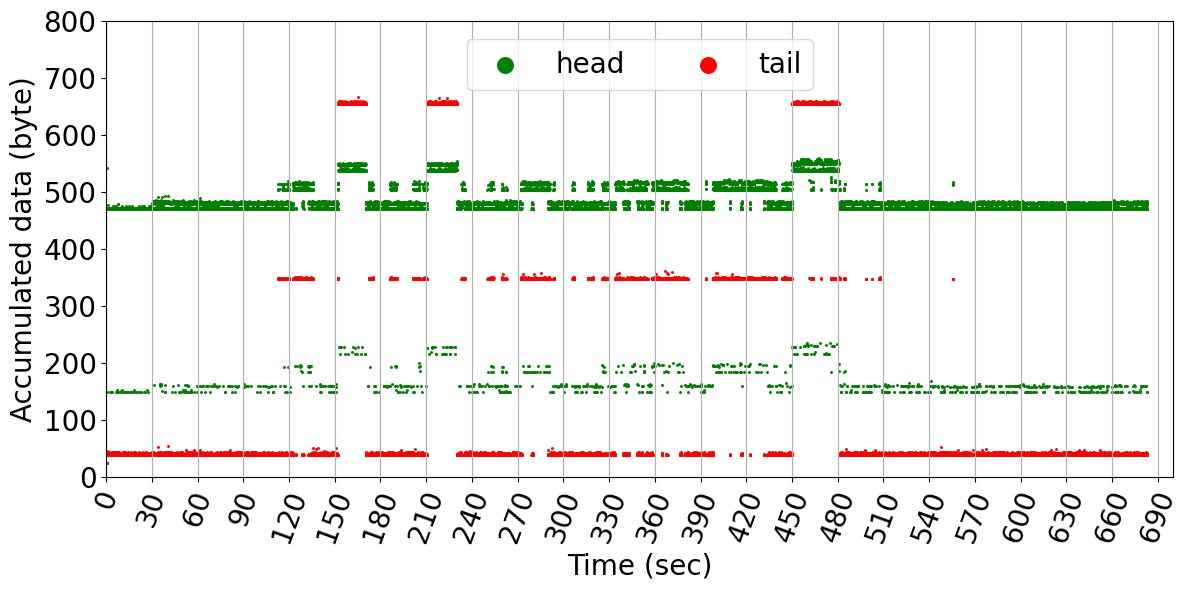

In [19]:
# 80:23 data only
# list 0: head; list 1: core; list 2: tail; list 3: other

list_lst_time_plot_8000 = [[],[],[]]
list_lst_pkt_plot_8000 = [[],[],[]]


for i in ana_mat_burst:
    if i[cols["data.type.name"]] in ["head"]:
        lst_ind = 0
    elif i[cols["data.type.name"]] in ["tail"]:
        lst_ind = 1
    else:
        lst_ind = 2
        
    list_lst_time_plot_8000[lst_ind].append(i[cols["frame.time_epoch"]])
    list_lst_pkt_plot_8000[lst_ind].append(int(i[cols["data.len"]]))
    
print("Found non-burst frames: ", len(list_lst_time_plot_8000[2]))    
    
colors = ['g', 'r', 'k']

labels = ['head', "tail", "Others"]
    
markers = ['.', '.', '.']
    
_, ax = plt.subplots(figsize=(12, 6))

for i in range(2):
    # Create the plot object
    

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
    ax.scatter(list_lst_time_plot_8000[i], list_lst_pkt_plot_8000[i], s = 5, color = colors[i], 
               label = labels[i], alpha = 1, marker='.')


# ax.scatter(lst_time_sim, lst_size_accum, s = 5, color = 'b', label = 'Sim', alpha = 0.75, marker='o')


# if yscale_log == True:
#     ax.set_yscale('log')

# # Label the axes and provide a title
# ax.set_title(title)
# ax.set_xlabel("Time (sec)")
# ax.set_ylabel("Accumulated data (byte)")
# # if x_xlim[0]<x_xlim[1]:
# ax.set_xlim(0, 700)
# ax.legend()



plt.gca().xaxis.grid(True)

ax.set_xlabel("Time (sec)", fontsize = 20)
ax.set_ylabel("Accumulated data (byte)", fontsize = 20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# if x_xlim[0]<x_xlim[1]:
ax.set_xlim(0, 700)
ax.set_ylim(0, 800)
ax.legend(fontsize = 20, bbox_to_anchor=(0.5, 0.99), loc='upper center', ncol=3, markerscale=10)
    
    
ax.set_xticks([i*30 for i in range(24)])
plt.xticks(rotation=70)
# print('The outliers different from the identified three sub-burst frames: ', list_lst_time_plot_8023[3])

In [20]:
# check all unique "data.type.sub" and find the population

lst_phase_record = [
    [0, 30, 0], # 0: headset connected, VR Preview not enabled, idling (State 0)
    [30, 60, 1], # 1, VR Preview enabled, no XR displayed (State 1)
    [60, 120, 2], # 2, XR contented displayed (semi-static) (State 2)
    [120, 150, 3], # 3, user input sensed (one hand in view) (State 3)
    [150, 180, 4], # 4, user input sensed (two hands in view) (State 4)
    [180, 210, 2], # 5, back to State 2
    [210, 240, 4], # 6, repeat State 4
    [240, 270, 2], # 7, back to State 2
    [270, 300, 3], # 8, Repeat State 3
    [300, 330, 2], # 9, back to State 2
    [330, 450, 5], # 10, user input (one hand, manipulate XR content) (State 5)
    [450, 480, 6], # 11, user input (two hands, manipulate XR content) (State 6)
    [480, 540, 2], # 12, back to State 2headset connected, VR Preview not enabled, idling
    [540, 570, 7], # 13, XR content change in the view (head rotation) (State 7)
    [570, 600, 2], # 14, back to State 2
    [600, 660, 7], # 15, XR content change in the view (head rotation) (State 7)
    [660, 680, 2] # 16, back to State 2
]



    
print(lst_phase_record)   

dict_op_state_def ={}
dict_op_state_def[0] = "State 0: idle link, headset connected, VR Preview not enabled"
dict_op_state_def[1] = "State 1: VR Preview enabled, no XR content overlayed"
dict_op_state_def[2] = "State 2: XR contented overlayed (semi-static)"
dict_op_state_def[3] = "State 3: user input sensed (one hand in view)"
dict_op_state_def[4] = "State 4: user input sensed (two hands in view)"
dict_op_state_def[5] = "State 5: user input (one hand, manipulate XR content)"
dict_op_state_def[6] = "State 6: user input (two hands, manipulate XR content)"
dict_op_state_def[7] = "State 7: XR content change in the view (head rotation)"

[[0, 30, 0], [30, 60, 1], [60, 120, 2], [120, 150, 3], [150, 180, 4], [180, 210, 2], [210, 240, 4], [240, 270, 2], [270, 300, 3], [300, 330, 2], [330, 450, 5], [450, 480, 6], [480, 540, 2], [540, 570, 7], [570, 600, 2], [600, 660, 7], [660, 680, 2]]


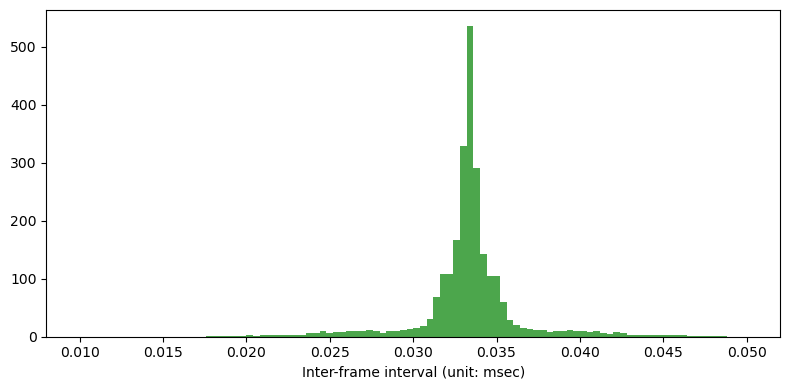

In [21]:
mat_seg_interval = []

last_seg_start_time = ana_mat_burst[0][cols["frame.time_epoch"]]
# last_seg_idx = ana_mat_burst[0][cols["data.seg.idx"]]

for i in ana_mat_burst[1:]:
    if i[cols["data.seg.tap.idx"]] == 0:
        curr_seg_start_time = i[cols["frame.time_epoch"]]
        last_seg_duration = curr_seg_start_time - last_seg_start_time
        
        mat_seg_interval.append([last_seg_start_time, last_seg_duration])
        
        last_seg_start_time = curr_seg_start_time
        
len(mat_seg_interval)

lst_seg_interval = [i[1] for i in mat_seg_interval]

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 100



# plot the histogram
n, bins, patches = ax.hist(lst_seg_interval, num_bins, 
                           range=[0.01, 0.05],
                            density = 1,
                            color ='green',
                            alpha = 0.7)

# plot the cumulative histogram
# n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')


plt.xlabel('Inter-frame interval (unit: msec)')
# plt.ylabel('Y-Axis')

# title_print = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
#                                                                        phase_state, phase_state_term, \
#                                                                       len(lst_seg_interval_per_phase))

# plt.title(title_print,
#           fontweight = "bold")

plt.show()

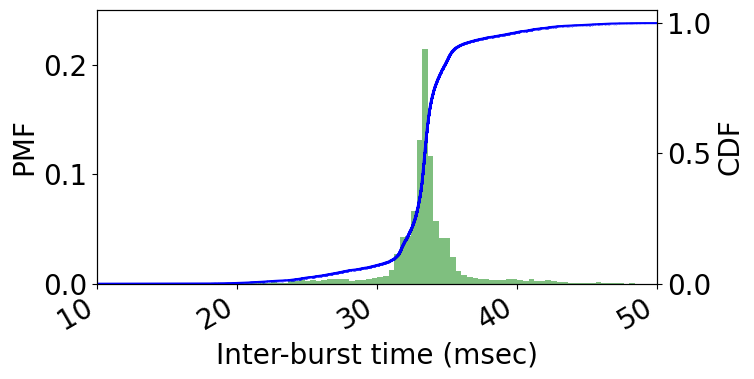

In [22]:
## Plot the PMF and CDF in one plot and show the results in msec
## Ref: https://python-graph-gallery.com/line-chart-dual-y-axis-with-matplotlib/

## 0. Get the msec version data

lst_seg_interval_msec = [i*1000 for i in lst_seg_interval]


## 1. Obtain CDF of the IFT in msec

data_sorted = np.sort(lst_seg_interval_msec)

# calculate the proportional values of samples
p = 1. * np.arange(len(lst_seg_interval_msec)) / (len(lst_seg_interval_msec) - 1)

# Save the CDF and the range for future model implementations
interval_range = data_sorted
interval_cdf = p

# 2. Plot two cures in one plot with their own y axis

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()


# Plot PMF
num_bins = 100

### PMF-like Y axix, ref: https://stackoverflow.com/questions/38650550/cant-get-y-axis-on-matplotlib-histogram-to-display-probabilities
n, bins, patches = ax1.hist(lst_seg_interval_msec, num_bins,
                           range=[10, 50],
#                             histtype='step',
                            weights=np.ones_like(lst_seg_interval_msec) / len(lst_seg_interval_msec),
                            density = False,
                            color ='green',
                            alpha = 0.5)

ax1.set_xlabel("Inter-burst time (msec)", fontsize = 20)
ax1.set_ylabel("PMF", color='k', fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.set_ylim([0, 0.25])
# ax1.tick_params(axis="y", labelcolor=COLOR_TEMPERATURE)

# Plot CDF
ax2.plot(interval_range, interval_cdf, marker='.', markersize=0.1, color='b', alpha=1)
ax2.set_ylabel("CDF", color='k', fontsize=20)
# ax2.tick_params(axis="y", labelcolor=COLOR_PRICE)
ax2.set_ylim([0, 1.05])
ax2.set_xlim([10, 50])
ax2.tick_params(axis='y', labelsize=20)

# fig.suptitle("Temperature down, price up", fontsize=20)
fig.autofmt_xdate()

20.34306526184082 46.33307456970215
Save the data in the file:  rfh_us_ibt_msec_cdf.csv
column names:  {'ibt': 0, 'cdf': 1}


<Figure size 1200x800 with 0 Axes>

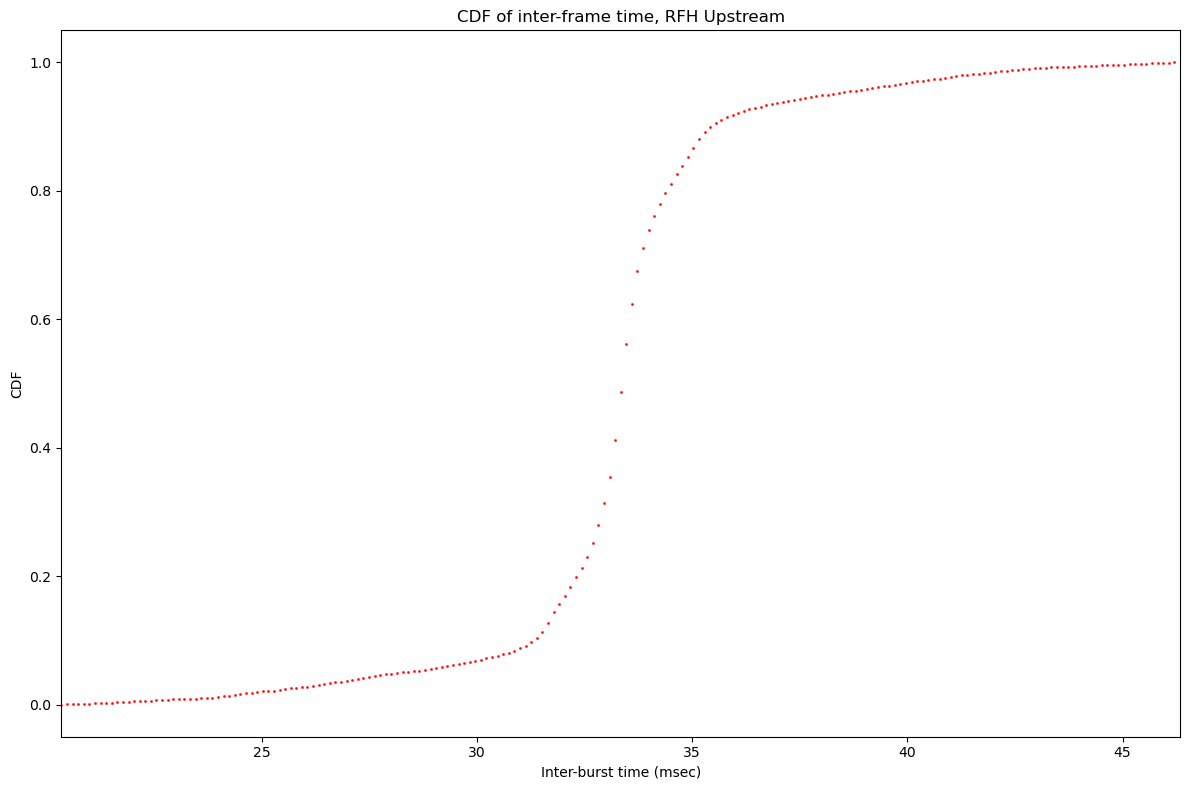

In [23]:
from statsmodels.distributions.empirical_distribution import ECDF

outlier_threshold_ = 3.0
outlier_count_ = 0
mean_var = np.mean(lst_seg_interval_msec)
std_var = np.std(lst_seg_interval_msec)

lst_ibt_msec_filtered = [i for i in lst_seg_interval_msec 
                        if abs(i-mean_var)/std_var <= outlier_threshold_]

data_sorted = np.sort(lst_ibt_msec_filtered) 


func_ecdf = ECDF(data_sorted)

num_sample = 200
min_sample = min(data_sorted)
max_sample = max(data_sorted)
step_sample = (max_sample - min_sample) / num_sample

lst_ibt_msec_export = [i*step_sample + min_sample for i in range(num_sample)]

lst_ibt_cdf_export = [func_ecdf(i) for i in lst_ibt_msec_export]

pic_title = "CDF of inter-frame time, RFH Upstream"
scatterplot(lst_ibt_msec_export, lst_ibt_cdf_export, x_xlim=[min_sample, max_sample], 
            x_label="Inter-burst time (msec)", y_label="CDF", title=pic_title, figSave=True)

print(min_sample, max_sample)
#############################################
## Export the data into CSV
write_file_path = "rfh_us_ibt_msec_cdf.csv" 
write_header_row = ["ibt", "cdf"]
cols_wrt = {k: v for v, k in enumerate(write_header_row)}

tmp_mat = [[lst_ibt_msec_export[i], lst_ibt_cdf_export[i]] for i in range(len(lst_ibt_cdf_export))]
if len(lst_ibt_msec_export) > 0:
    with open(write_file_path, mode='w', newline='') as wr_file:
        csv_writer = csv.writer(wr_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(write_header_row)
        csv_writer.writerows(tmp_mat)
    #os.remove(csv_file_path)
    #os.rename(write_file_path, csv_file_path)
    
print("Save the data in the file: ", write_file_path)

print("column names: ", cols_wrt)

### Observation

The inter-burst interval time is distributed around 0.33 msec, which reflects the 30 Hz refresh rate. Note that there also exist interval instances smaller or bigger than that.

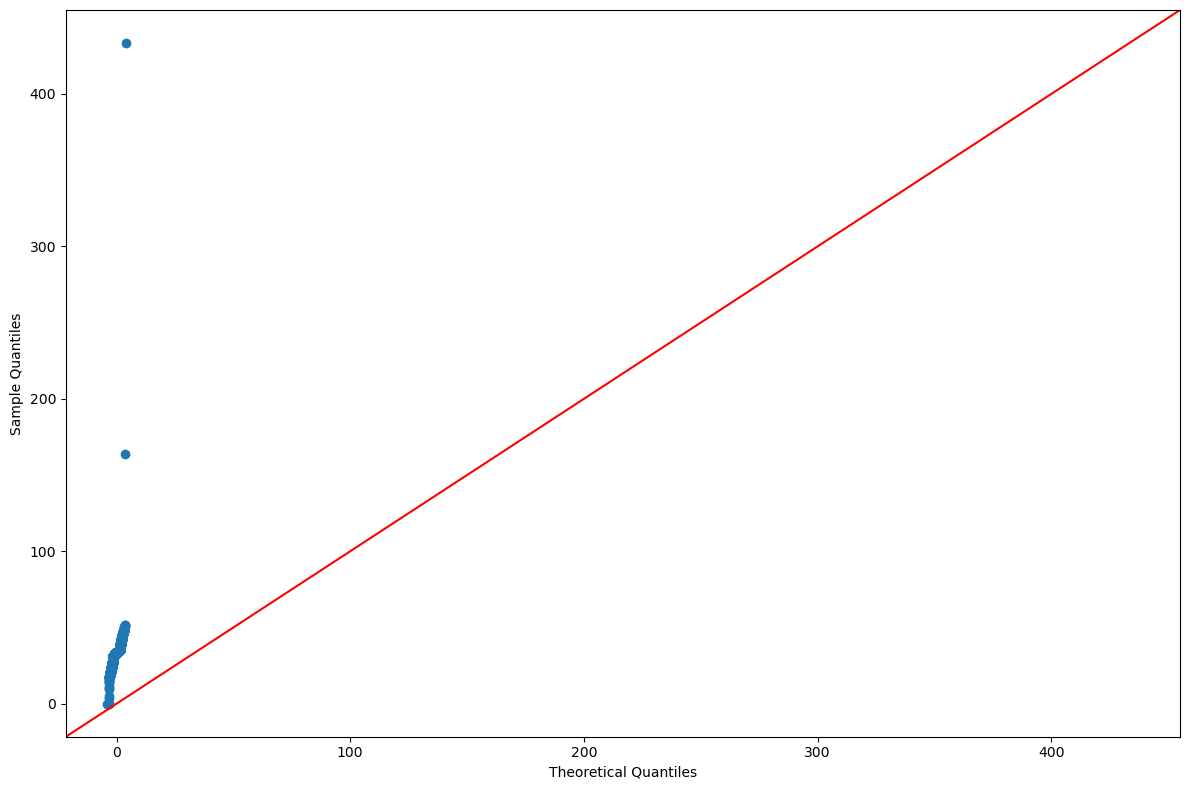

33.34244164839177 4.338624265479988


In [24]:
import statsmodels.api as sm

data = np.array(lst_seg_interval_msec)

fig = sm.qqplot(data, line='45')
plt.show()

#The Q-Q plot indicates the inter-burst time is not normally distributed.

from scipy.stats import norm

mu, std = norm.fit(lst_seg_interval_msec)

print(mu, std)

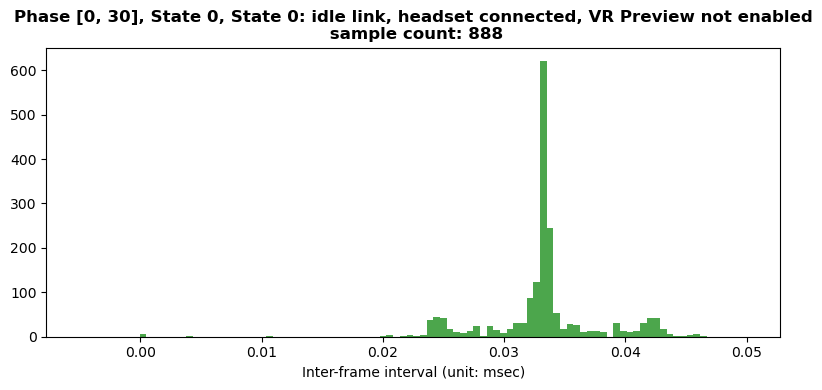

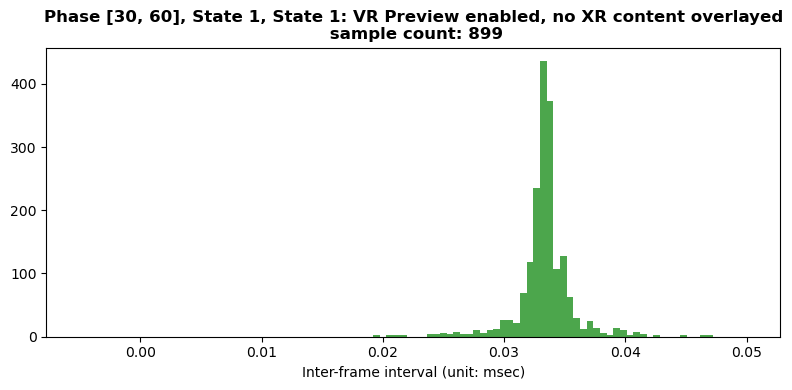

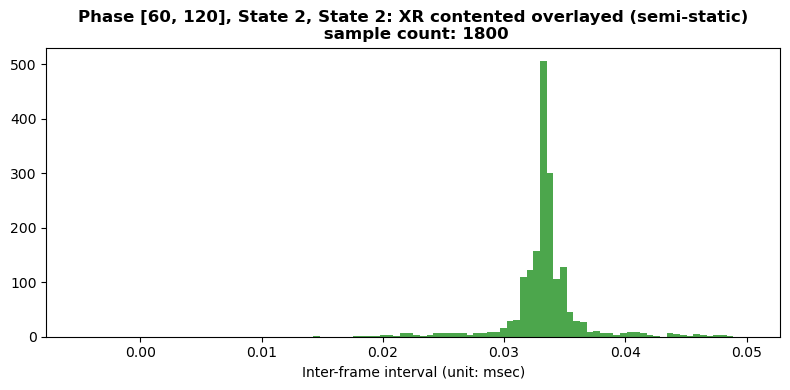

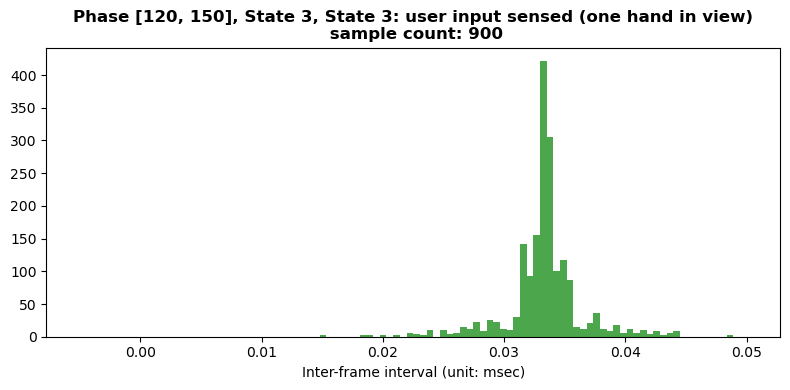

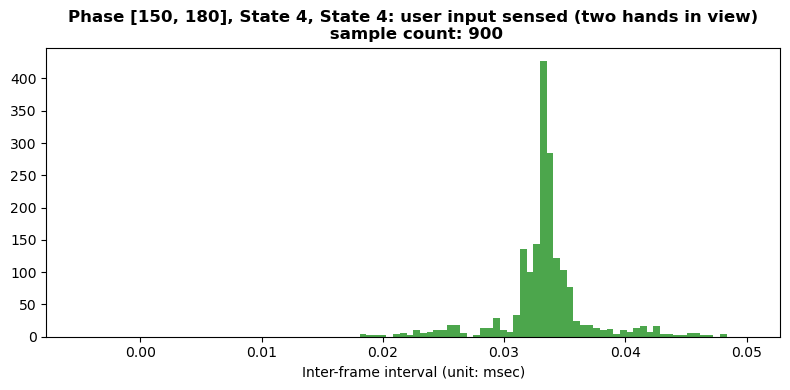

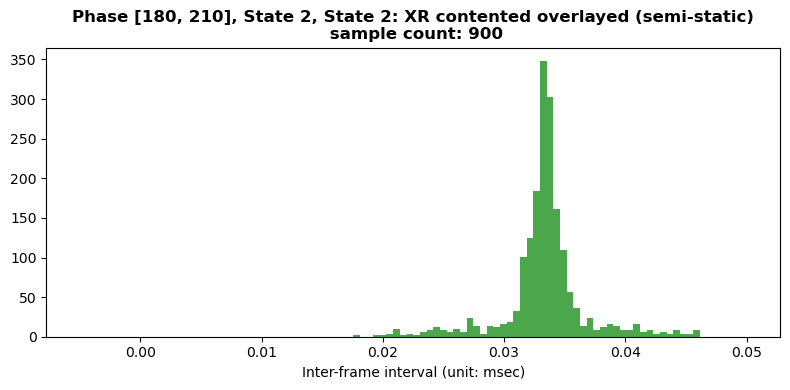

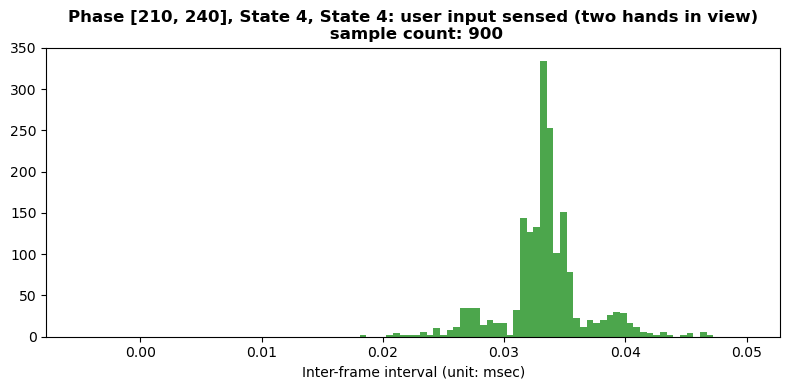

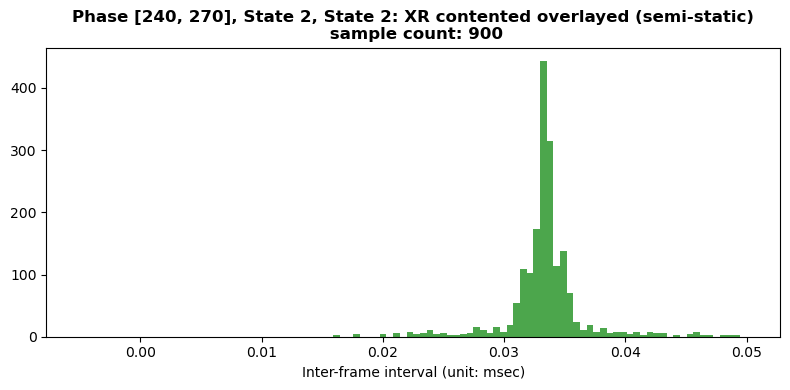

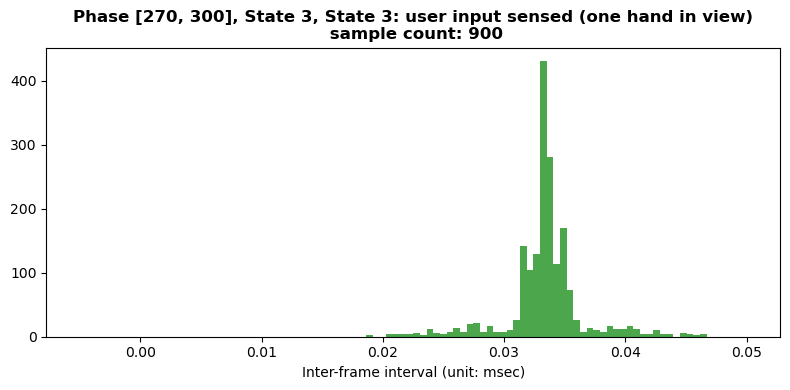

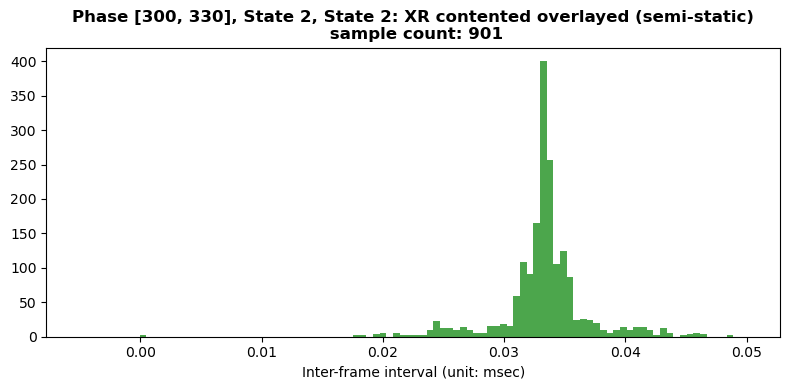

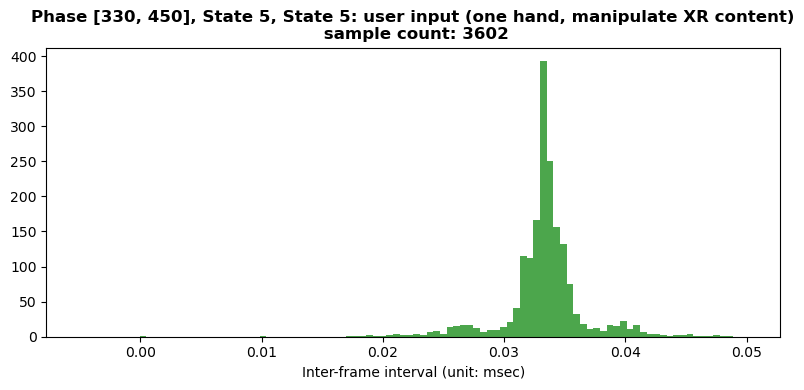

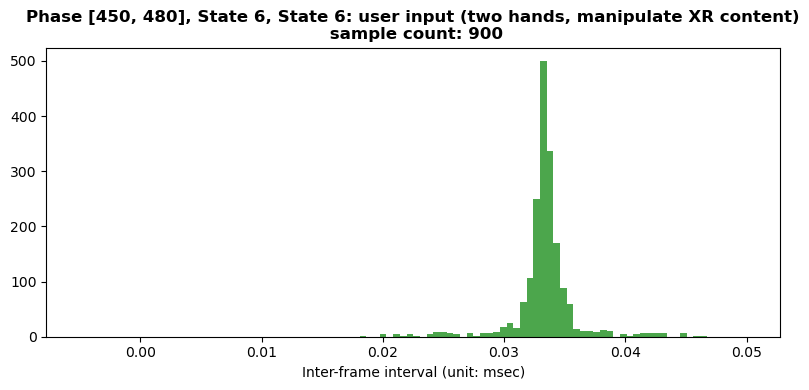

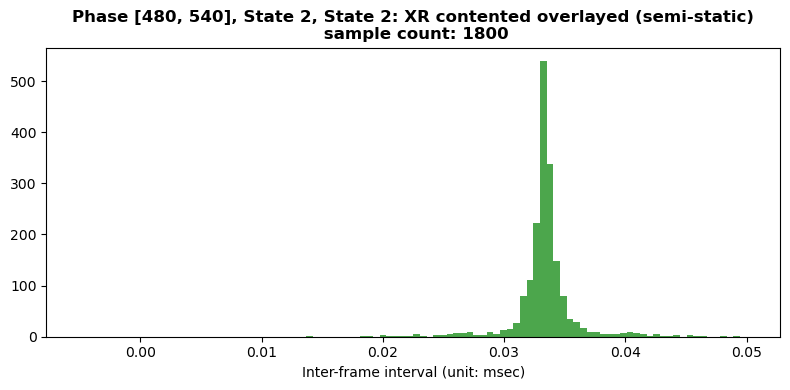

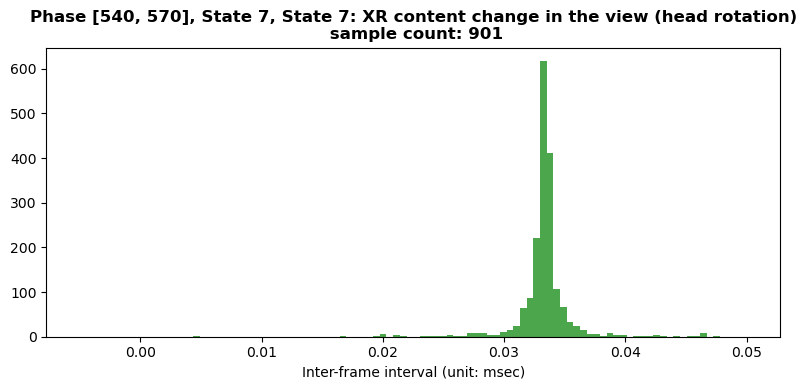

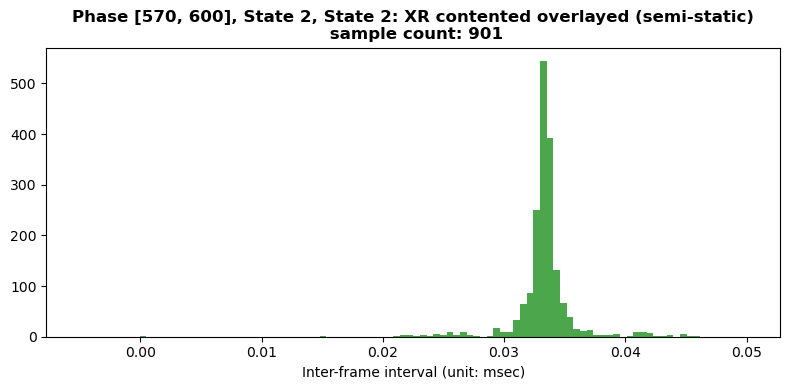

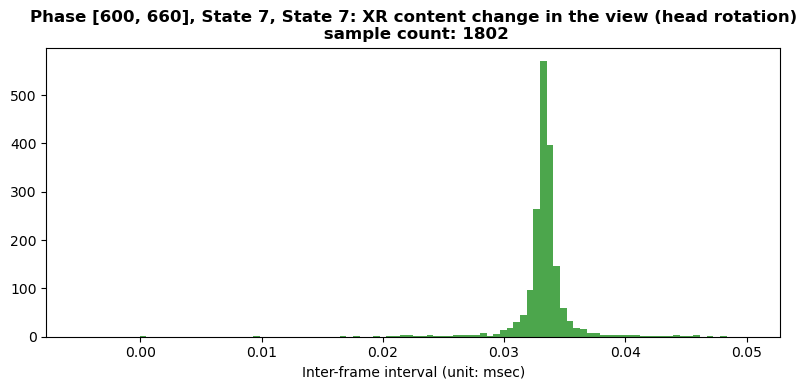

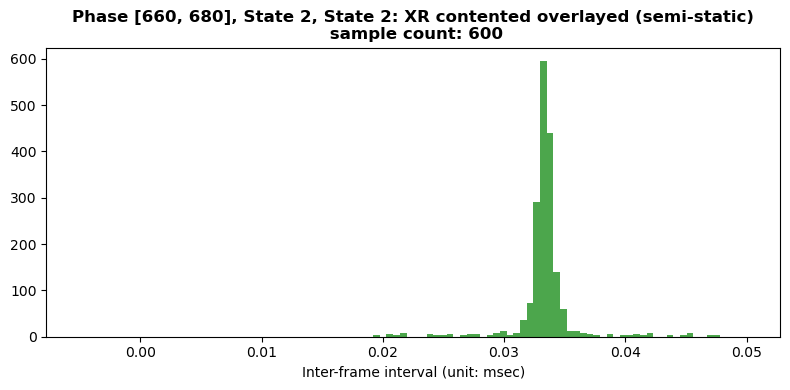

In [25]:
### Verify if the IBT varies with the application states.


import matplotlib.pyplot as plt
import numpy as np

for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    lst_seg_interval_per_phase = []
    for i in mat_seg_interval:
        if i[0] > phase_end_time:
            break # end the loop
            
        if i[0] >= phase_start_time:
            lst_seg_interval_per_phase.append(i[1])
            


    fig, ax = plt.subplots(figsize=(8, 4))

    num_bins = 100

    ## Plot the histogram of the i-th tags in segments

    # x_seq = [i for i in tag_lists[0] if i > 16000]
    # x_seq = [i for i in tag_lists[1] if i > 16000]
    # x_seq = [i for i in tag_lists[2] if i > 16000]
    # x_seq = [i for i in tag_lists[4] if i > 16000]
    #x_seq = [i for i in tag_lists[3]]
    # x_seq = [i for i in tag_lists[2]]        
    # print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


    # plot the histogram
    n, bins, patches = ax.hist(lst_seg_interval_per_phase, num_bins, 
                               range=[-0.005, 0.05],
                                density = 1,
                                color ='green',
                                alpha = 0.7)

    # plot the cumulative histogram
    # n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
    #                            cumulative=True, label='Empirical')


    plt.xlabel('Inter-frame interval (unit: msec)')
    # plt.ylabel('Y-Axis')
    
    title_print = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
                                                                           phase_state, phase_state_term, \
                                                                          len(lst_seg_interval_per_phase))

    plt.title(title_print,
              fontweight = "bold")

    plt.show()
            

### Observation

The IBT in different states follows the similar distribution with the peak around 33 msec.

In [26]:
### create a new matrix to store burst-wise data
ana_mat_burst_stat = []
####
# Define the matrix columns
lst_burst_mat_cols = ["burst.time", "burst.seq_num", "frame.type.lst", "frame.size.lst", "frame.number.lst", "frame.time.lst"]

burst_mat_cols = {k: v for v, k in enumerate(lst_burst_mat_cols)}

row_template = [-1, -1, [], [], [], []]

print(burst_mat_cols)

# new_row_ready = False
# tmp_row = [-1 for i in range(len(lst_burst_mat_cols))]

num_unexpected_frames = 0

for i in range(len(ana_mat_burst)):
    
    i_frame_type_name = ana_mat_burst[i][cols["data.type.name"]]
    i_burst_tap_id = ana_mat_burst[i][cols["data.seg.tap.idx"]]
    i_frame_len = int(ana_mat_burst[i][cols["data.len"]])
    i_frame_time = ana_mat_burst[i][cols["frame.time_epoch"]]
    i_frame_time_number = ana_mat_burst[i][cols["frame.number"]]
    
    if i == 0: # first row
        tmp_row = [-1, -1, [], [], [], []]
    else:
        if i_burst_tap_id == 0: # a new burst
            # save the previous burst row record
            ana_mat_burst_stat.append(tmp_row.copy())
            # reset the row 
            tmp_row = [-1, -1, [], [], [], []]
            
        
    if i_frame_type_name == "head" or i_frame_type_name == "tail":
        if i_burst_tap_id == 0: # first frame in the burst
            tmp_row[burst_mat_cols["burst.time"]] = i_frame_time
            tmp_row[burst_mat_cols["burst.seq_num"]] = ana_mat_burst[i][cols["data.type.second"]]
            
        tmp_row[burst_mat_cols["frame.type.lst"]].append(i_frame_type_name)
        tmp_row[burst_mat_cols["frame.size.lst"]].append(i_frame_len)
        tmp_row[burst_mat_cols["frame.number.lst"]].append(i_frame_time_number)
        tmp_row[burst_mat_cols["frame.time.lst"]].append(i_frame_time)
        

    else:
#         print("Alert: unexpected frame type: ", i_frame_type_name)
        num_unexpected_frames += 1
            

        
            

print("Total burst count: ", len(ana_mat_burst_stat))
print("Outlier count: ", num_unexpected_frames)

# lst_head_count = [1 for i in ana_mat_burst_stat if i[burst_mat_cols["head.size"]]>0]
# lst_tail_count = [1 for i in ana_mat_burst_stat if i[burst_mat_cols["tail.size"]]>0]
# print(len(lst_head_count), len(lst_tail_count))

ana_mat_burst_stat[1000]


for i in range(len(ana_mat_burst_stat)):
    if ana_mat_burst_stat[i][burst_mat_cols["frame.type.lst"]] == []:
        print("Found initial burst row at #:", i)
    else:
        if ana_mat_burst_stat[i][burst_mat_cols["frame.type.lst"]][0] not in ["head", "tail"]: 
            # Should be NONE as the other type frames were not included in this matrix
            print("Found unrecognized burst frame type: ", i)
        
        
# ana_mat_burst_stat[:2]

{'burst.time': 0, 'burst.seq_num': 1, 'frame.type.lst': 2, 'frame.size.lst': 3, 'frame.number.lst': 4, 'frame.time.lst': 5}
Total burst count:  20489
Outlier count:  861
Found initial burst row at #: 0


### Obtain a more accurate state identification during the timeline



In [27]:
# This timeline was calibrated with UL traffic pattern since the states were defined per user input events
lst_phase_record = [
    [0.5, 30, 0], # Phase 0: headset connected, VR Preview not enabled, idling (State 0)
    [30.5, 60, 1], # Phase 1, VR Preview enabled, no XR displayed (State 1)
    [60, 110, 2], # Phase 2, XR contented displayed (semi-static) (State 2)
    [123, 134.5, 3], # Phase 3, user input sensed (one hand in view) (State 3)
    [136, 151, 2], # Phase 4, back to State 2
    [152.5, 170, 4], # Phase 5, user input sensed (two hands in view) (State 4)
    [175, 186, 2], # Phase 6, back to State 2
    # between, mixed State 2 and 3
    [191, 201, 2], # Phase 7, back to State 2
    # between, [201, 211], mixed State 2 and 3
    [211, 230, 4], # 6, repeat State 4
    # [230, 236] # mixed State 2 and 3
    [236, 251, 2], # 7, back to State 2
    [255, 259, 2], # 8, State 2
    [261, 271, 2], # 9, State 2
    [273, 290, 3], # 10, Repeat State 3, ! Note that [279, 281] @ State 2
    [291, 330, 2], # 11, back to State 2 (slightly mixed with State 3)
    [330, 450, 5], # 12, user input (one hand, manipulate XR content) (State 5)
    [450, 480, 6], # 13, user input (two hands, manipulate XR content) (State 6)
    [482, 540, 2], # 14, back to State 2headset connected, VR Preview not enabled, idling
    [540, 570, 7], # 15, XR content change in the view (head rotation) (State 7)
    [570, 600, 2], # 16, back to State 2
    [600, 660, 7], # 17, XR content change in the view (head rotation) (State 7)
    [660, 680, 2] # 18, back to State 2
]

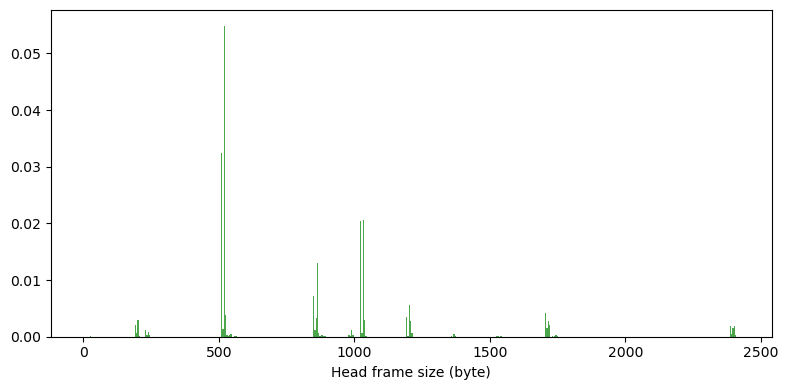

In [28]:
# burst size analysis
lst_burst_size = [sum(i[burst_mat_cols["frame.size.lst"]]) for i in ana_mat_burst_stat]

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 500

## Plot the histogram of the i-th tags in segments

# x_seq = [i for i in tag_lists[0] if i > 16000]
# x_seq = [i for i in tag_lists[1] if i > 16000]
# x_seq = [i for i in tag_lists[2] if i > 16000]
# x_seq = [i for i in tag_lists[4] if i > 16000]
#x_seq = [i for i in tag_lists[3]]
# x_seq = [i for i in tag_lists[2]]        
# print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


# plot the histogram
n, bins, patches = ax.hist(lst_burst_size, num_bins, 
                           #range=[-0.005, 0.05],
                            density = 1,
                            color ='green',
                            alpha = 0.7)

# plot the cumulative histogram
# n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')


plt.xlabel('Head frame size (byte)')
# plt.ylabel('Y-Axis')

# title_print = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
#                                                                        phase_state, phase_state_term, \
#                                                                       len(lst_seg_interval_per_phase))

# title_print = "Total count: "+ str(len(lst_head_size))

# plt.title(title_print,
#           fontweight = "bold")

plt.show()

882


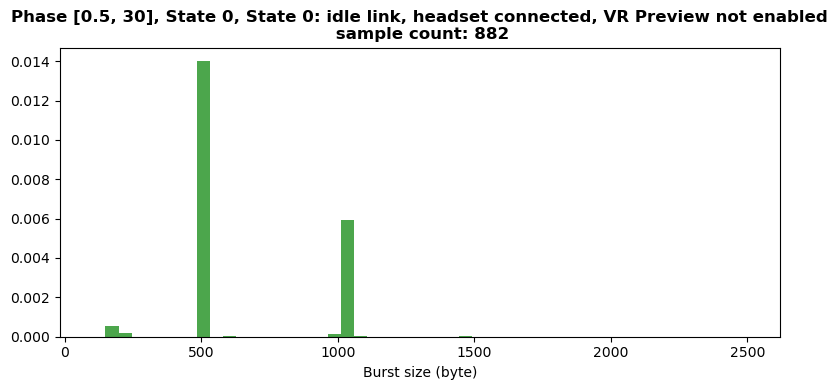

884


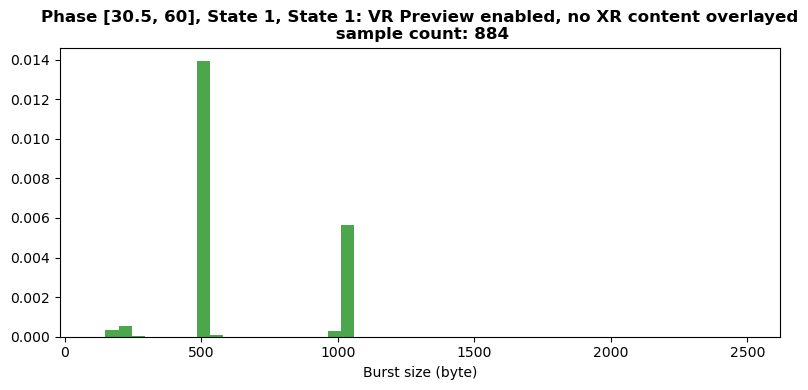

1500


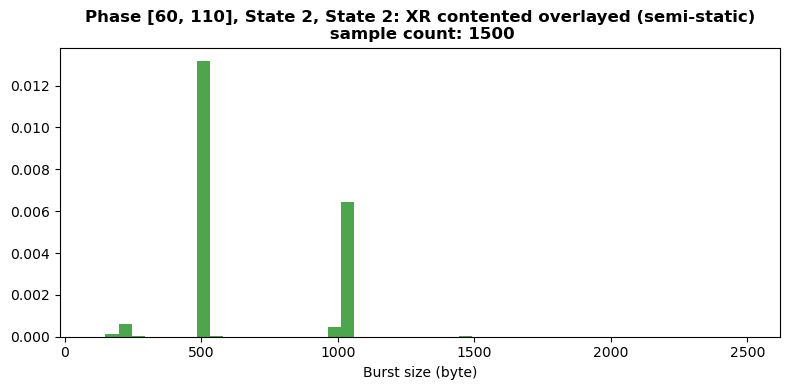

345


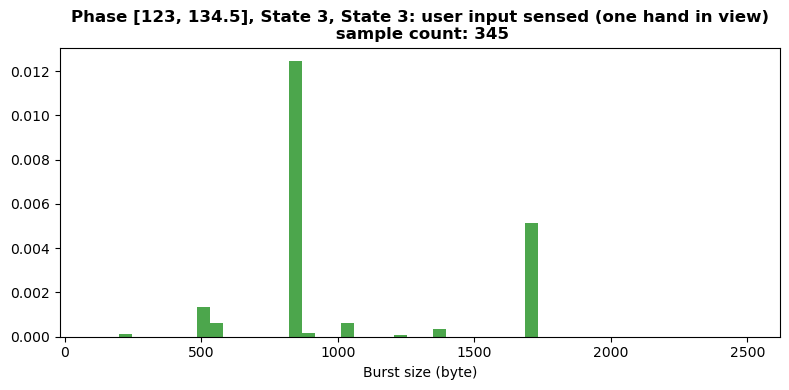

450


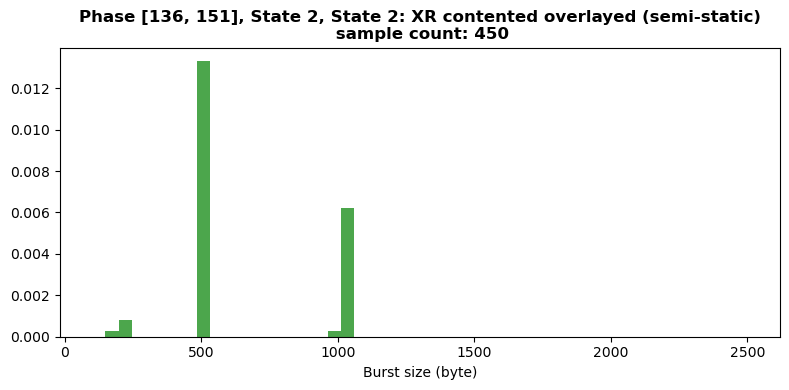

525


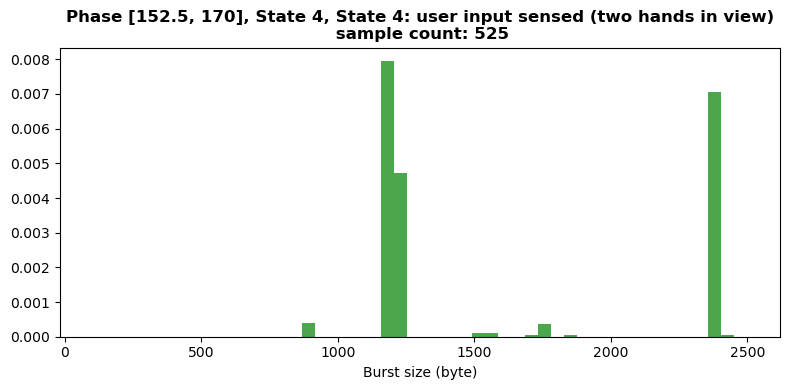

330


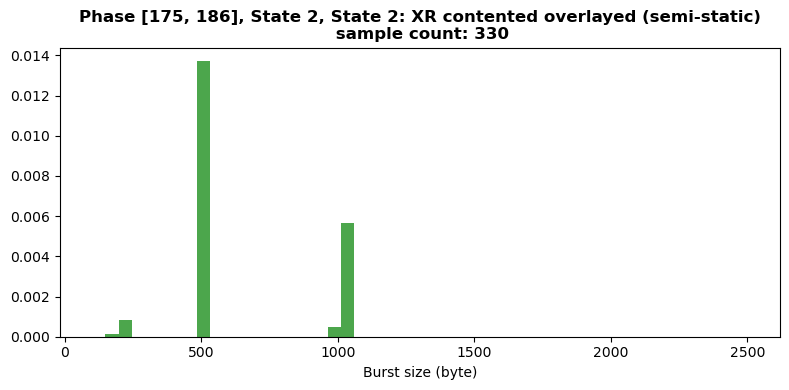

300


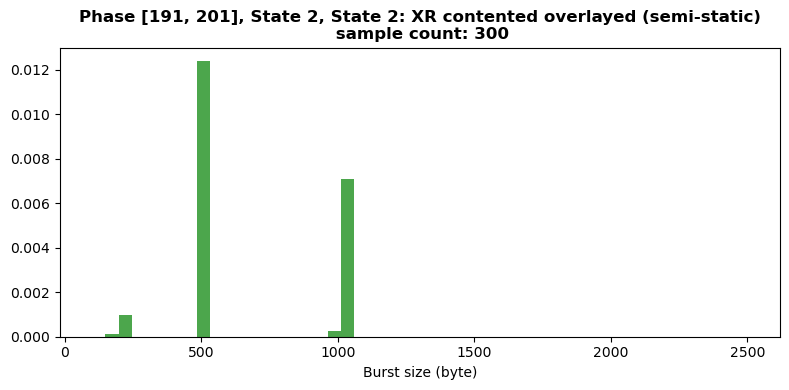

570


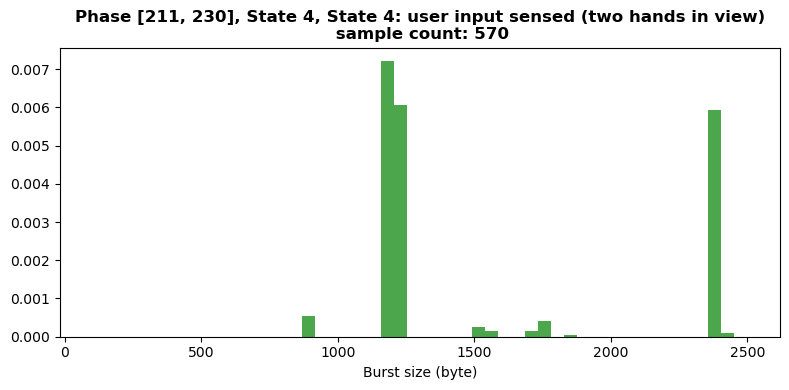

450


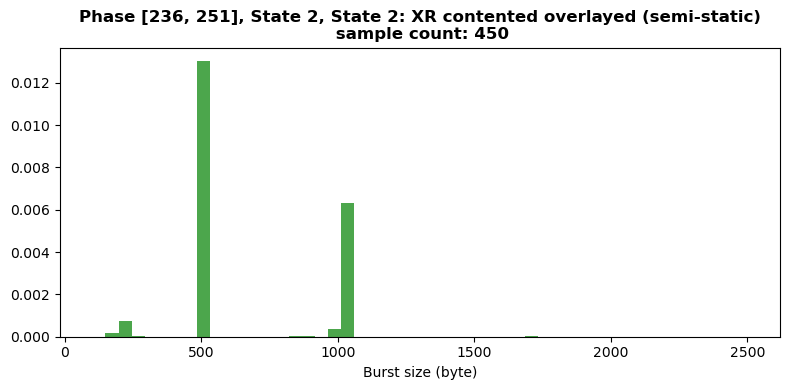

120


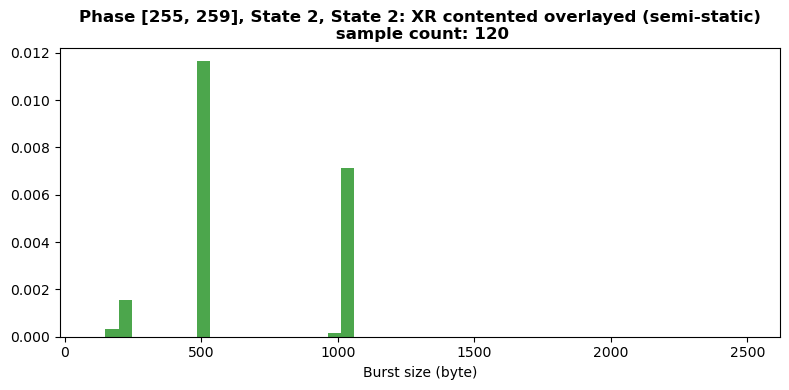

300


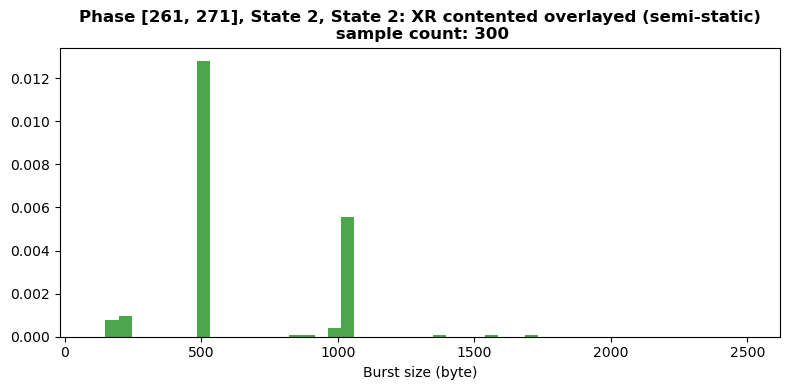

510


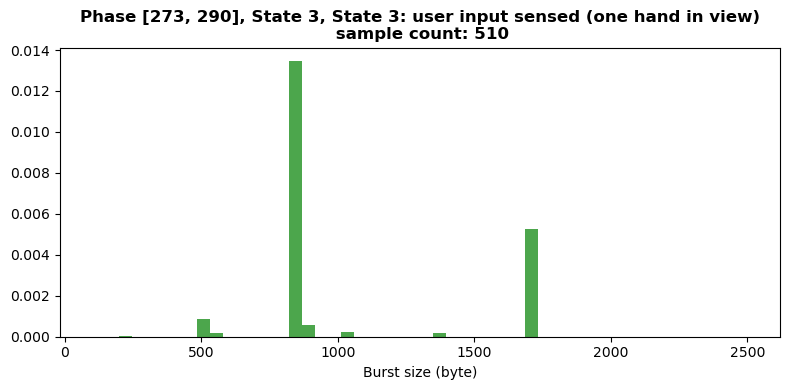

1171


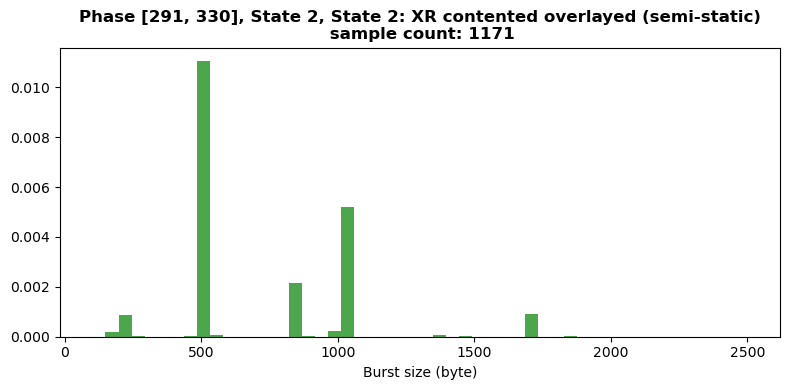

3602


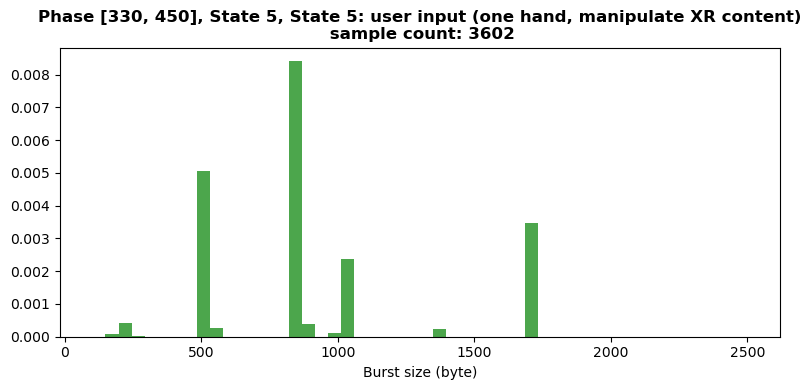

900


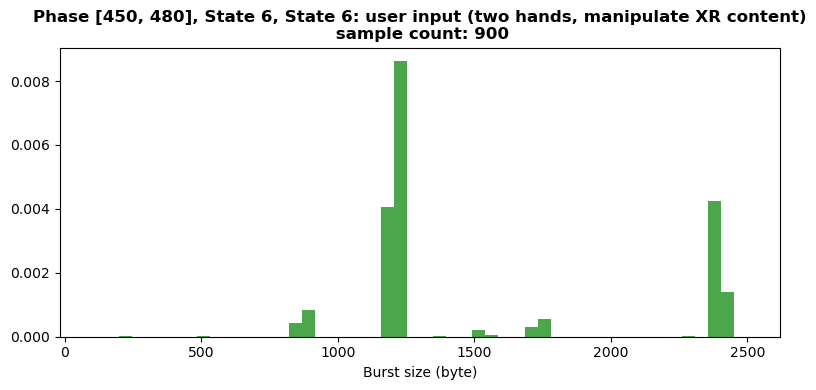

1740


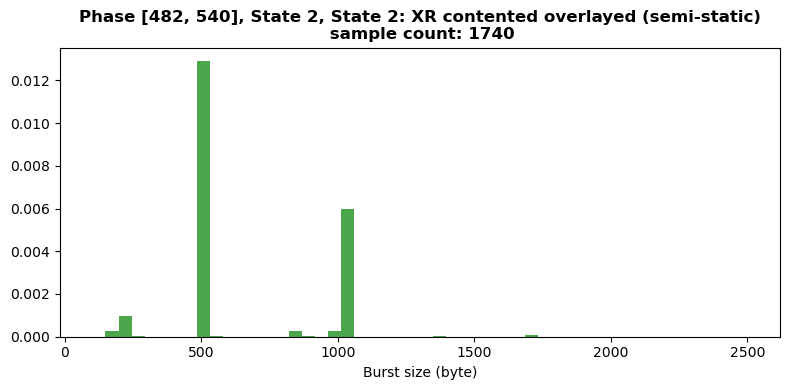

901


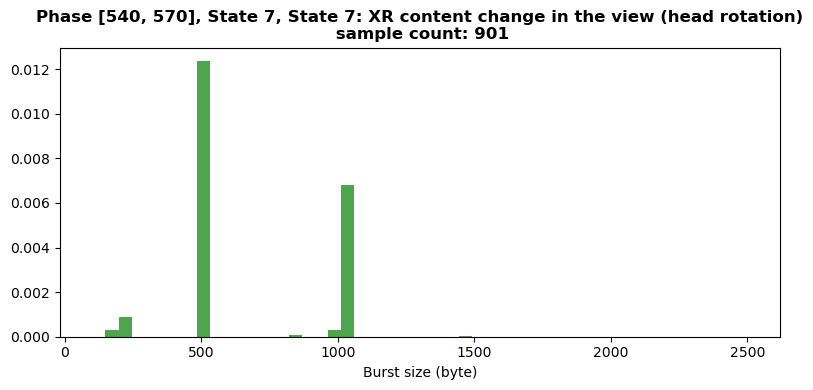

901


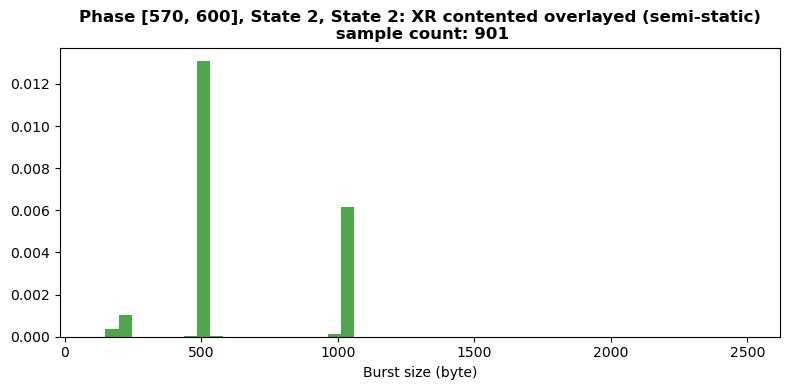

1802


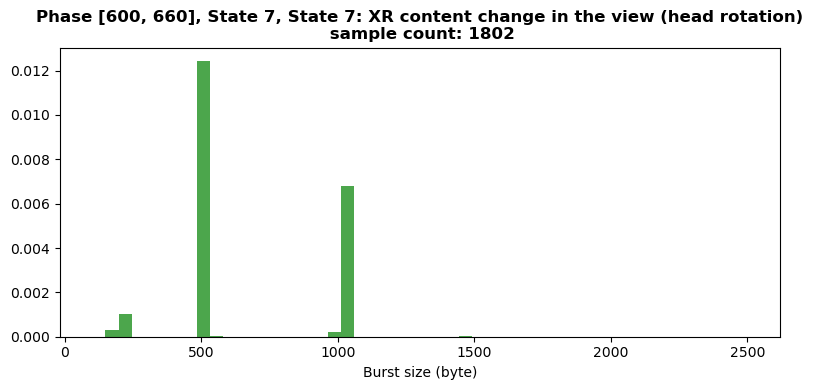

600


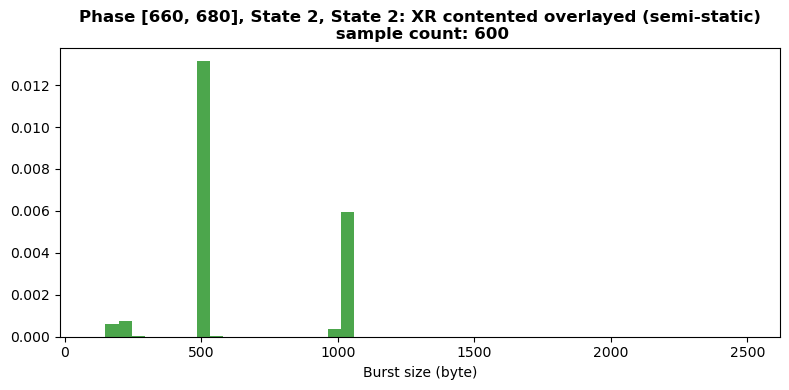

In [29]:
# Burst analysis (Version 2, phase wise)


for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    ana_mat_burst_state_phased = []
    
    for j in ana_mat_burst_stat:
        if j[burst_mat_cols["burst.time"]] > phase_end_time:
            break
        if j[burst_mat_cols["burst.time"]] > phase_start_time:
            ana_mat_burst_state_phased.append(j.copy())

    ## Head size
    lst_burst_size = [sum(i[burst_mat_cols["frame.size.lst"]]) for i in ana_mat_burst_state_phased]
    
#     lst_head_size = [ana_mat_burst_state_phased[i][burst_mat_cols["head.size"]] \
#                      for i in range(len(ana_mat_burst_state_phased)) \
#                     if ana_mat_burst_state_phased[i][burst_mat_cols["head.size"]]>0 and \
#                     ana_mat_burst_state_phased[i][burst_mat_cols["head.size"]]<2000 ]

    print(len(lst_burst_size))

    fig, ax = plt.subplots(figsize=(8, 4))

    num_bins = 50

    ## Plot the histogram of the i-th tags in segments

    # x_seq = [i for i in tag_lists[0] if i > 16000]
    # x_seq = [i for i in tag_lists[1] if i > 16000]
    # x_seq = [i for i in tag_lists[2] if i > 16000]
    # x_seq = [i for i in tag_lists[4] if i > 16000]
    #x_seq = [i for i in tag_lists[3]]
    # x_seq = [i for i in tag_lists[2]]        
    # print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


    # plot the histogram
    n, bins, patches = ax.hist(lst_burst_size, num_bins, 
                               range=[100, 2500],
                                density = 1,
                                color ='green',
                                alpha = 0.7)

    # plot the cumulative histogram
    # n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
    #                            cumulative=True, label='Empirical')


    plt.xlabel('Burst size (byte)')
    # plt.ylabel('Y-Axis')

    title_print = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
                                                                           phase_state, phase_state_term, \
                                                                          len(lst_burst_size))

#     title_print = "Total count: "+ str(len(lst_head_size))

    plt.title(title_print,
              fontweight = "bold")

    plt.show()




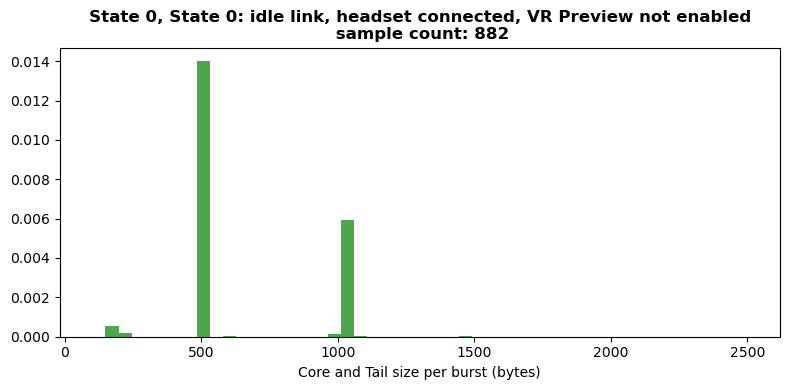

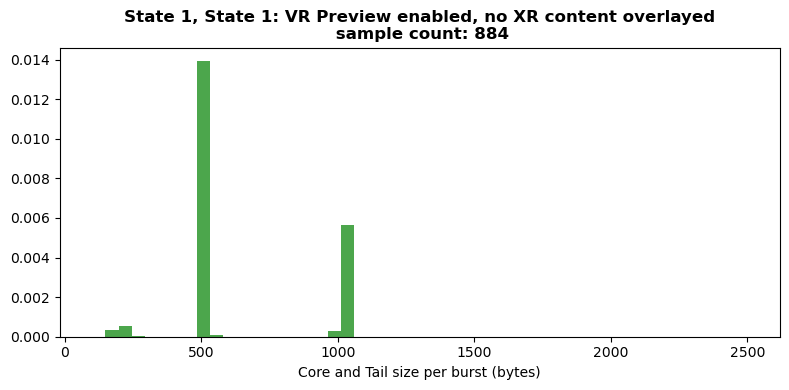

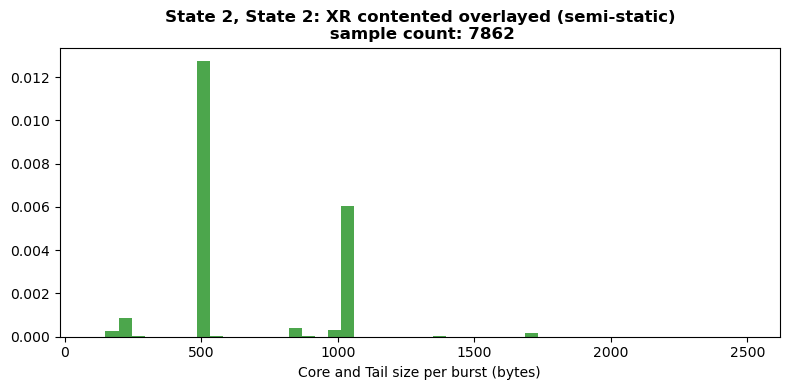

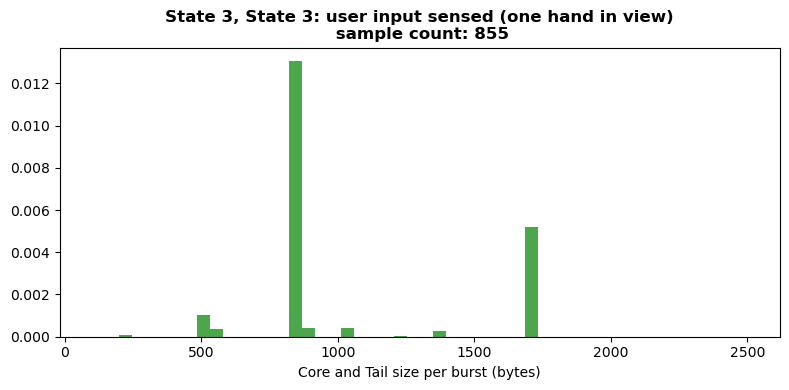

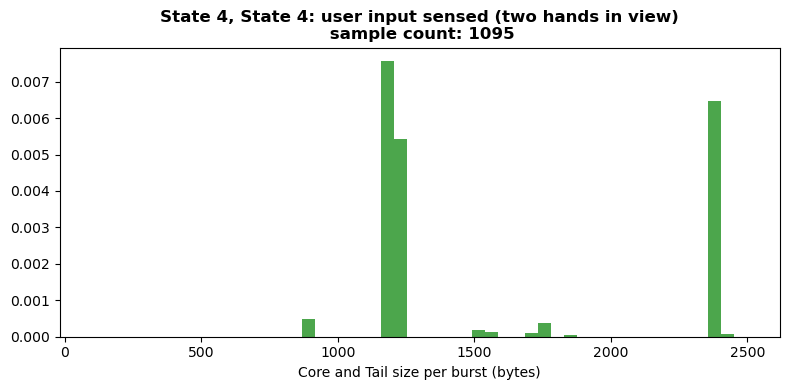

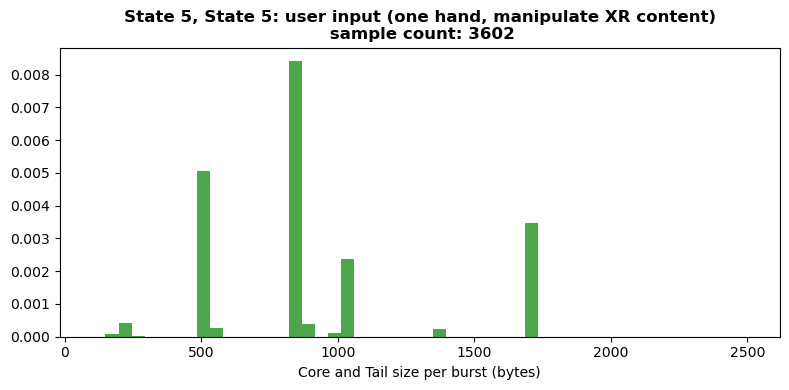

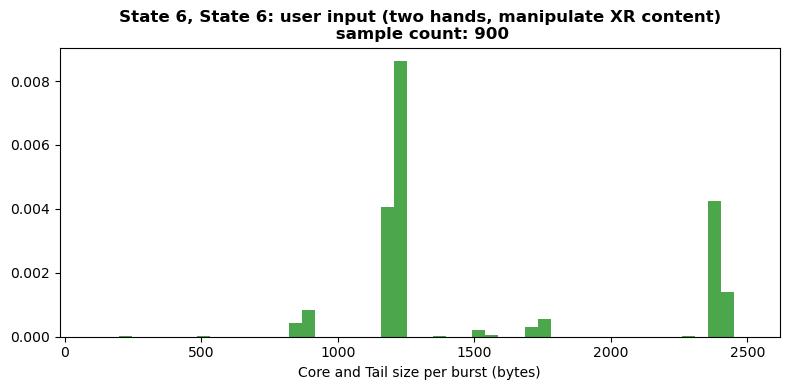

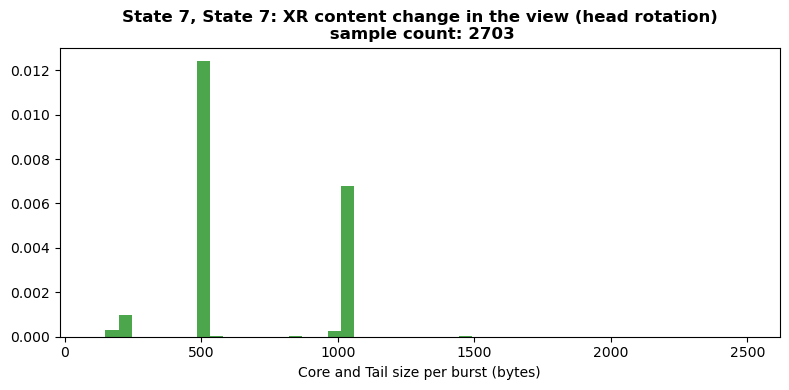

In [30]:
# Core + Tail size (Version 3, state-phase wise)

list_of_lst_burst_size = [[] for i in dict_op_state_def]
list_of_lst_burst_time = [[] for i in dict_op_state_def]

for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    ana_mat_burst_state_phased = []
    
    for j in ana_mat_burst_stat:
        if j[burst_mat_cols["burst.time"]] > phase_end_time:
            break
        if j[burst_mat_cols["burst.time"]] > phase_start_time:
            ana_mat_burst_state_phased.append(j.copy())

            
#     lst_burst_size = []
#     lst_burst_size = [sum(i[burst_mat_cols["frame.size.lst"]]) for i in ana_mat_burst_state_phased]
    for i in ana_mat_burst_state_phased:
        list_of_lst_burst_size[phase_state].append(sum(i[burst_mat_cols["frame.size.lst"]]))
        list_of_lst_burst_time[phase_state].append(i[burst_mat_cols["burst.time"]])
        
        
for phase_state in range(len(dict_op_state_def)):
    phase_state_term = dict_op_state_def[phase_state]

    fig, ax = plt.subplots(figsize=(8, 4))

    num_bins = 50


    # plot the histogram
    n, bins, patches = ax.hist(list_of_lst_burst_size[phase_state], num_bins, 
                               range=[100, 2500],
                                density = 1,
                                color ='green',
                                alpha = 0.7)

    #plot the cumulative histogram
#     n, bins, patches = ax.hist(list_of_lst_burst_size[phase_state], num_bins, density=True, histtype='step',
#                                cumulative=True, label='Empirical')


    plt.xlabel('Core and Tail size per burst (bytes)')
    # plt.ylabel('Y-Axis')

    title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
                                                                          len(list_of_lst_burst_size[phase_state]))

    plt.title(title_print,
              fontweight = "bold")

    plt.show()

<Figure size 1200x800 with 0 Axes>

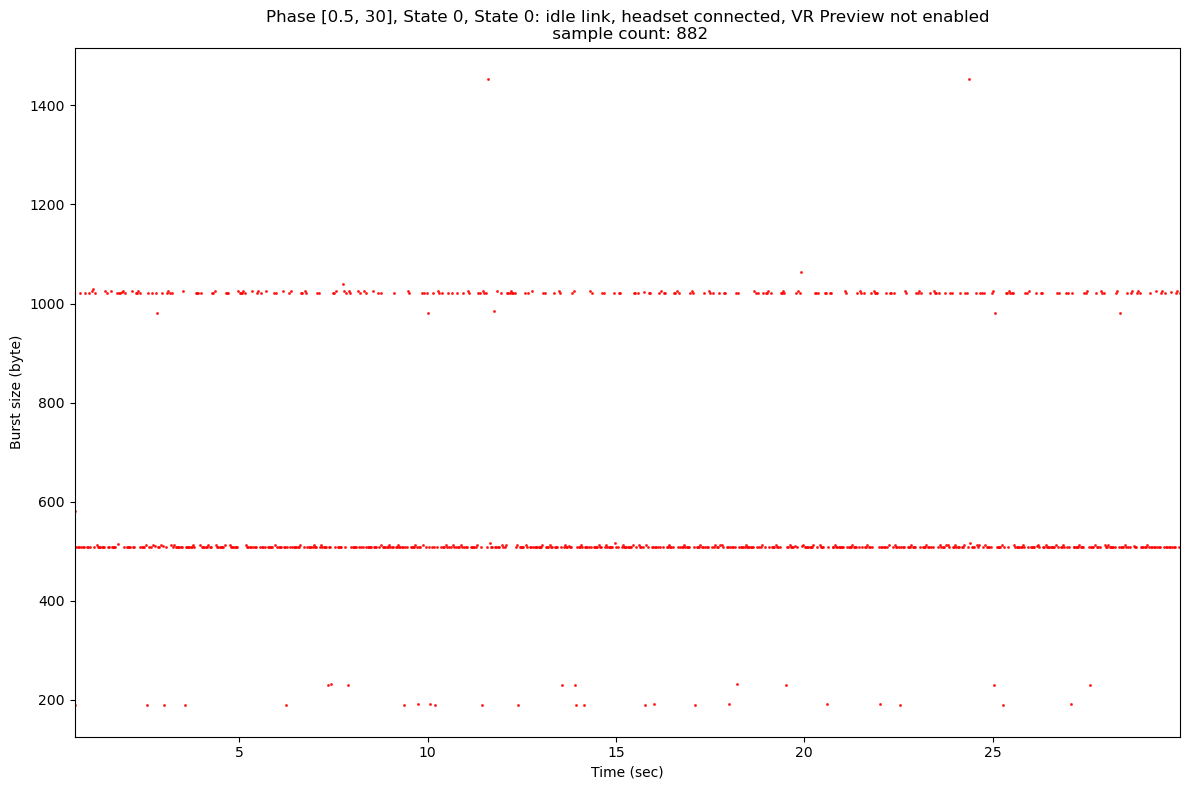

<Figure size 1200x800 with 0 Axes>

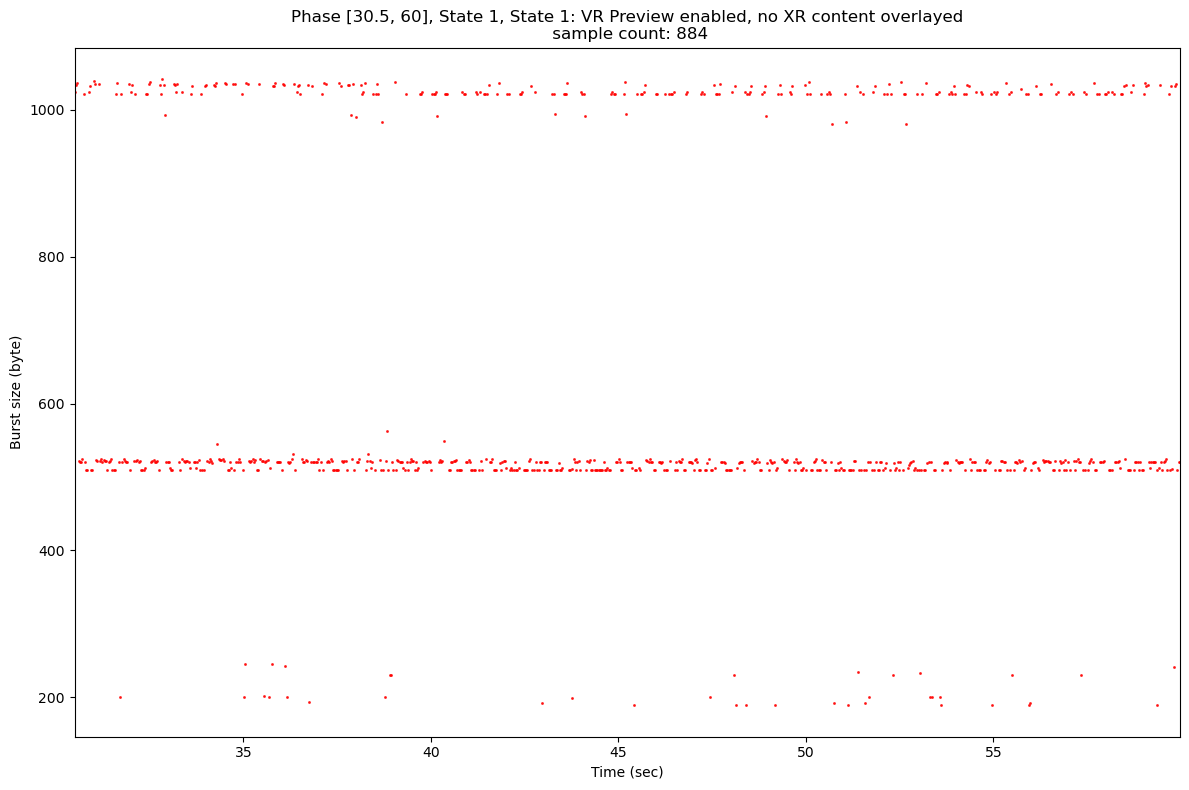

<Figure size 1200x800 with 0 Axes>

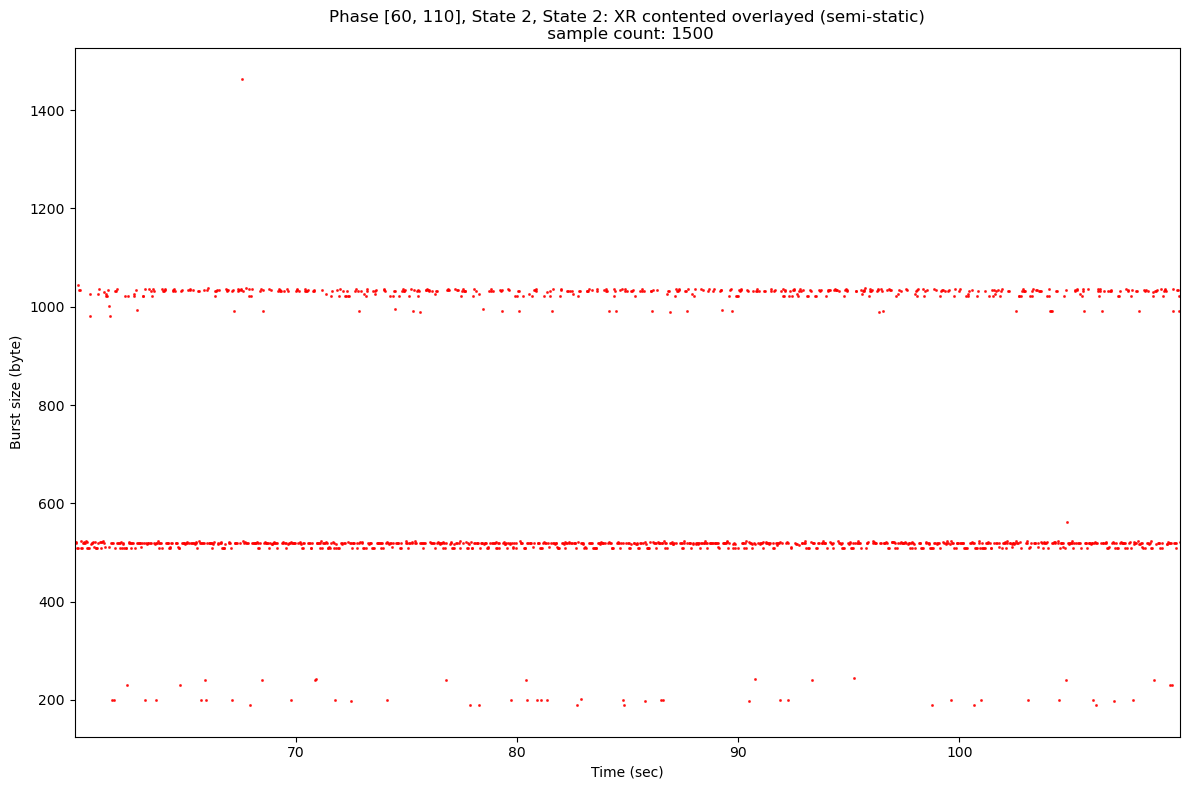

<Figure size 1200x800 with 0 Axes>

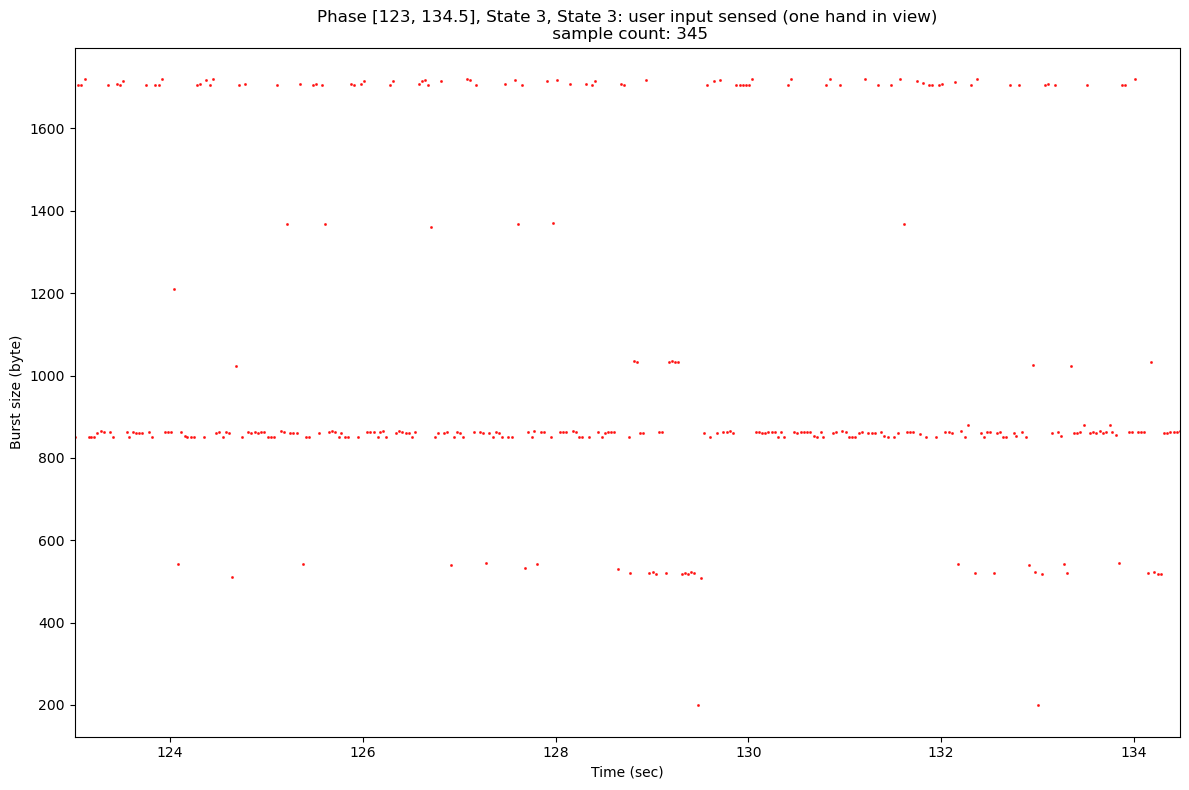

<Figure size 1200x800 with 0 Axes>

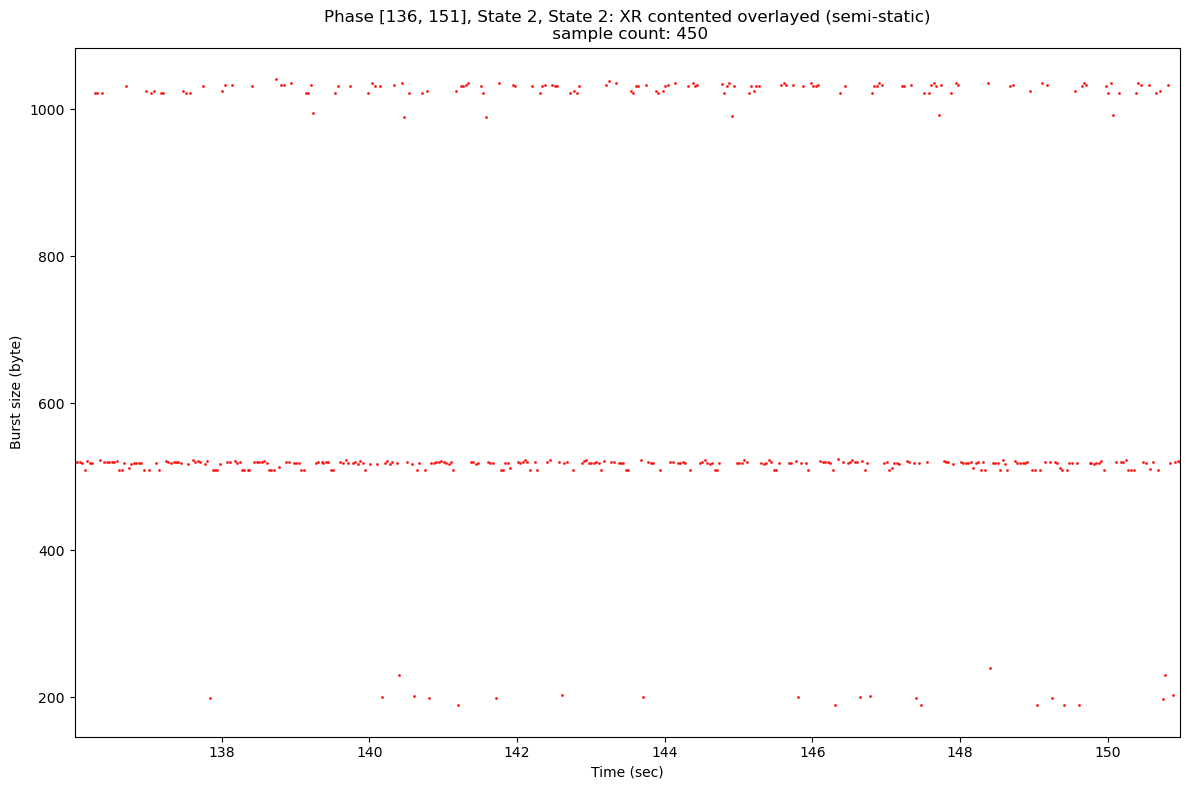

<Figure size 1200x800 with 0 Axes>

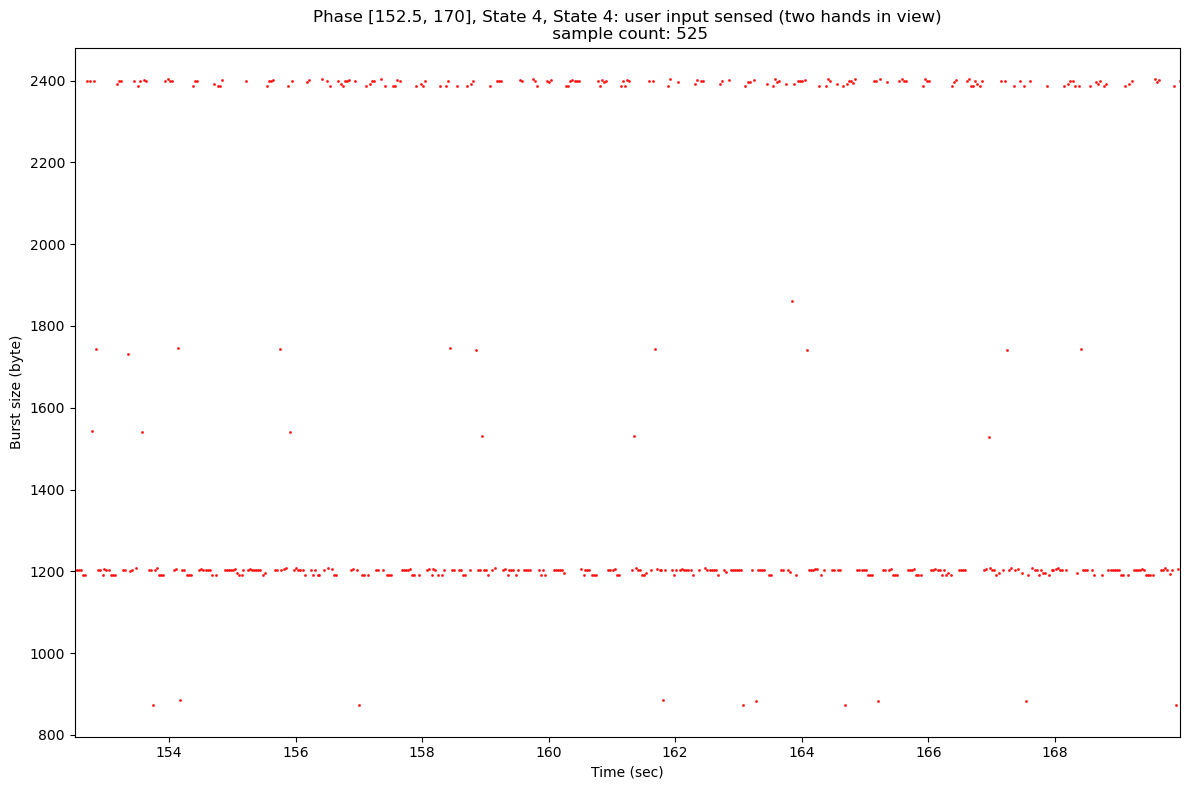

<Figure size 1200x800 with 0 Axes>

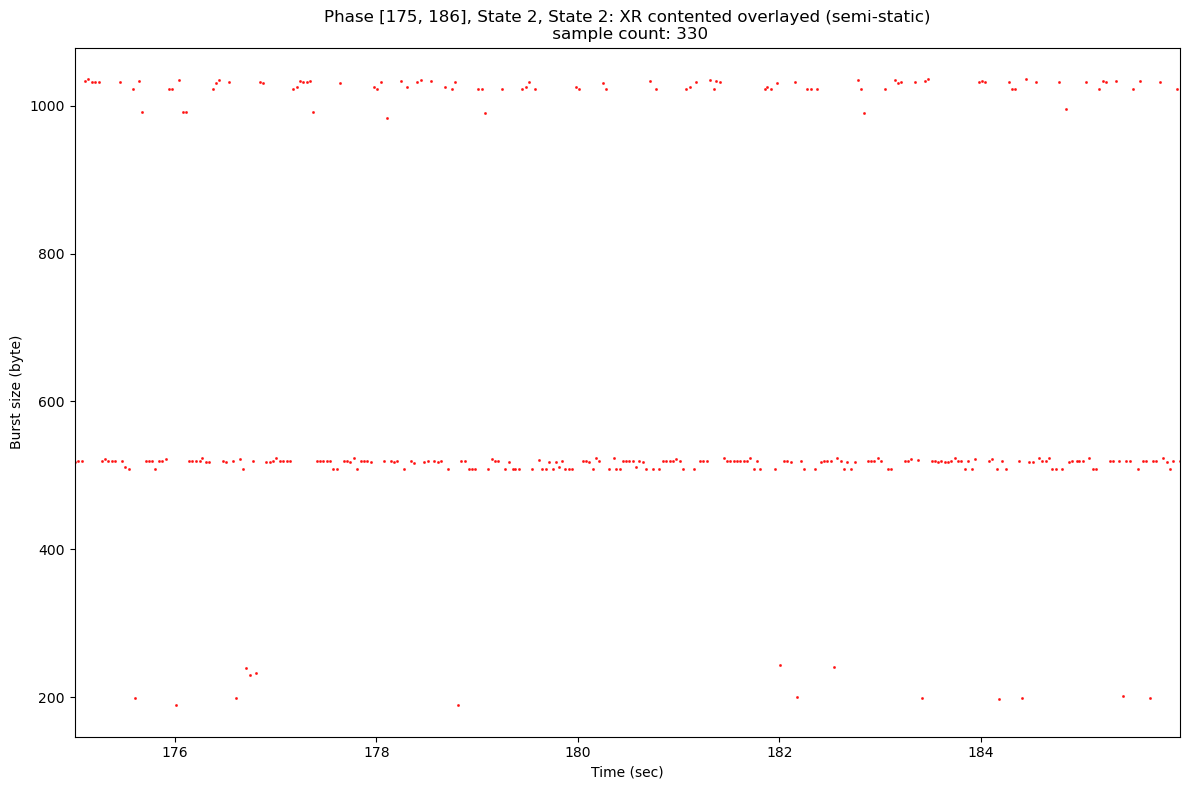

<Figure size 1200x800 with 0 Axes>

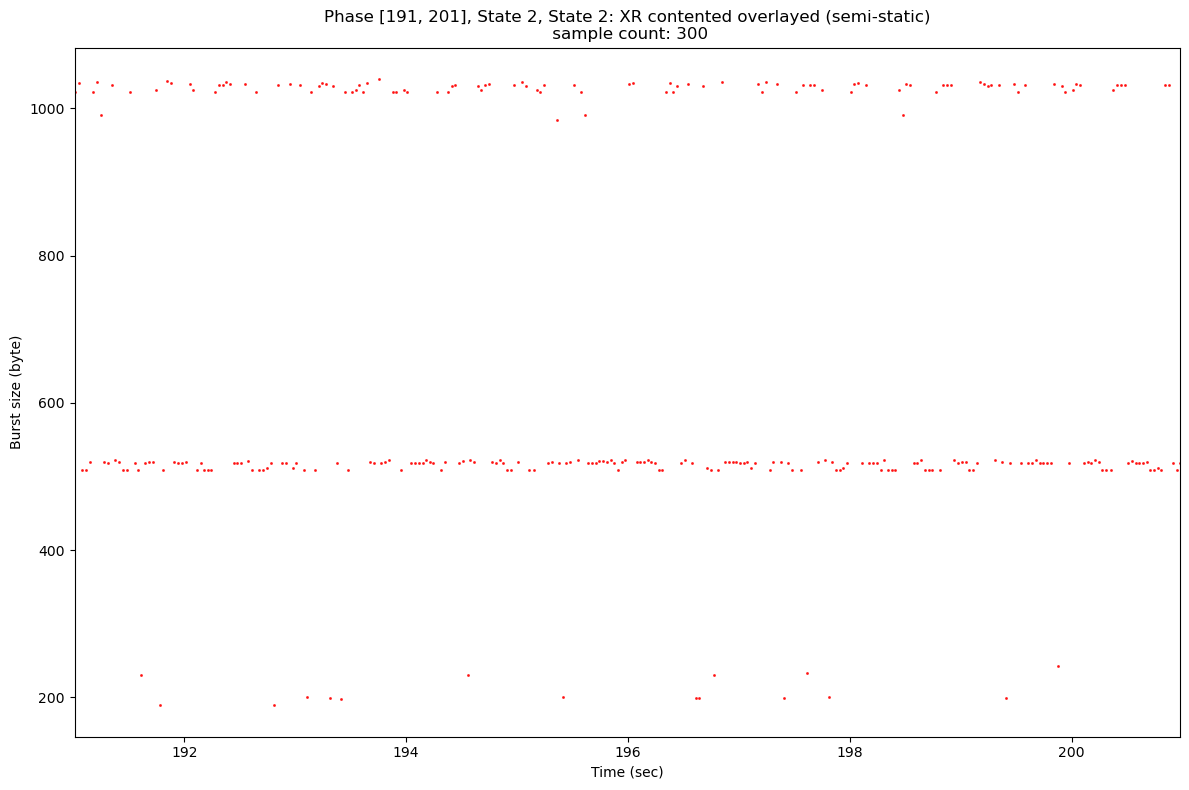

<Figure size 1200x800 with 0 Axes>

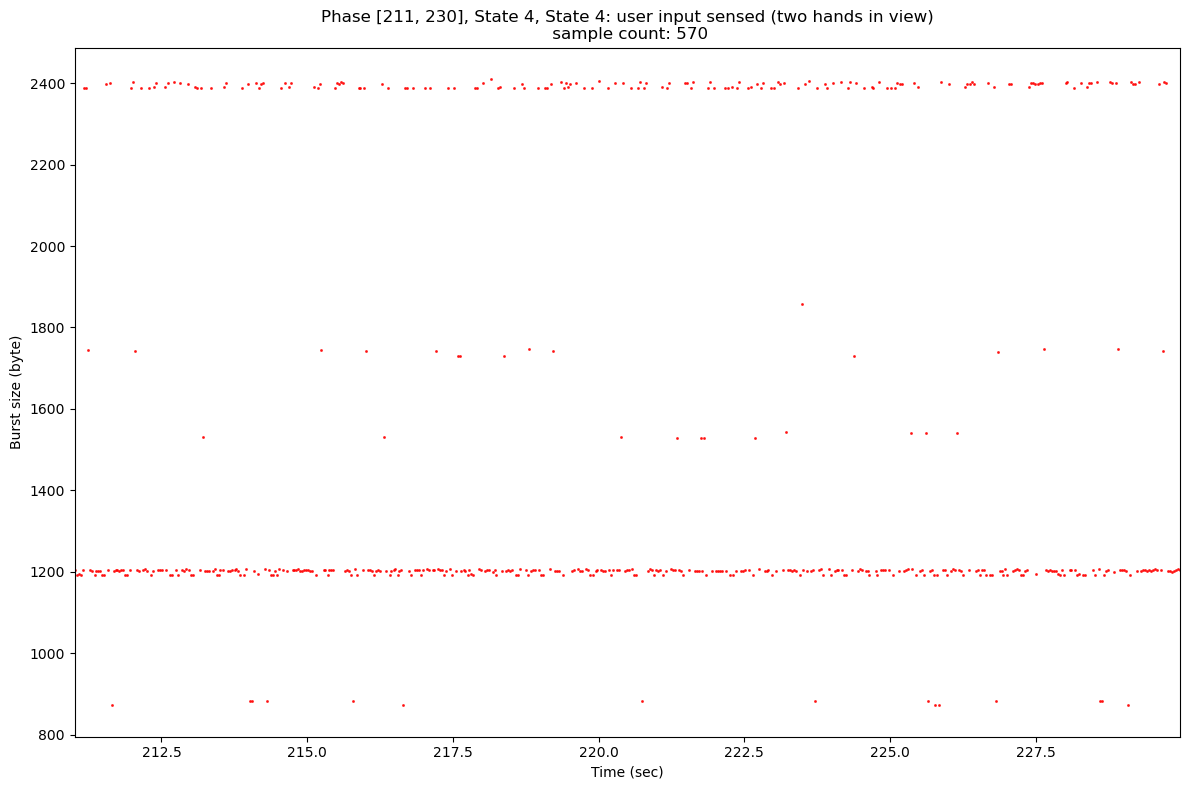

<Figure size 1200x800 with 0 Axes>

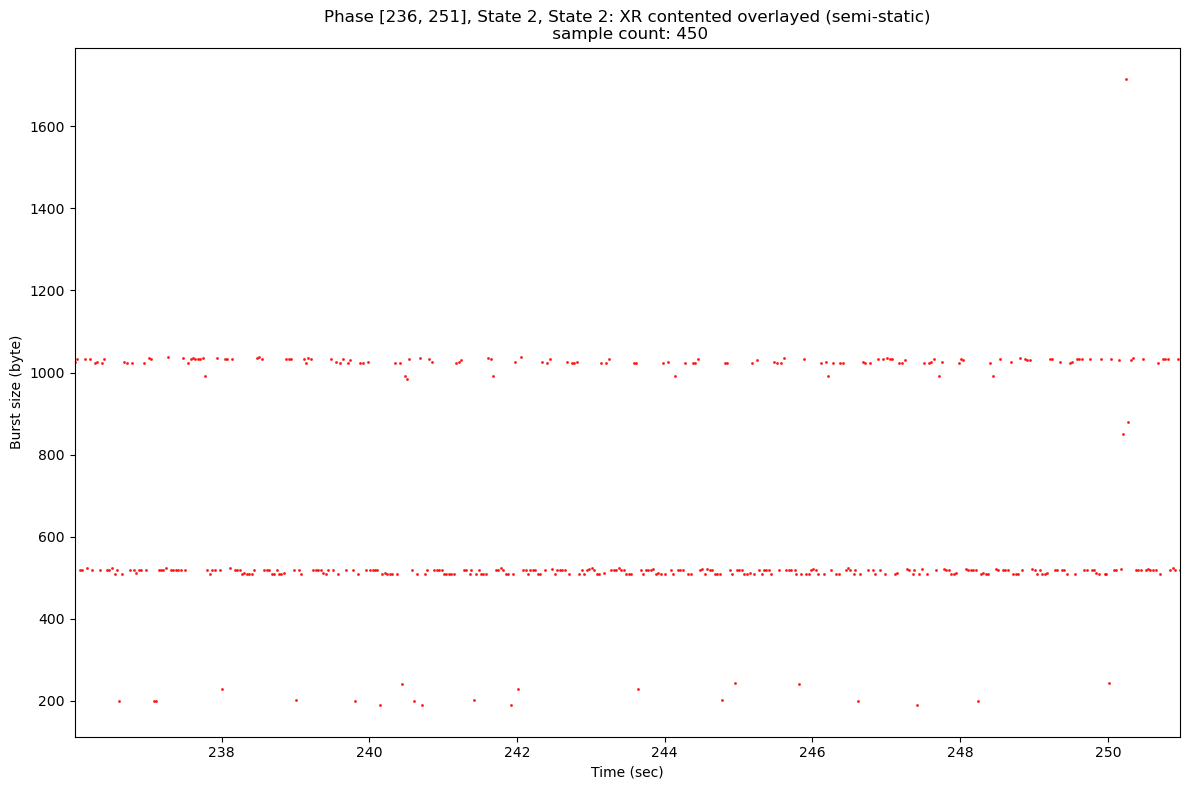

<Figure size 1200x800 with 0 Axes>

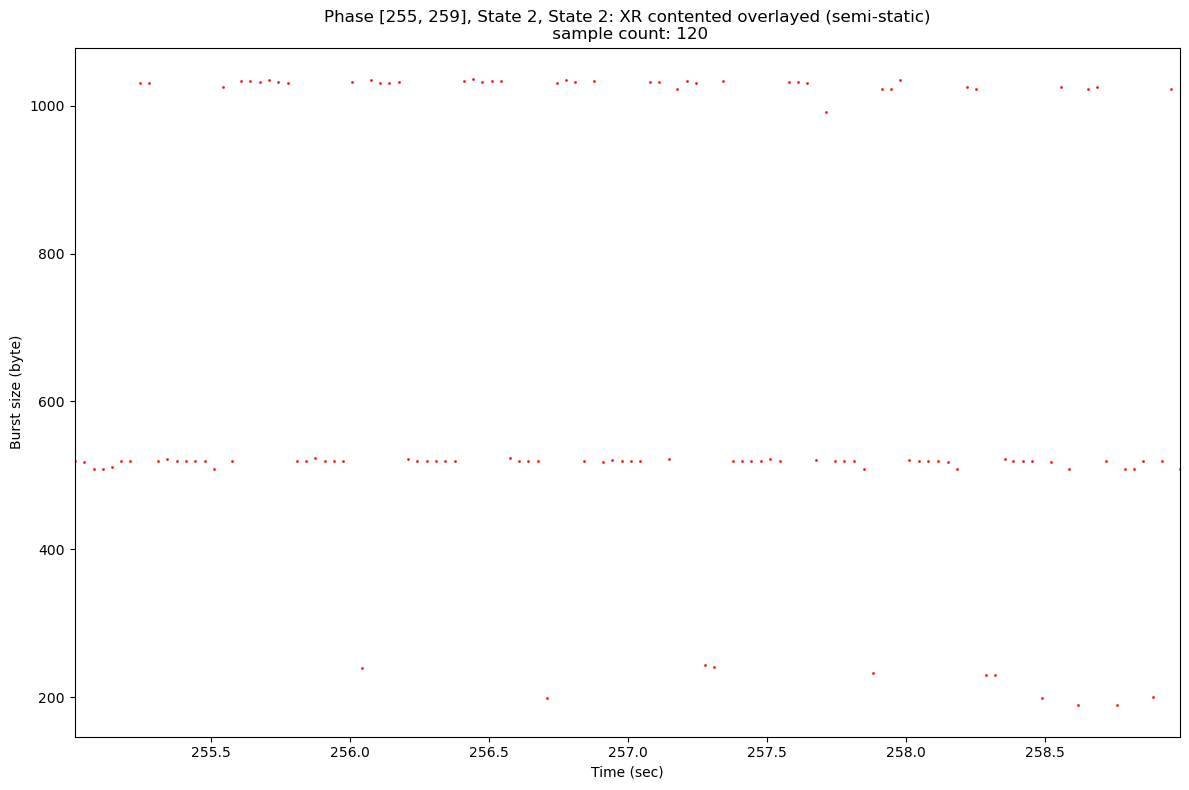

<Figure size 1200x800 with 0 Axes>

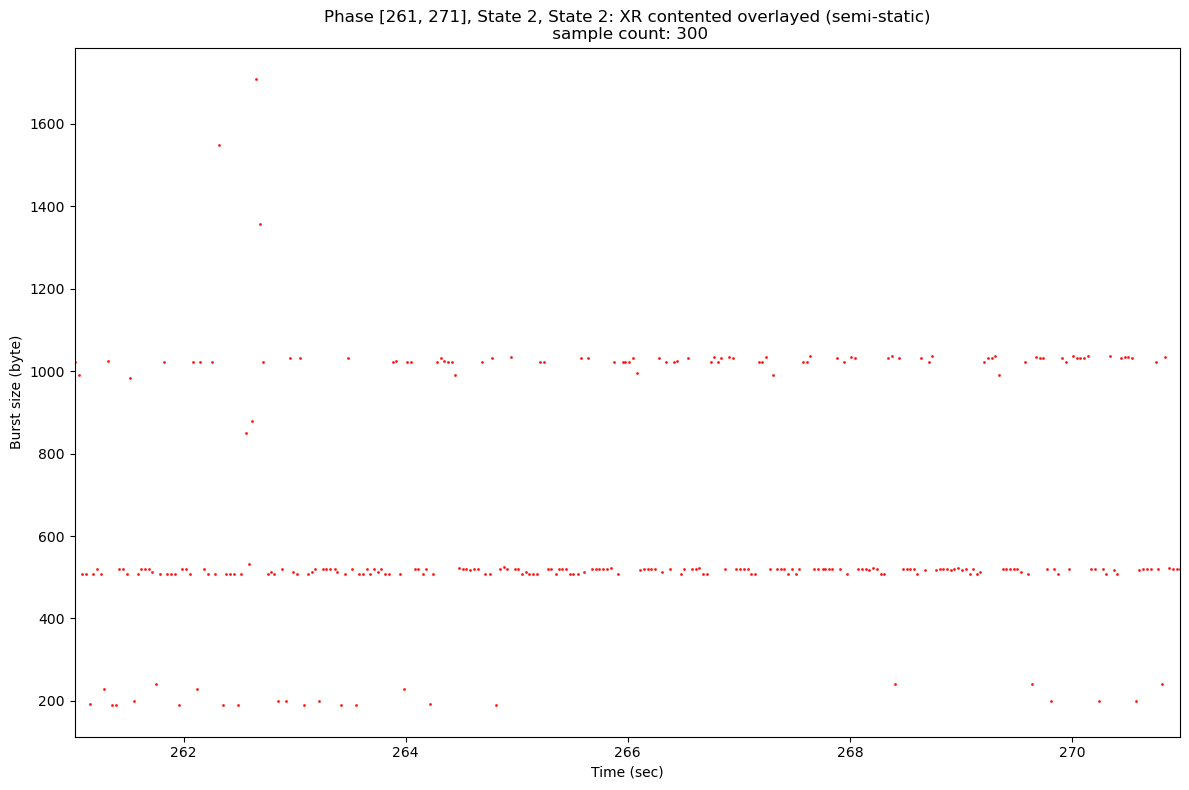

<Figure size 1200x800 with 0 Axes>

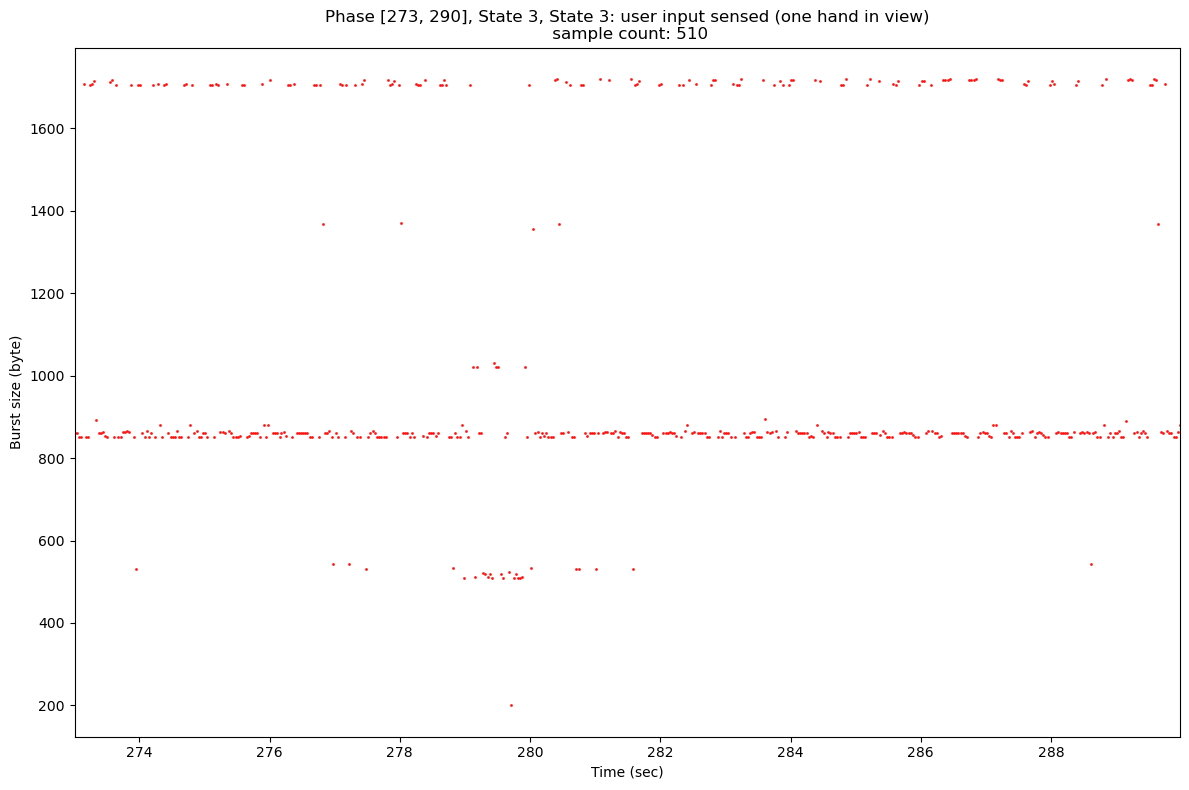

<Figure size 1200x800 with 0 Axes>

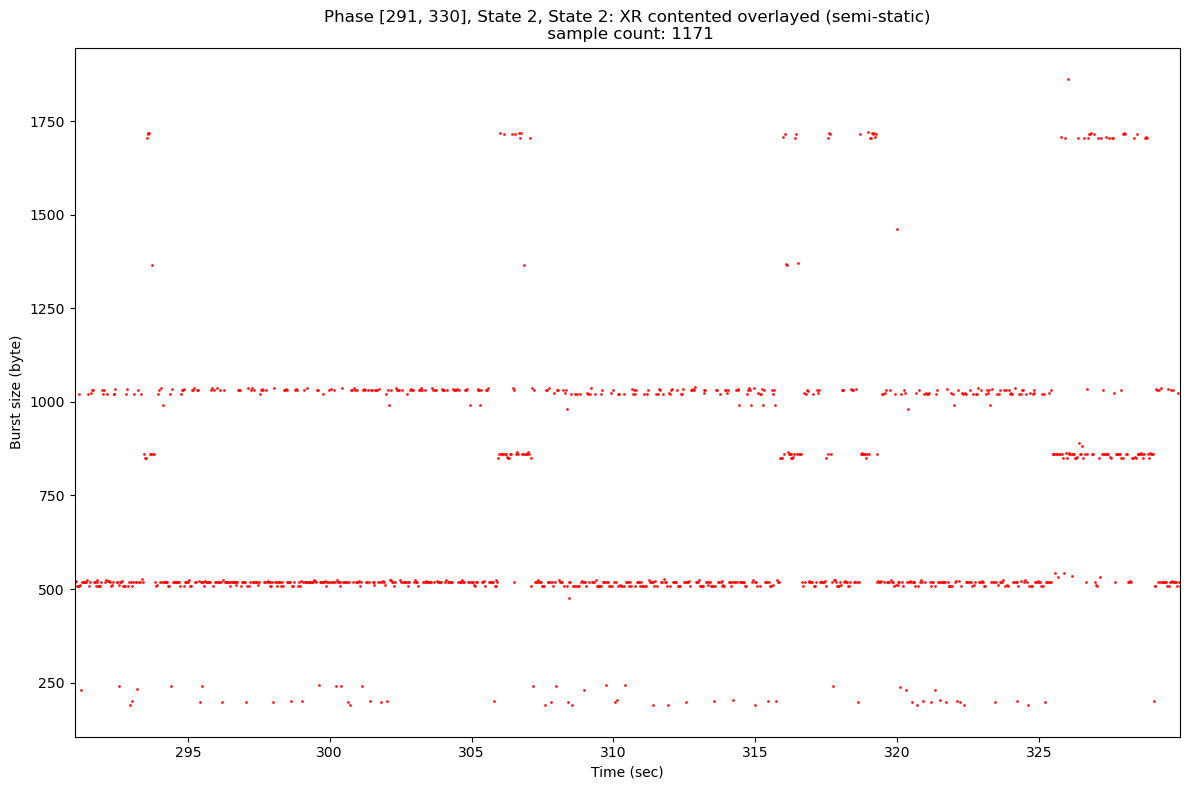

<Figure size 1200x800 with 0 Axes>

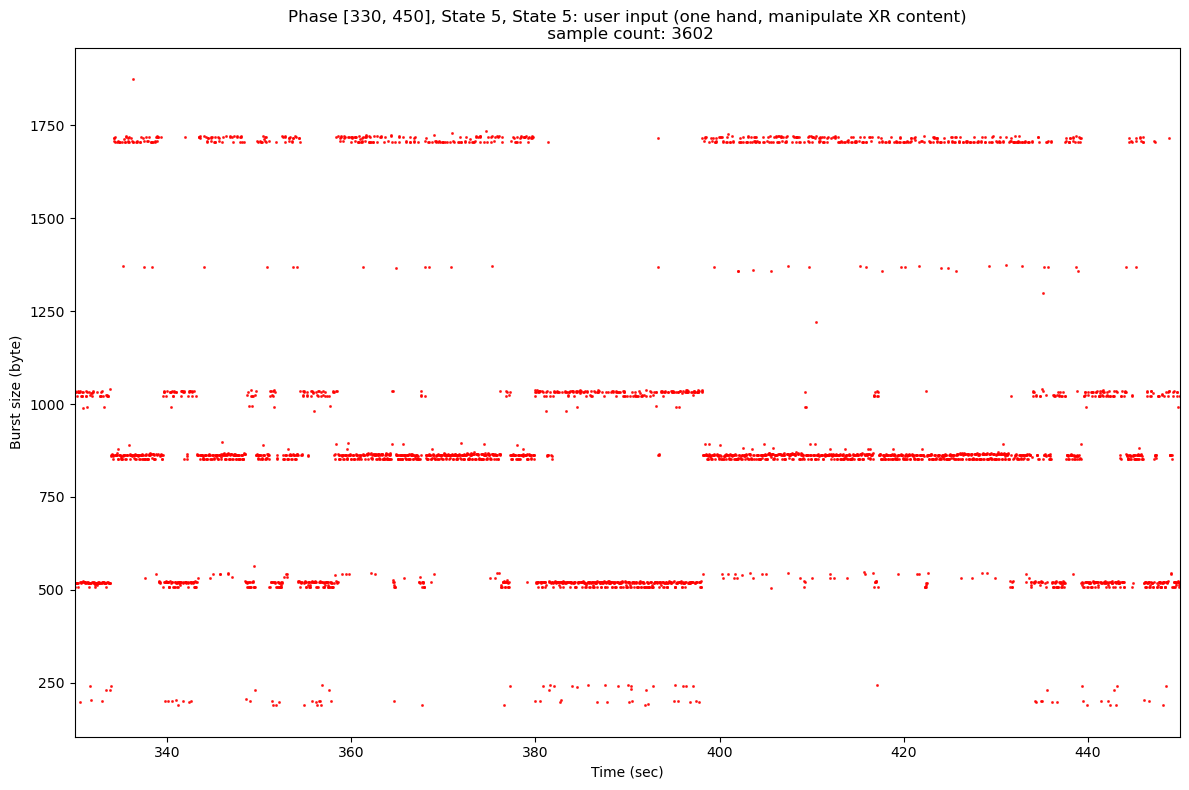

<Figure size 1200x800 with 0 Axes>

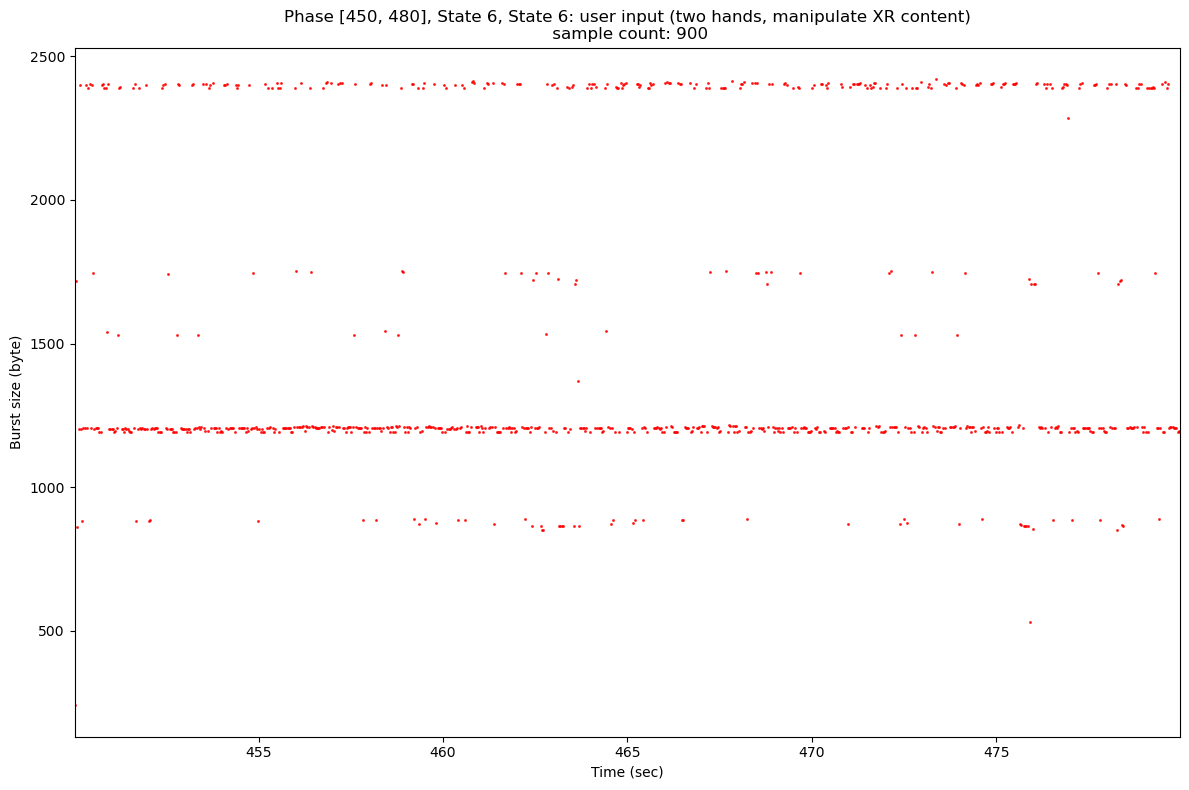

<Figure size 1200x800 with 0 Axes>

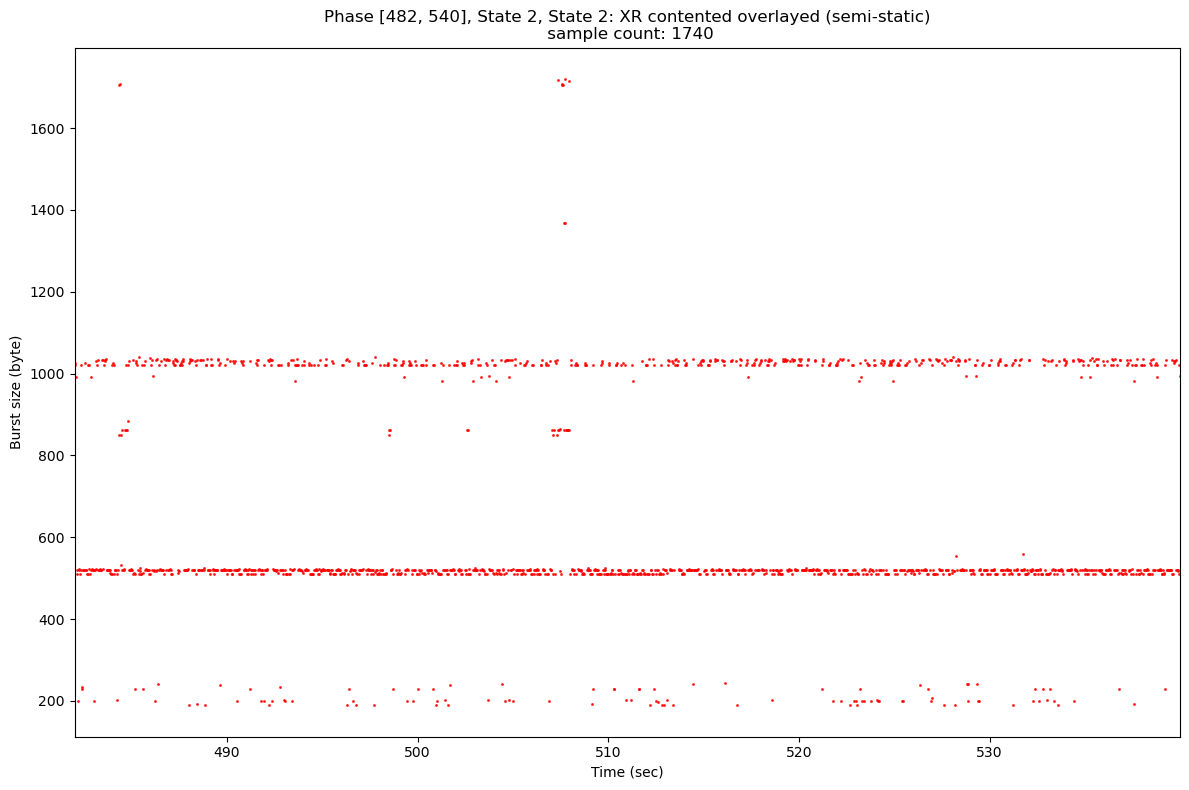

<Figure size 1200x800 with 0 Axes>

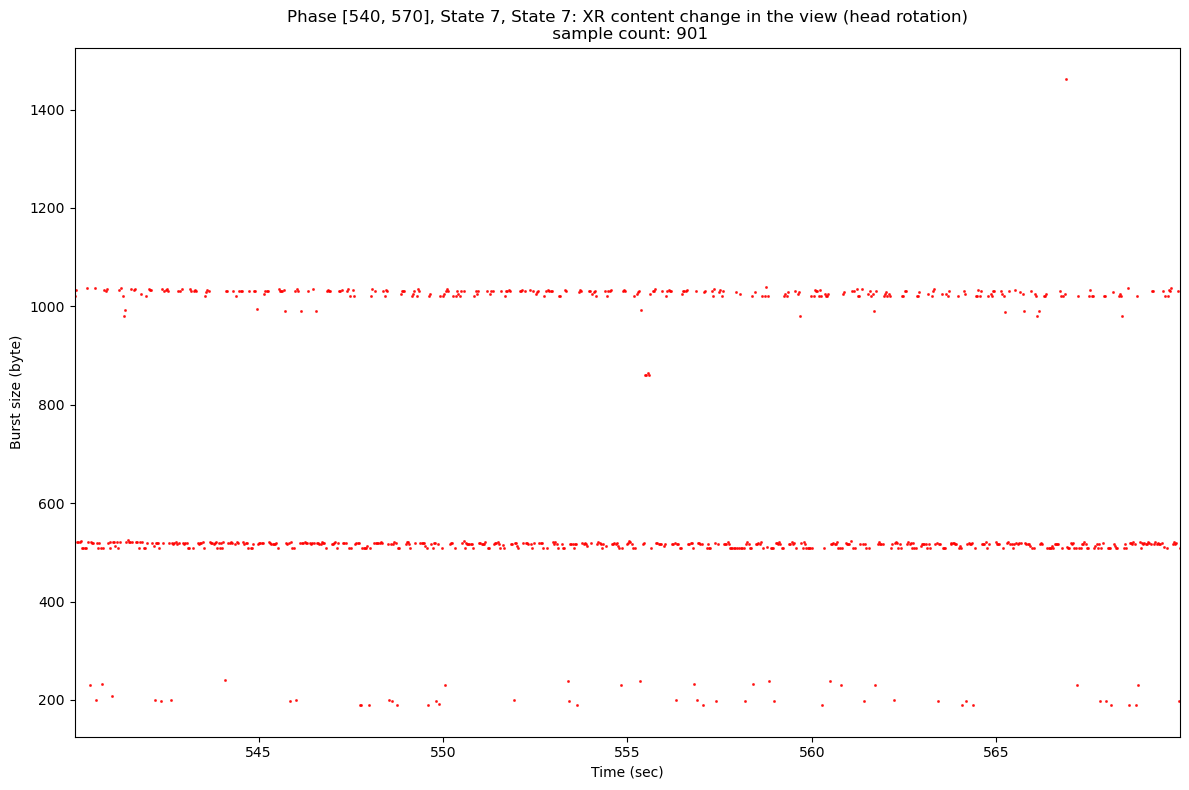

<Figure size 1200x800 with 0 Axes>

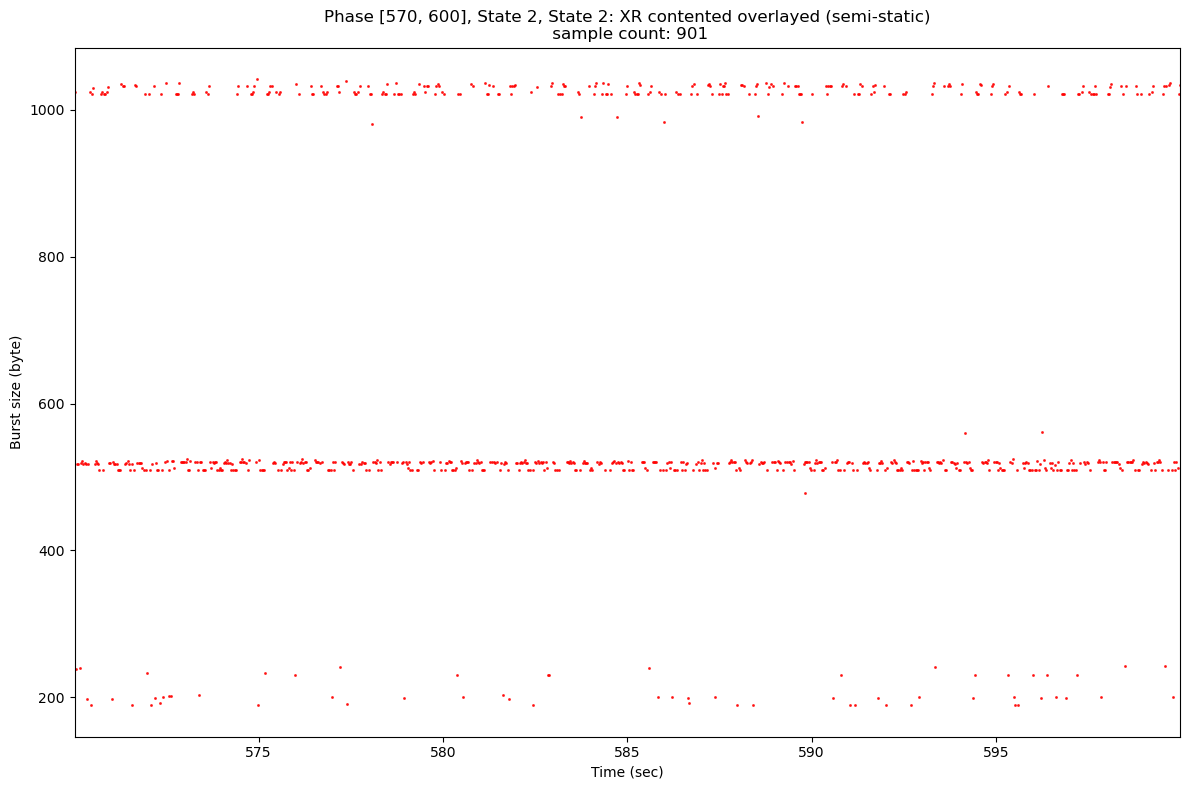

<Figure size 1200x800 with 0 Axes>

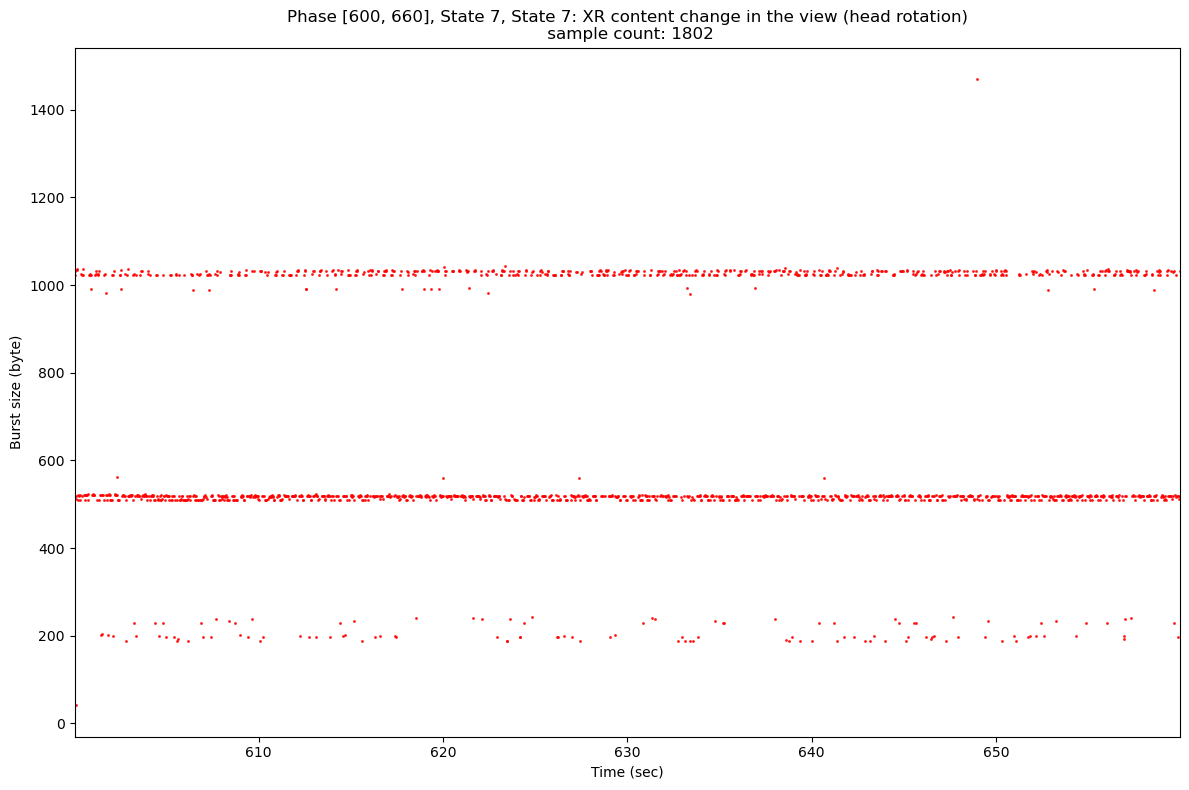

<Figure size 1200x800 with 0 Axes>

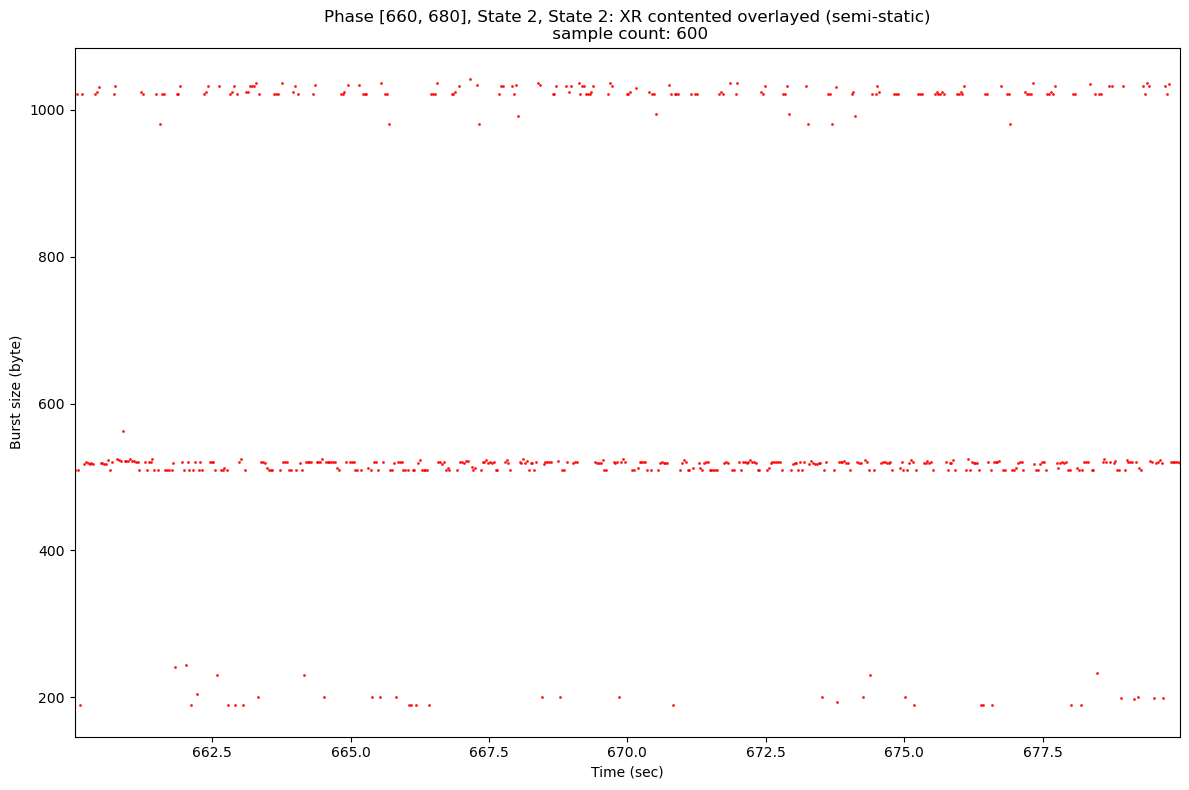

In [31]:
# Core + Tail size (Version 3, state-phase wise)
# Show variation along time per state

list_of_lst_burst_size = [[] for i in dict_op_state_def]
list_of_lst_burst_time = [[] for i in dict_op_state_def]

for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    ana_mat_burst_state_phased = []
    
    for j in ana_mat_burst_stat:
        if j[burst_mat_cols["burst.time"]] > phase_end_time:
            break
        if j[burst_mat_cols["burst.time"]] > phase_start_time:
            ana_mat_burst_state_phased.append(j.copy())

            
#     lst_burst_size = []
    lst_burst_size = [sum(i[burst_mat_cols["frame.size.lst"]]) for i in ana_mat_burst_state_phased]
    lst_burst_time = [i[burst_mat_cols["burst.time"]] for i in ana_mat_burst_state_phased]
    
    
    # Populated for the next step per-state analysis
    for i in ana_mat_burst_state_phased:
        list_of_lst_burst_size[phase_state].append(sum(i[burst_mat_cols["frame.size.lst"]]))
        list_of_lst_burst_time[phase_state].append(i[burst_mat_cols["burst.time"]])
        


    title_print = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
                                                                           phase_state, phase_state_term, \
                                                                          len(lst_burst_size))
    x_min_display = min(lst_burst_time)
    x_max_display = max(lst_burst_time)#pcap_end_time
    scatterplot(lst_burst_time, lst_burst_size, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Burst size (byte)", title=title_print, figSave=False, fig_index="")

    plt.show()



In [32]:
# Burst property exploration (Version 3, state-phase wise)

list_of_lst_burst_time = [[] for i in dict_op_state_def]
list_of_lst_burst_size = [[] for i in dict_op_state_def]

list_of_lst_burst_frame_count = [[] for i in dict_op_state_def]

list_of_lst_burst_tap_time = [[] for i in dict_op_state_def]
list_of_lst_burst_tap_sizes = [[] for i in dict_op_state_def]


for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    ana_mat_burst_state_phased = []
    
    for j in ana_mat_burst_stat:
        if j[burst_mat_cols["burst.time"]] > phase_end_time:
            break
        if j[burst_mat_cols["burst.time"]] > phase_start_time:
            ana_mat_burst_state_phased.append(j.copy())
    
    
    # Populated for the next step per-state analysis
    for i in ana_mat_burst_state_phased:
        list_of_lst_burst_size[phase_state].append(sum(i[burst_mat_cols["frame.size.lst"]]))
        list_of_lst_burst_time[phase_state].append(i[burst_mat_cols["burst.time"]])
        list_of_lst_burst_frame_count[phase_state].append(len(i[burst_mat_cols["frame.type.lst"]]))
        
        list_of_lst_burst_tap_time[phase_state].append(i[burst_mat_cols["frame.time.lst"]])
        list_of_lst_burst_tap_sizes[phase_state].append(i[burst_mat_cols["frame.size.lst"]])
        
        
list_of_lst_burst_tap_delays = [[] for i in dict_op_state_def]

for i in range(len(dict_op_state_def)):
    for j in list_of_lst_burst_tap_time[i]: # each j is a list of frame time in a burst at State i
        # get the intra-burst delay from tap 0, i.e., the burst start. the delay from Tap 0 from itself is 0.
        j_delay = [ j[m] - j[0] for m in range(len(j))  ]# get the list of delay
        list_of_lst_burst_tap_delays[i].append(j_delay)

882


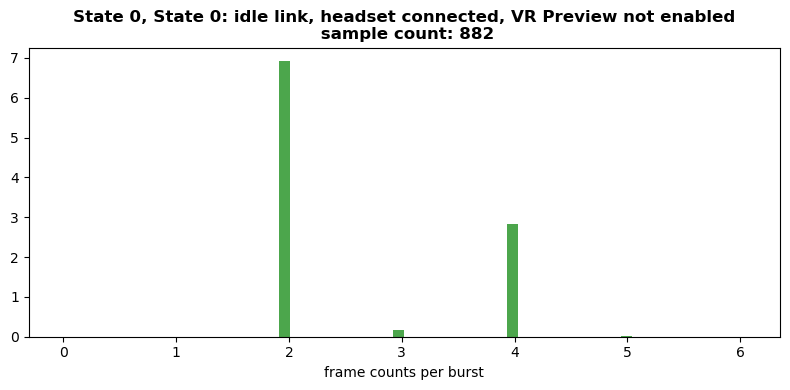

884


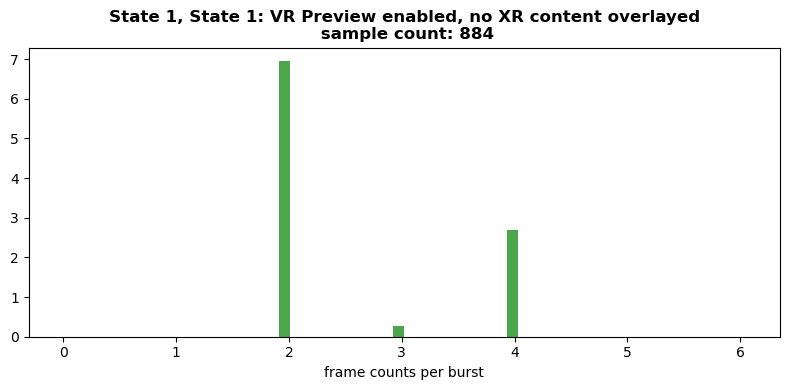

7862


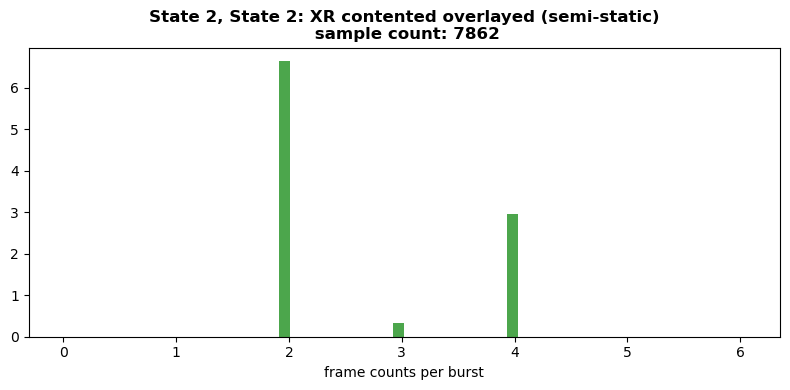

855


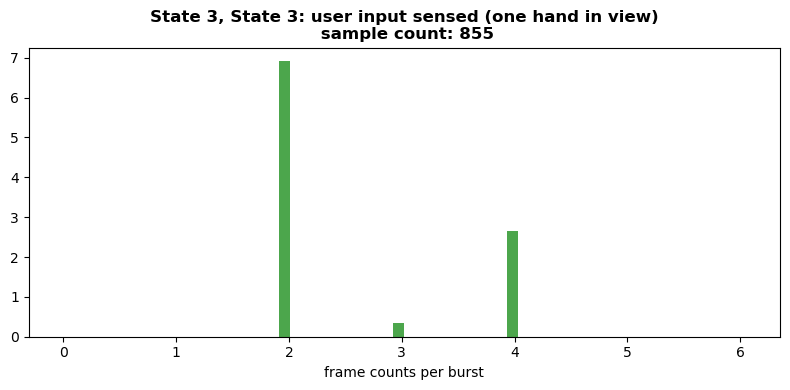

1095


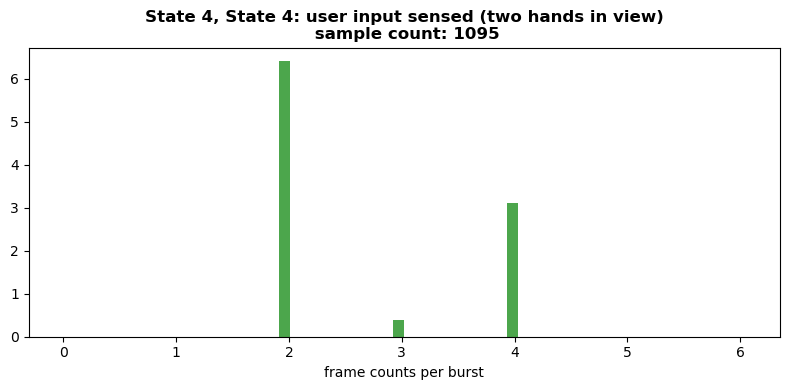

3602


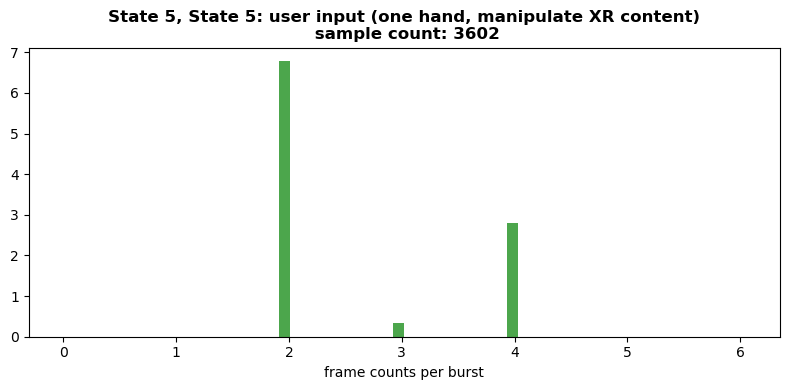

900


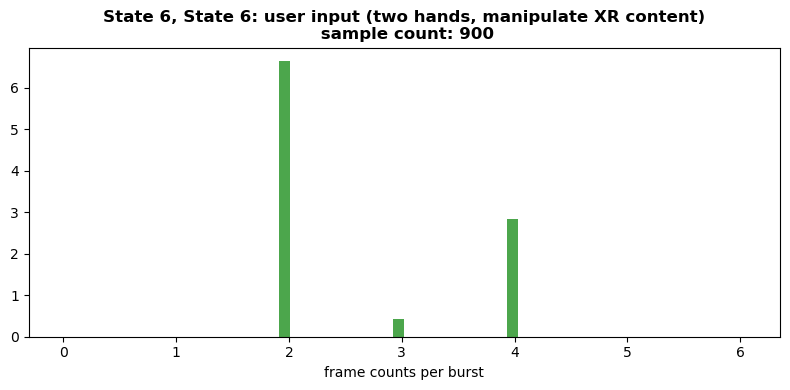

2703


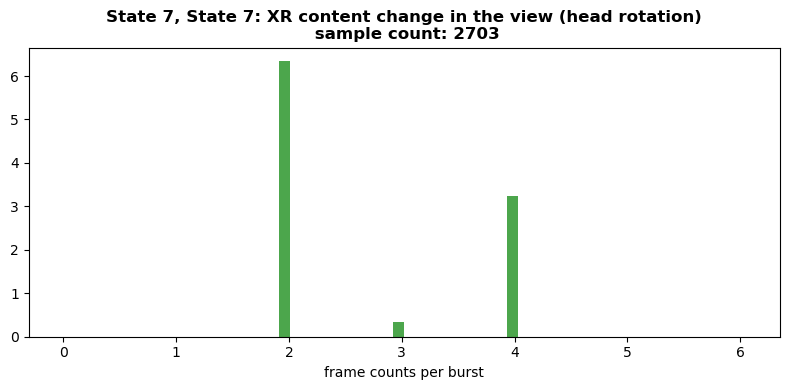

In [33]:
## State specific per-burst frame numbers, i.e., how many frames included in a burst

for phase_state in range(len(dict_op_state_def)):
    phase_state_term = dict_op_state_def[phase_state]

    title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
                                                                          len(list_of_lst_burst_size[phase_state]))

    print(len(list_of_lst_burst_frame_count[phase_state]))
    
    
    fig, ax = plt.subplots(figsize=(8, 4))

    num_bins = 60

    ## Plot the histogram of the i-th tags in segments

    # x_seq = [i for i in tag_lists[0] if i > 16000]
    # x_seq = [i for i in tag_lists[1] if i > 16000]
    # x_seq = [i for i in tag_lists[2] if i > 16000]
    # x_seq = [i for i in tag_lists[4] if i > 16000]
    #x_seq = [i for i in tag_lists[3]]
    # x_seq = [i for i in tag_lists[2]]        
    # print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


    # plot the histogram
    n, bins, patches = ax.hist(list_of_lst_burst_frame_count[phase_state], num_bins, 
                               range=[-0.005, 6.05],
                                density = 1,
                                color ='green',
                                alpha = 0.7)

    # plot the cumulative histogram
    # n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
    #                            cumulative=True, label='Empirical')


    plt.xlabel("frame counts per burst")
    # plt.ylabel('Y-Axis')

    title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
                                                                          len(list_of_lst_burst_frame_count[phase_state]))


    plt.title(title_print,
              fontweight = "bold")

    plt.show()
    
    
#     if len(list_of_lst_burst_frame_count[phase_state]) > 0:
    
#         x_min_display = min(list_of_lst_burst_time[phase_state])
#         x_max_display = max(list_of_lst_burst_time[phase_state])#pcap_end_time
        
#     else:
#         x_min_display = 0
#         x_max_display = 680
        
#     scatterplot(list_of_lst_burst_time[phase_state], list_of_lst_burst_size[phase_state], x_xlim=[x_min_display, x_max_display], \
# #             y_ylim=[0, 30], \
#             x_label="Time (sec)", y_label="Burst size (byte)", title=title_print, figSave=False, fig_index="")

#     plt.show()


#####
# Conclusion: no significant state-specific difference was found.

882
882


<Figure size 1200x800 with 0 Axes>

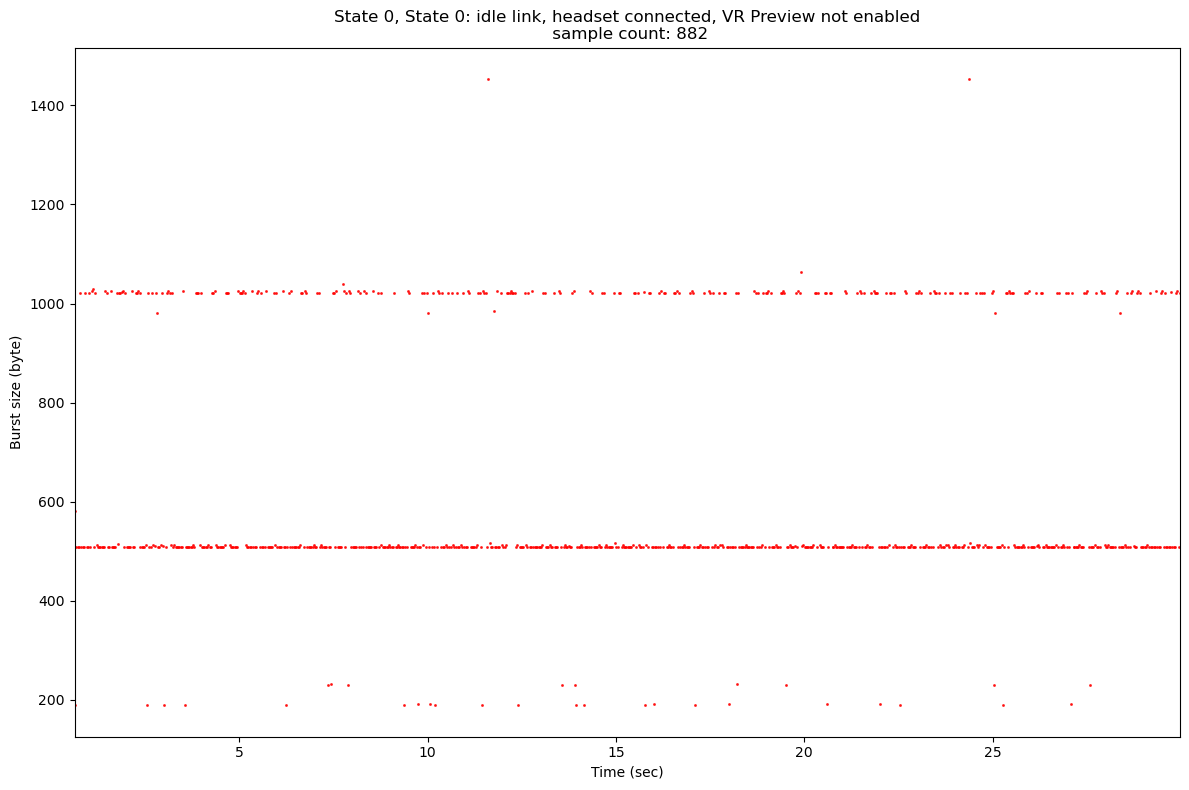

884
884


<Figure size 1200x800 with 0 Axes>

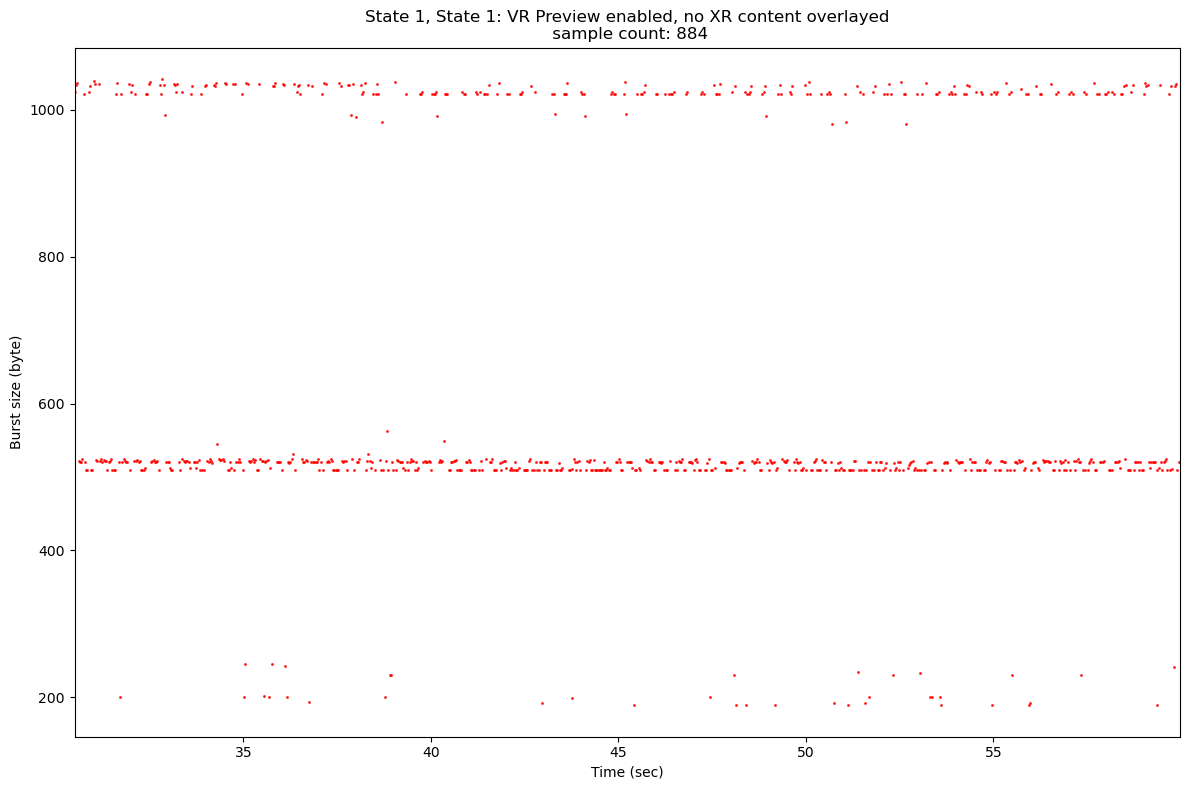

7862
7862


<Figure size 1200x800 with 0 Axes>

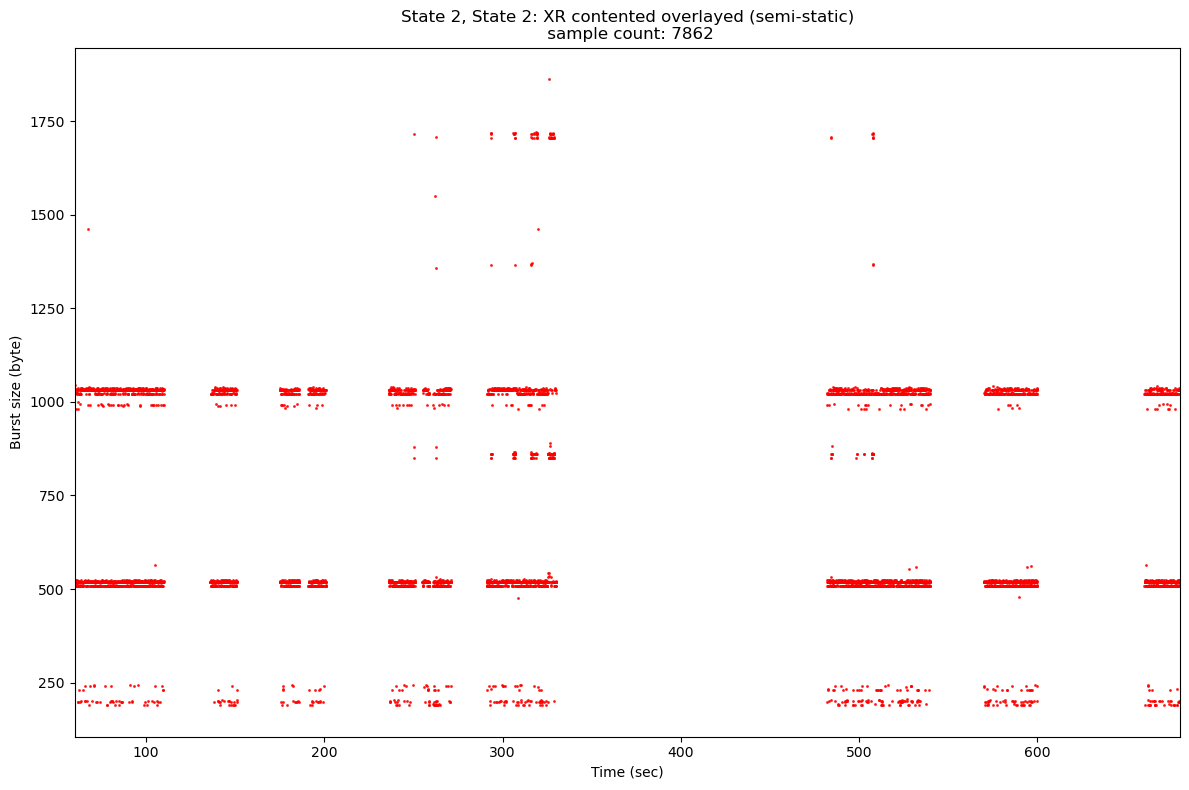

855
855


<Figure size 1200x800 with 0 Axes>

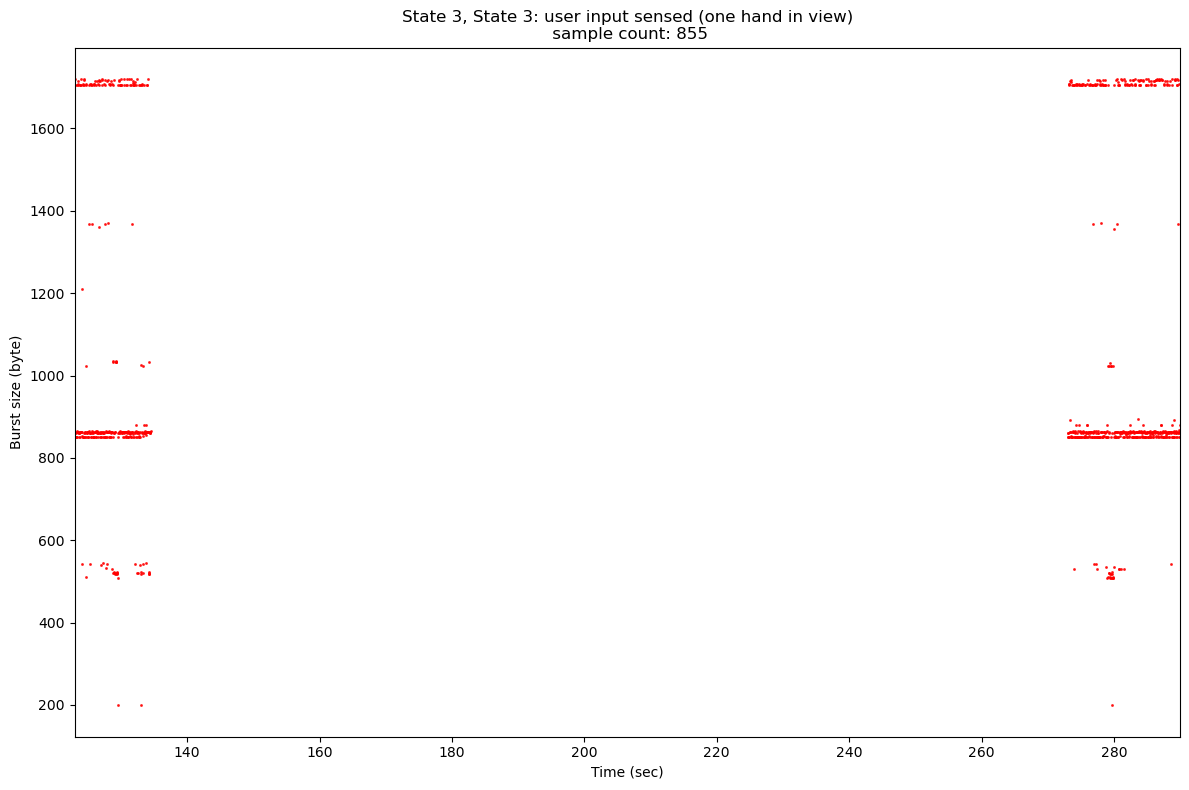

1095
1095


<Figure size 1200x800 with 0 Axes>

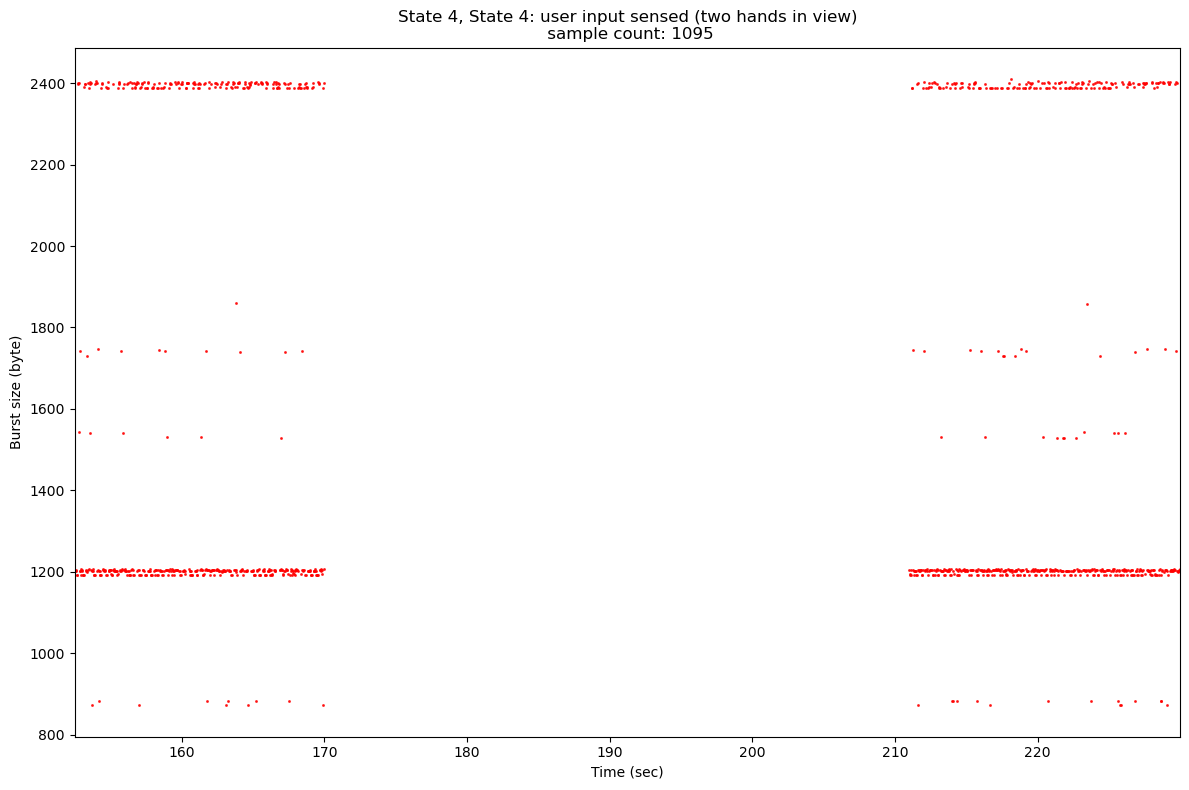

3602
3602


<Figure size 1200x800 with 0 Axes>

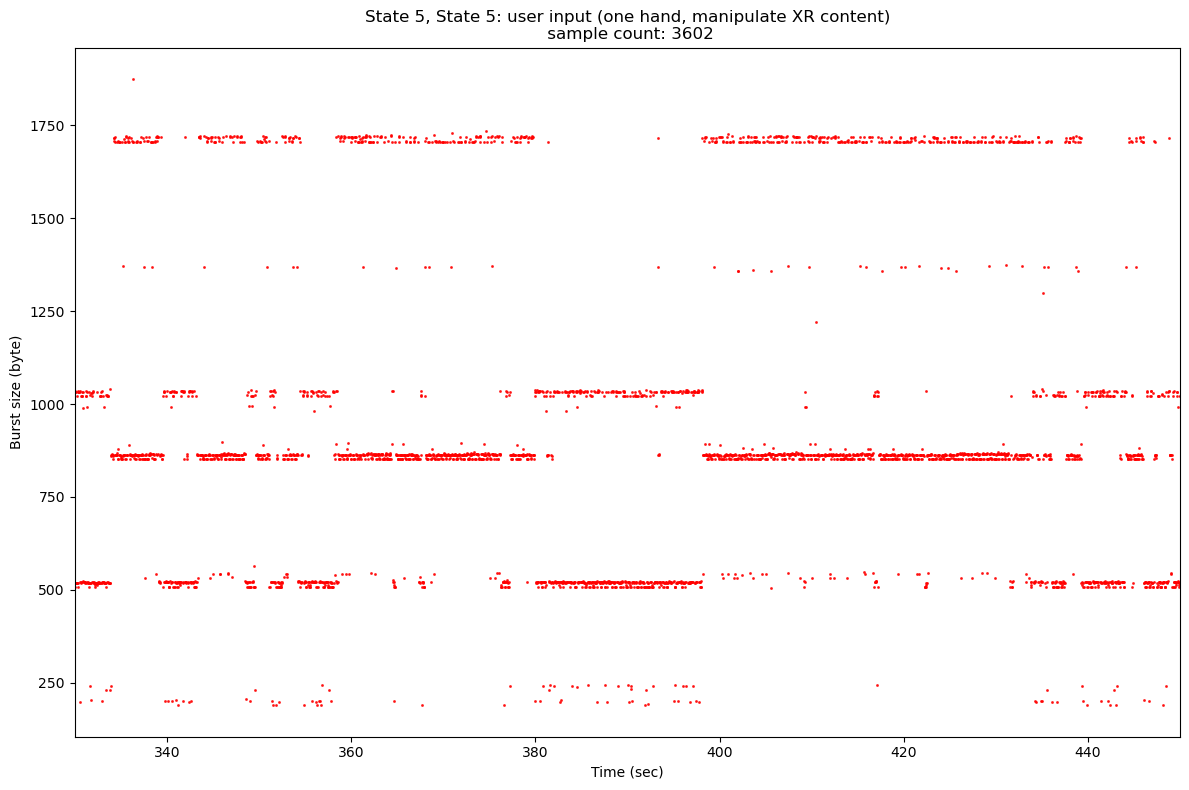

900
900


<Figure size 1200x800 with 0 Axes>

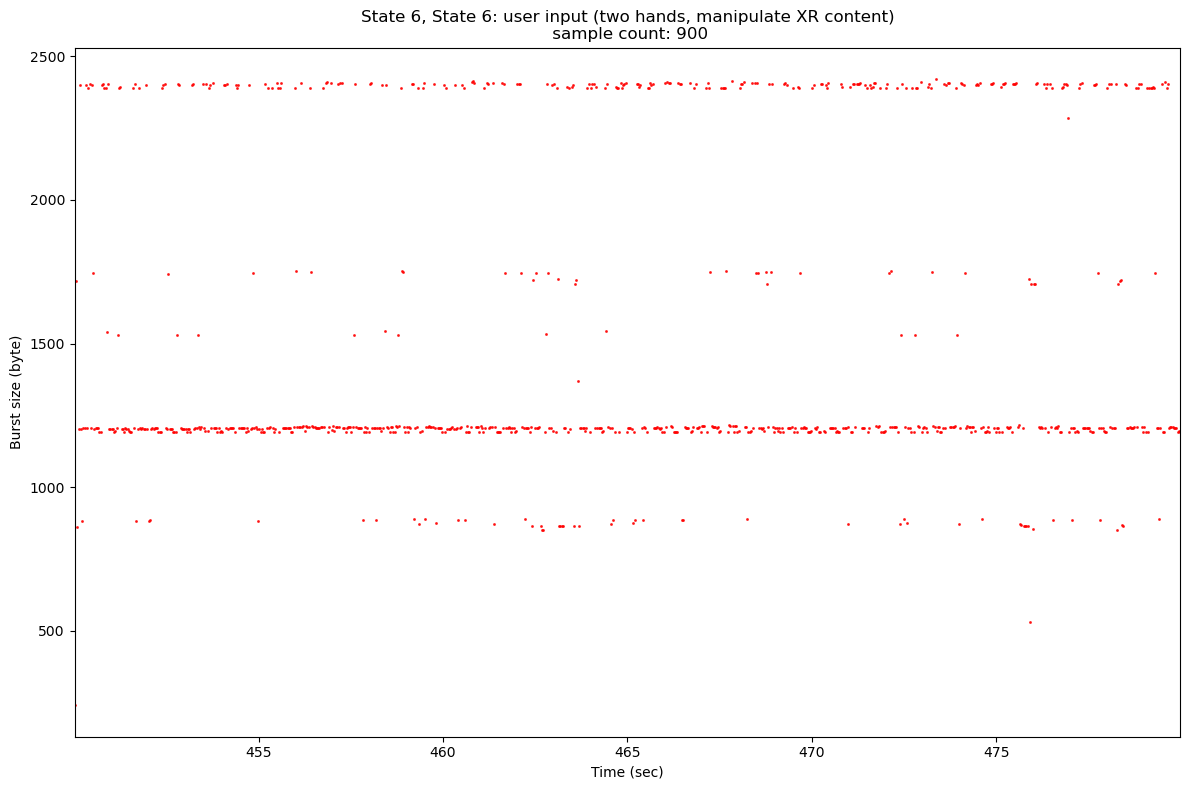

2703
2703


<Figure size 1200x800 with 0 Axes>

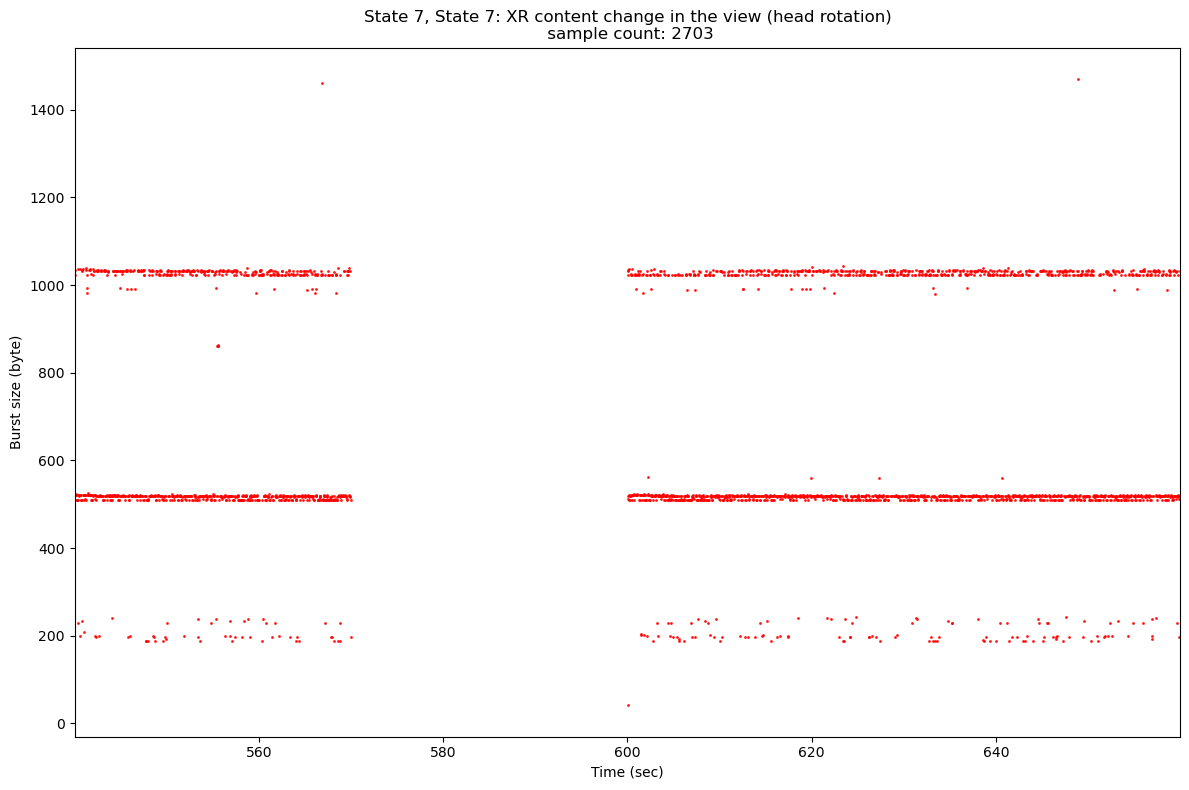

In [34]:
## Burst size distribution (burst size contains all sizes of frames, head or tail.)

#### First, per state burst size variation with time

for phase_state in range(len(dict_op_state_def)):
    phase_state_term = dict_op_state_def[phase_state]

    title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
                                                                          len(list_of_lst_burst_size[phase_state]))

    print(len(list_of_lst_burst_time[phase_state]))
    print(len(list_of_lst_burst_size[phase_state]))
    
    
    
    if len(list_of_lst_burst_time[phase_state]) > 0:
    
        x_min_display = min(list_of_lst_burst_time[phase_state])
        x_max_display = max(list_of_lst_burst_time[phase_state])#pcap_end_time
        
    else:
        x_min_display = 0
        x_max_display = 680
        
    scatterplot(list_of_lst_burst_time[phase_state], list_of_lst_burst_size[phase_state], x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Burst size (byte)", title=title_print, figSave=False, fig_index="")

    plt.show()
    
    
####
# Conclusion: there are significant different burst sizes at each state

Unique burst size values: 8 at State 0
Size: 200 with prob. 0.024943310657596373
Size: 250 with prob. 0.01020408163265306
Size: 550 with prob. 0.671201814058957
Size: 600 with prob. 0.0011337868480725624
Size: 1000 with prob. 0.005668934240362812
Size: 1050 with prob. 0.2834467120181406
Size: 1100 with prob. 0.0011337868480725624
Size: 1500 with prob. 0.0022675736961451248


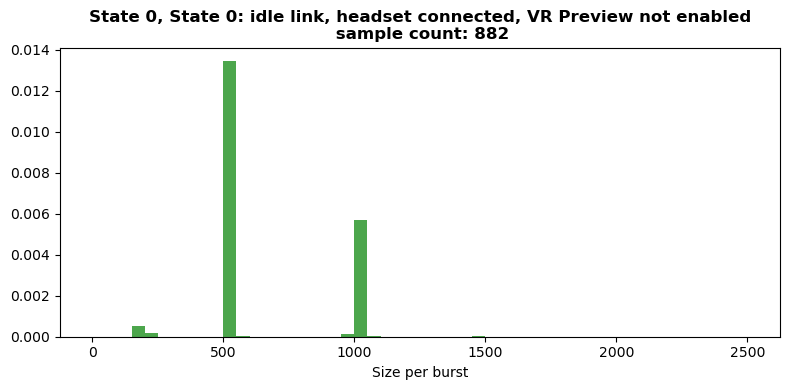

Unique burst size values: 6 at State 1
Size: 200 with prob. 0.020361990950226245
Size: 250 with prob. 0.02262443438914027
Size: 550 with prob. 0.670814479638009
Size: 600 with prob. 0.0011312217194570137
Size: 1000 with prob. 0.013574660633484163
Size: 1050 with prob. 0.27149321266968324


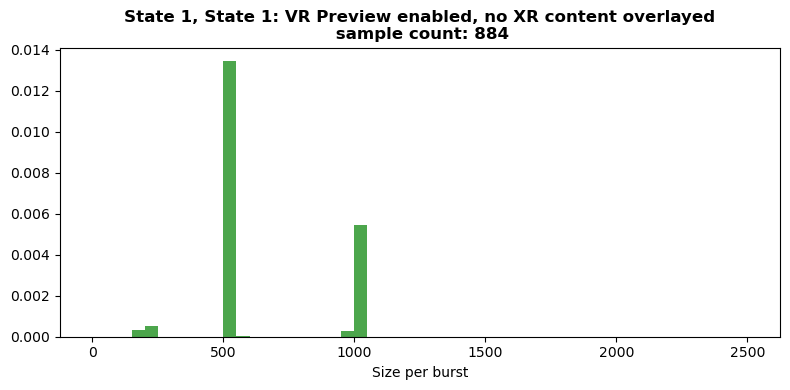

Unique burst size values: 13 at State 2
Size: 200 with prob. 0.03408801831595014
Size: 250 with prob. 0.020859832103790384
Size: 500 with prob. 0.0002543881963876876
Size: 550 with prob. 0.6109132536250318
Size: 600 with prob. 0.0007631645891630628
Size: 900 with prob. 0.019460697023658102
Size: 1000 with prob. 0.014627321292292038
Size: 1050 with prob. 0.2897481556855762
Size: 1400 with prob. 0.0010175527855507504
Size: 1500 with prob. 0.0002543881963876876
Size: 1550 with prob. 0.0001271940981938438
Size: 1750 with prob. 0.007758839989824472
Size: 1900 with prob. 0.0001271940981938438


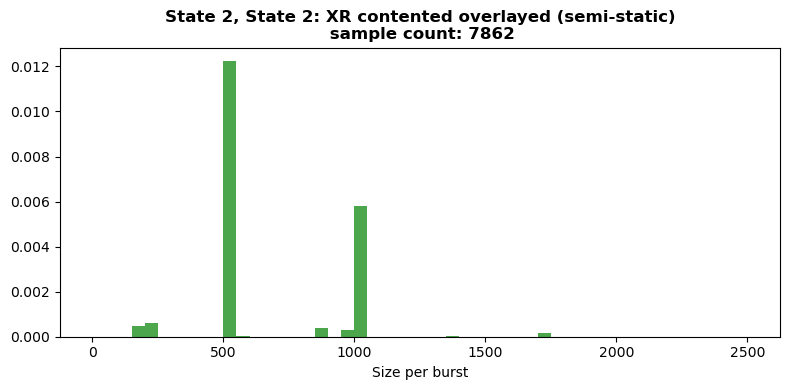

Unique burst size values: 7 at State 3
Size: 200 with prob. 0.0035087719298245615
Size: 550 with prob. 0.06783625730994151
Size: 900 with prob. 0.6456140350877193
Size: 1050 with prob. 0.01871345029239766
Size: 1250 with prob. 0.0011695906432748538
Size: 1400 with prob. 0.012865497076023392
Size: 1750 with prob. 0.25029239766081873


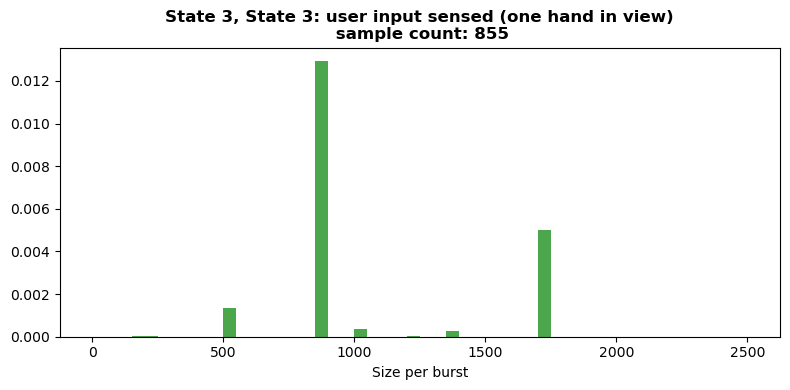

Unique burst size values: 8 at State 4
Size: 900 with prob. 0.0228310502283105
Size: 1200 with prob. 0.17168949771689498
Size: 1250 with prob. 0.4511415525114155
Size: 1550 with prob. 0.015525114155251141
Size: 1750 with prob. 0.0228310502283105
Size: 1900 with prob. 0.0018264840182648401
Size: 2400 with prob. 0.26210045662100456
Size: 2450 with prob. 0.052054794520547946


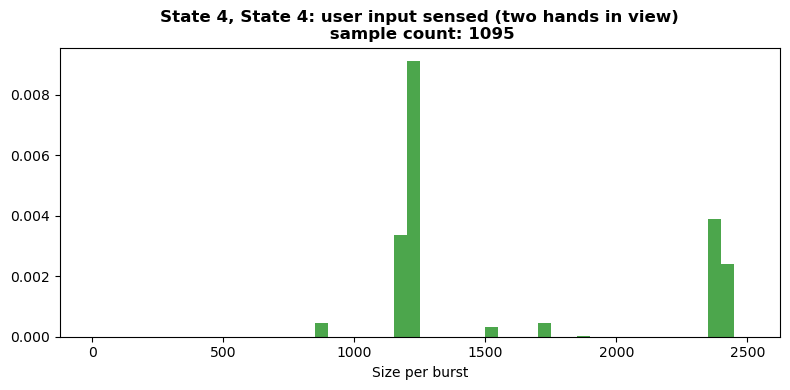

Unique burst size values: 12 at State 5
Size: 200 with prob. 0.010272071071626874
Size: 250 with prob. 0.014714047751249307
Size: 550 with prob. 0.25458078845086063
Size: 600 with prob. 0.000277623542476402
Size: 900 with prob. 0.42226540810660745
Size: 1000 with prob. 0.005274847307051638
Size: 1050 with prob. 0.11438089950027762
Size: 1250 with prob. 0.000277623542476402
Size: 1300 with prob. 0.000277623542476402
Size: 1400 with prob. 0.010827318156579679
Size: 1750 with prob. 0.1665741254858412
Size: 1900 with prob. 0.000277623542476402


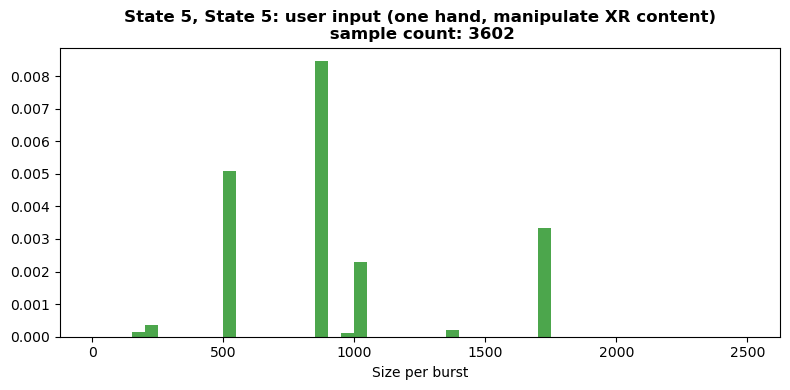

Unique burst size values: 12 at State 6
Size: 250 with prob. 0.0011111111111111111
Size: 550 with prob. 0.0011111111111111111
Size: 900 with prob. 0.06
Size: 1200 with prob. 0.17888888888888888
Size: 1250 with prob. 0.43
Size: 1400 with prob. 0.0011111111111111111
Size: 1550 with prob. 0.013333333333333334
Size: 1750 with prob. 0.03666666666666667
Size: 1800 with prob. 0.0044444444444444444
Size: 2300 with prob. 0.0011111111111111111
Size: 2400 with prob. 0.10333333333333333
Size: 2450 with prob. 0.1688888888888889


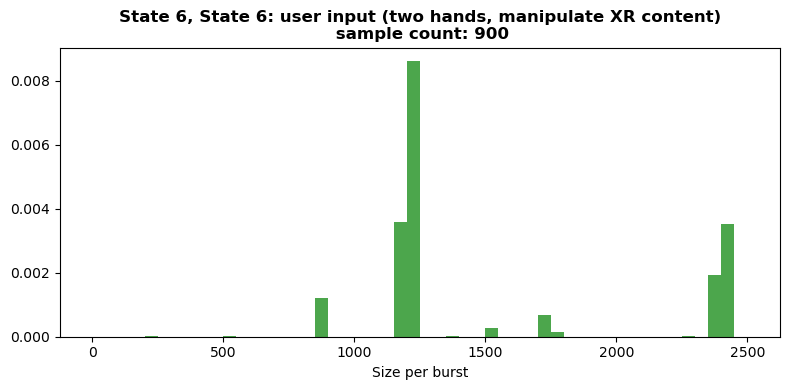

Unique burst size values: 9 at State 7
Size: 50 with prob. 0.0003699593044765076
Size: 200 with prob. 0.040695523492415835
Size: 250 with prob. 0.022197558268590455
Size: 550 with prob. 0.5945246022937477
Size: 600 with prob. 0.0014798372179060304
Size: 900 with prob. 0.0014798372179060304
Size: 1000 with prob. 0.012578616352201259
Size: 1050 with prob. 0.3259341472438032
Size: 1500 with prob. 0.0007399186089530152


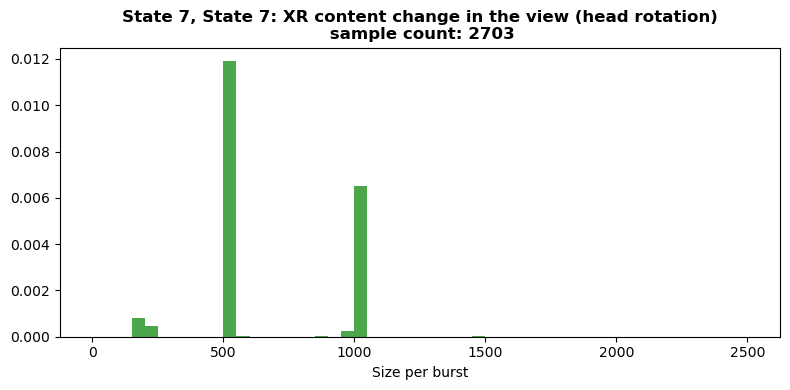

In [35]:
#### Second, stochastic distribution of burst sizes per state

list_of_lst_unique_sizes_val = []
list_of_lst_unique_sizes_prob = []

for phase_state in range(len(dict_op_state_def)):
    phase_state_term = dict_op_state_def[phase_state]

    title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
                                                                          len(list_of_lst_burst_size[phase_state]))

#     print(len(list_of_lst_burst_time[phase_state]))
#     print(len(list_of_lst_burst_size[phase_state]))
    
    size_group_step = 50
    lst_burst_size_group = [math.ceil(i/size_group_step) for i in list_of_lst_burst_size[phase_state]]
    unique_sizes = list(set(lst_burst_size_group))
    unique_sizes.sort()
    print("Unique burst size values: {} at State {}".format(len(unique_sizes), phase_state))
    
    unique_sizes_val = [i*size_group_step for i in unique_sizes]
#     print("burst values: ", unique_sizes_val)
    
    unique_sizes_prob = [0 for i in unique_sizes]
    for i in lst_burst_size_group:
        unique_sizes_prob[unique_sizes.index(i)] += 1
        
    len_lst_burst_size_group = len(lst_burst_size_group)
    unique_sizes_prob = [i/len_lst_burst_size_group for i in unique_sizes_prob]
#     print("Prob. of burst values: ", unique_sizes_prob)
#     print("Sum: Prob. of burst values: ", sum(unique_sizes_prob))
    
    for i in range(len(unique_sizes_val)):
        print("Size: {} with prob. {}".format(unique_sizes_val[i], unique_sizes_prob[i]))
        
    list_of_lst_unique_sizes_val.append(unique_sizes_val)
    list_of_lst_unique_sizes_prob.append(unique_sizes_prob)
    
#     if len(list_of_lst_burst_time[phase_state]) > 0:
    
#         x_min_display = min(list_of_lst_burst_time[phase_state])
#         x_max_display = max(list_of_lst_burst_time[phase_state])#pcap_end_time
        
#     else:
#         x_min_display = 0
#         x_max_display = 680
        
#     scatterplot(list_of_lst_burst_time[phase_state], list_of_lst_burst_size[phase_state], x_xlim=[x_min_display, x_max_display], \
# #             y_ylim=[0, 30], \
#             x_label="Time (sec)", y_label="Burst size (byte)", title=title_print, figSave=False, fig_index="")

#     plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 4))

    num_bins = math.ceil(2500 / size_group_step)

    ## Plot the histogram of the i-th tags in segments

    # x_seq = [i for i in tag_lists[0] if i > 16000]
    # x_seq = [i for i in tag_lists[1] if i > 16000]
    # x_seq = [i for i in tag_lists[2] if i > 16000]
    # x_seq = [i for i in tag_lists[4] if i > 16000]
    #x_seq = [i for i in tag_lists[3]]
    # x_seq = [i for i in tag_lists[2]]        
    # print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


    # plot the histogram
    n, bins, patches = ax.hist(list_of_lst_burst_size[phase_state], num_bins, 
                                range=[0, 2500],
                                density = 1,
                                color ='green',
                                alpha = 0.7)

    # plot the cumulative histogram
    # n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
    #                            cumulative=True, label='Empirical')


    plt.xlabel("Size per burst")
    # plt.ylabel('Y-Axis')

#     title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
#                                                                           len(list_of_lst_burst_frame_count[phase_state]))


    plt.title(title_print,
              fontweight = "bold")

    plt.show()


###
# Table for discrete burst size PMF per state
# Columns: State, size tap count, tap list ([[Tap value, Tap prob.]]) 


In [36]:
len(list_of_lst_unique_sizes_val[1])
list_of_lst_unique_sizes_val[1]

[200, 250, 550, 600, 1000, 1050]

In [37]:
list_of_lst_unique_sizes_prob[1]

[0.020361990950226245,
 0.02262443438914027,
 0.670814479638009,
 0.0011312217194570137,
 0.013574660633484163,
 0.27149321266968324]

In [39]:
#############################################
## Export the burst size stats data into CSV
write_file_path = "rfh_us_burst_size_pmf.csv" 
write_header_row = ["app_state", "burst_size", "pmf"]
cols_wrt = {k: v for v, k in enumerate(write_header_row)}

mat_burst_size_export = []

for i in range(len(list_of_lst_unique_sizes_val)):
    if len(list_of_lst_unique_sizes_val)==len(list_of_lst_unique_sizes_prob):
        for j in range(len(list_of_lst_unique_sizes_val[i])):
            mat_burst_size_export.append([i, list_of_lst_unique_sizes_val[i][j], list_of_lst_unique_sizes_prob[i][j]])
    else:
        print("error: pmf list length mismatched!")


if len(mat_burst_size_export) > 0:
    with open(write_file_path, mode='w', newline='') as wr_file:
        csv_writer = csv.writer(wr_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(write_header_row)
        csv_writer.writerows(mat_burst_size_export)
    #os.remove(csv_file_path)
    #os.rename(write_file_path, csv_file_path)
    
print("Save the data in the file: ", write_file_path)

print("column names: ", cols_wrt)

Save the data in the file:  rfh_us_burst_size_pmf.csv
column names:  {'app_state': 0, 'burst_size': 1, 'pmf': 2}


50


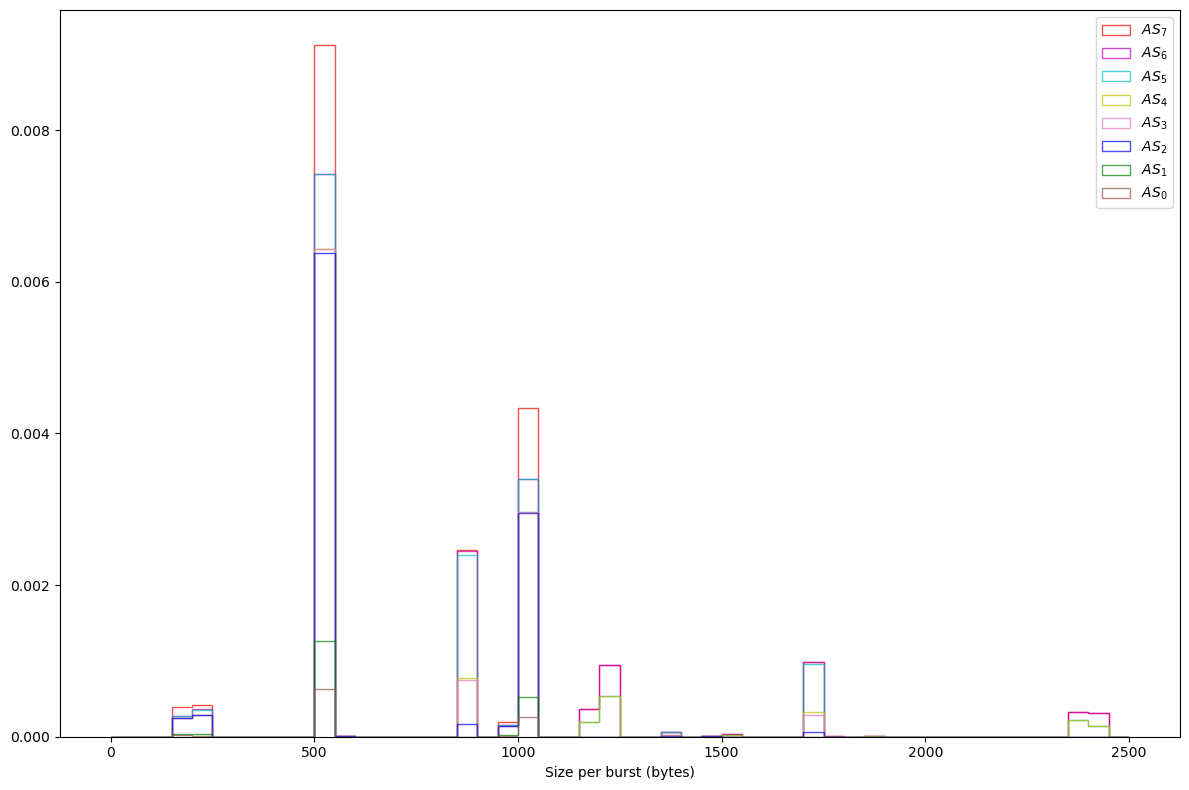

50


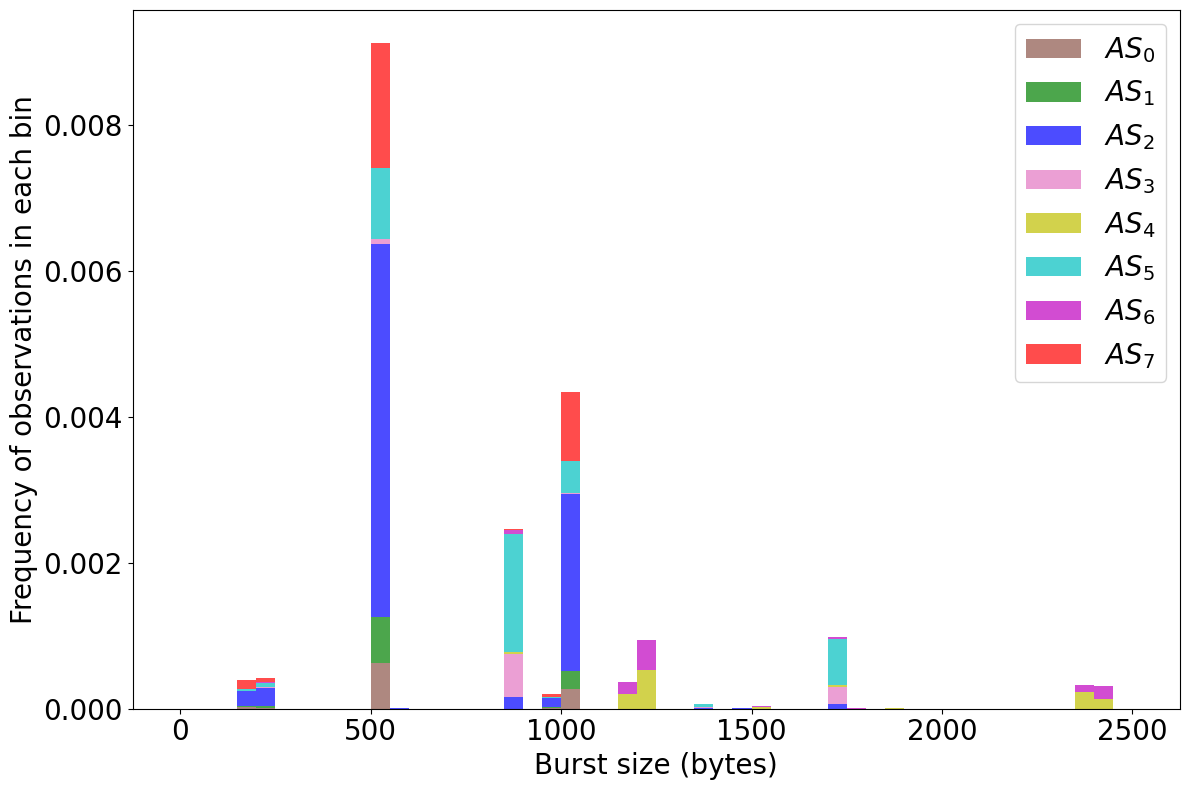

In [40]:
#### Second, stochastic distribution of burst sizes per state

## Ref: https://matplotlib.org/stable/gallery/statistics/histogram_multihist.html

   
fig, ax = plt.subplots(figsize=(12, 8))
size_group_step = 50
num_bins = math.ceil(2500 / size_group_step)

print(num_bins)

# plot the histogram

color_vec = ['tab:brown', 'g', 'b', 'tab:pink', 'y', 'c', 'm', 'r']

n, bins, patches = ax.hist(list_of_lst_burst_size, num_bins, 
                            range=[0, 2500],
                            density = 1,
                            color =color_vec,
                           histtype='step',
                           stacked=True,
                           fill=False,
                           cumulative=False,
                           label = ["$AS_0$", "$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
                            alpha = 0.7)


plt.xlabel("Size per burst (bytes)")
# plt.ylabel('Y-Axis')
plt.legend(loc='upper right') #(loc='upper right') 

plt.show()



fig, ax = plt.subplots(figsize=(12, 8))
size_group_step = 50
num_bins = math.ceil(2500 / size_group_step)

print(num_bins)

# plot the histogram

color_vec = ['tab:brown', 'g', 'b', 'tab:pink', 'y', 'c', 'm', 'r']


list_of_weights = []
for i in list_of_lst_burst_size:
    weights=np.ones_like(range(len(i))) / len(i)
#     print(weights)
    list_of_weights.append(weights)
    
    


n, bins, patches = ax.hist(list_of_lst_burst_size, num_bins, 
                            range=[0, 2500],
                            density = 1,
#                            weights = [1/len(list_of_lst_burst_size) for i in range(len(list_of_lst_burst_size))],
                            color =color_vec,
                           histtype='bar',
                           stacked=True,
                           fill=True,
                           cumulative=False,
                           label = ["$AS_0$", "$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
                            alpha = 0.7)


plt.xlabel("Burst size (bytes)", fontsize=20)
plt.ylabel('Frequency of observations in each bin', fontsize=20)
plt.legend(loc='upper right', fontsize=20) #(loc='upper right') 
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# ax.set_ylim([0, 0.01])

plt.show()




###
# Table for discrete burst size PMF per state
# Columns: State, size tap count, tap list ([[Tap value, Tap prob.]]) 


In [41]:
list_of_weights

[array([0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00113379, 0.00113379,
        0.00113379, 0.00113379, 0.00113379, 0.00

State 0, State 0: idle link, headset connected, VR Preview not enabled
 sample count: 882
Tap 0 collects 882 samples


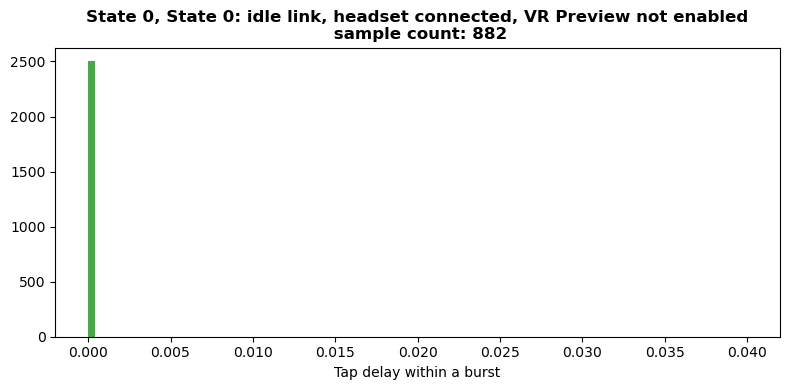

Tap 1 collects 882 samples


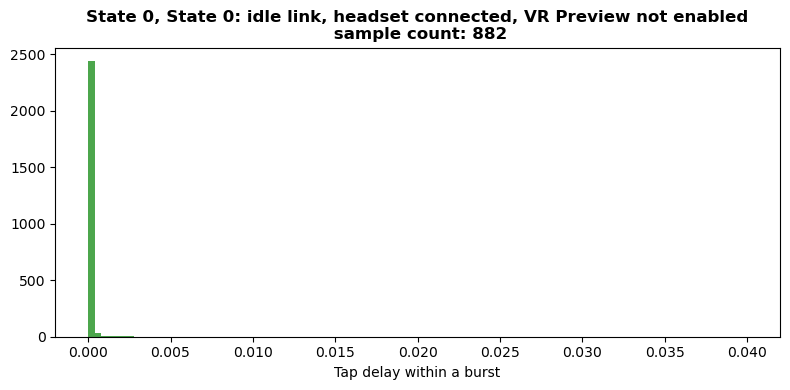

Tap 2 collects 267 samples


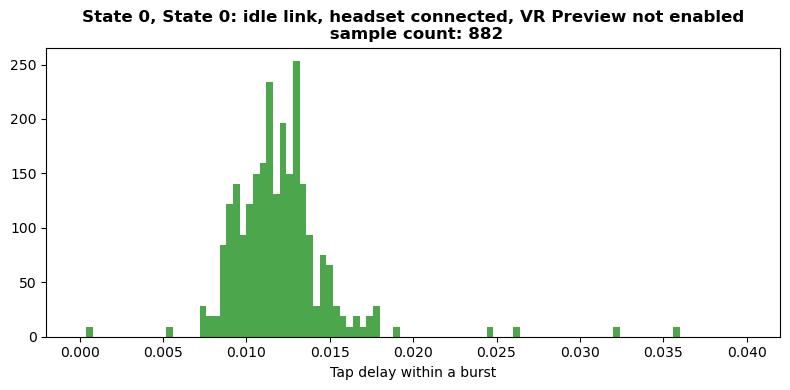

Tap 3 collects 253 samples


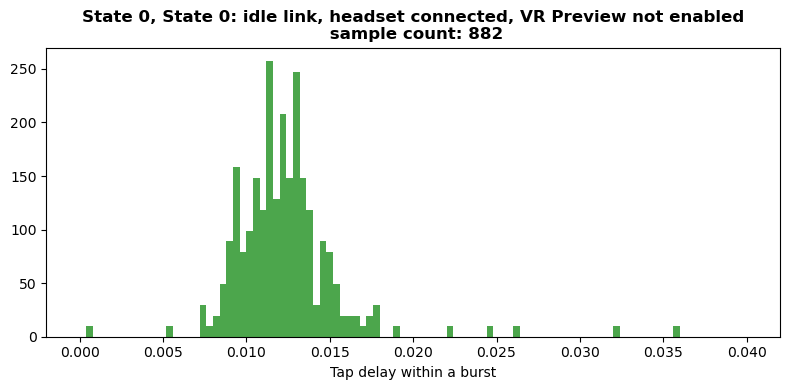

Tap 4 collects 1 samples


C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


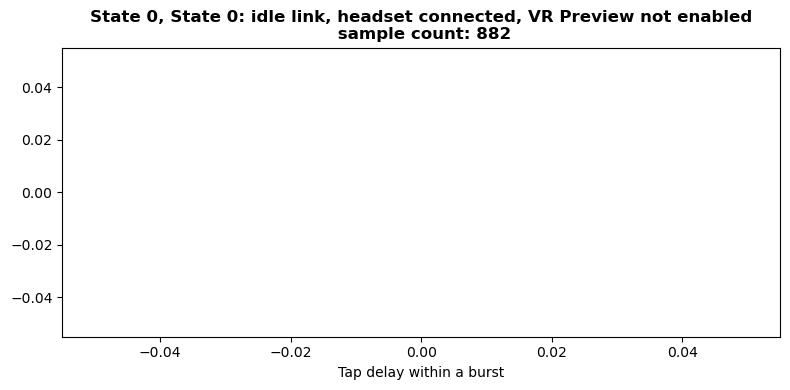

Tap 5 collects 0 samples


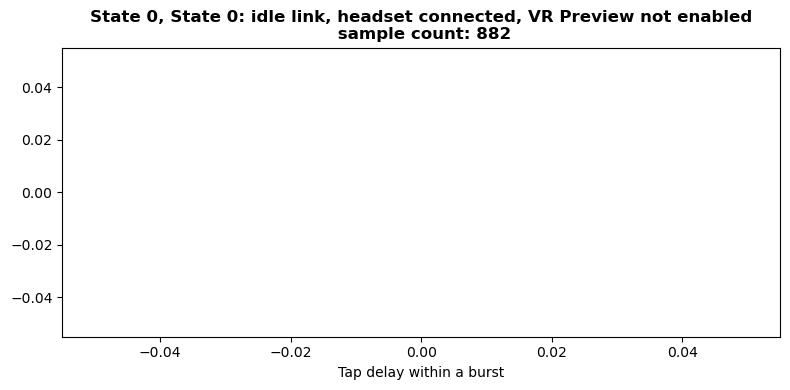

State 1, State 1: VR Preview enabled, no XR content overlayed
 sample count: 884
Tap 0 collects 884 samples


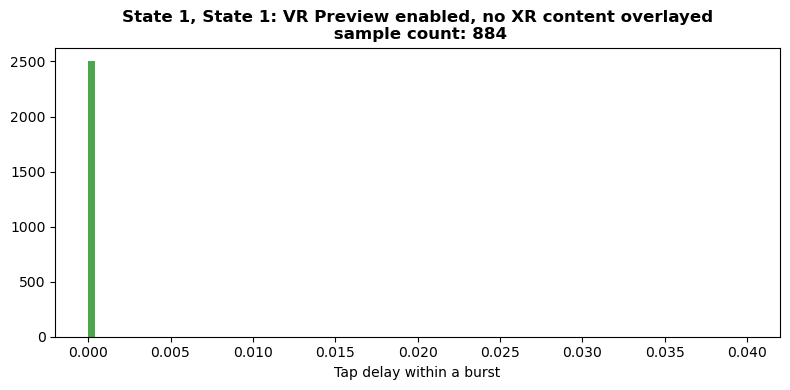

Tap 1 collects 884 samples


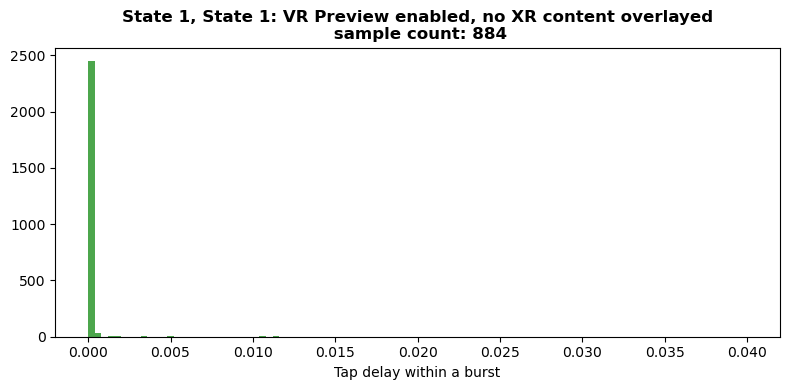

Tap 2 collects 265 samples


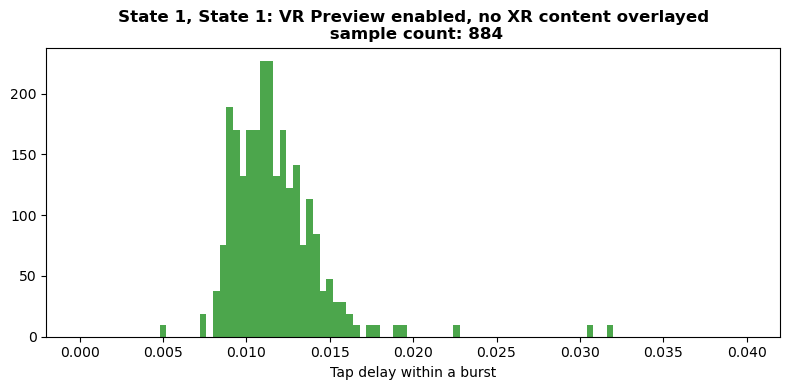

Tap 3 collects 240 samples


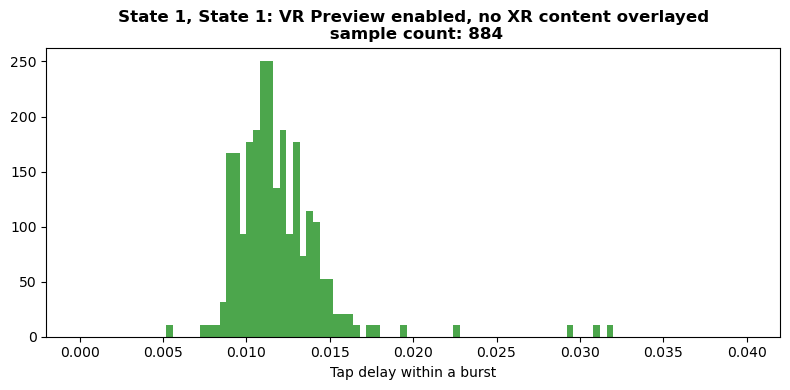

Tap 4 collects 0 samples


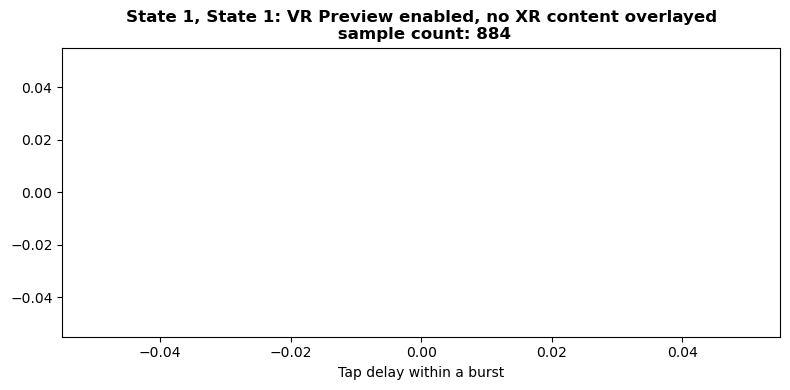

Tap 5 collects 0 samples


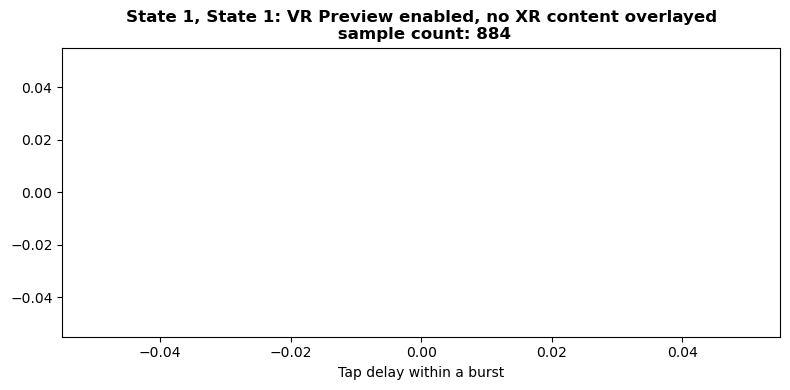

State 2, State 2: XR contented overlayed (semi-static)
 sample count: 7862
Tap 0 collects 7862 samples


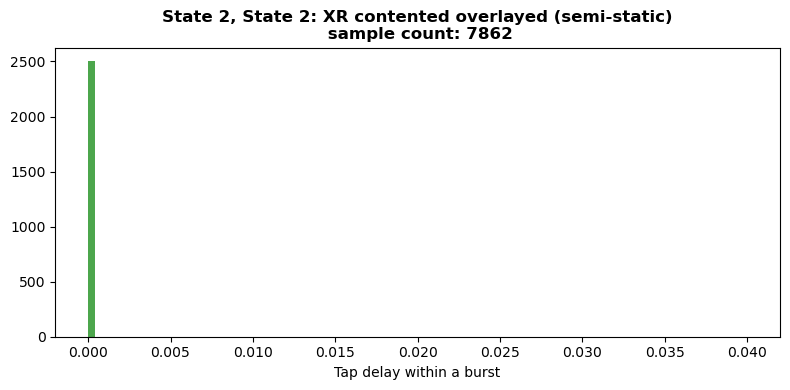

Tap 1 collects 7860 samples


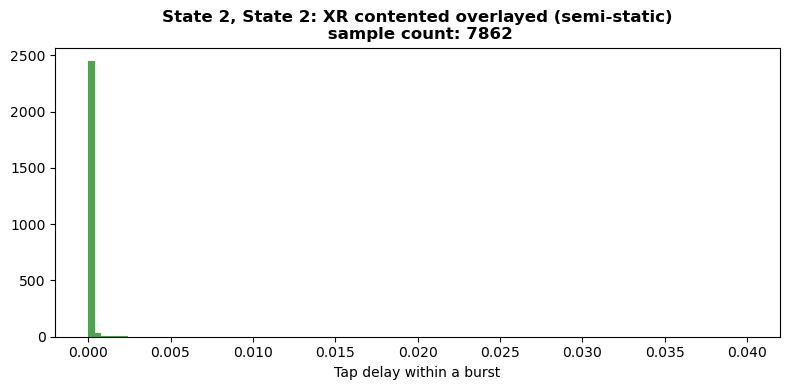

Tap 2 collects 2602 samples


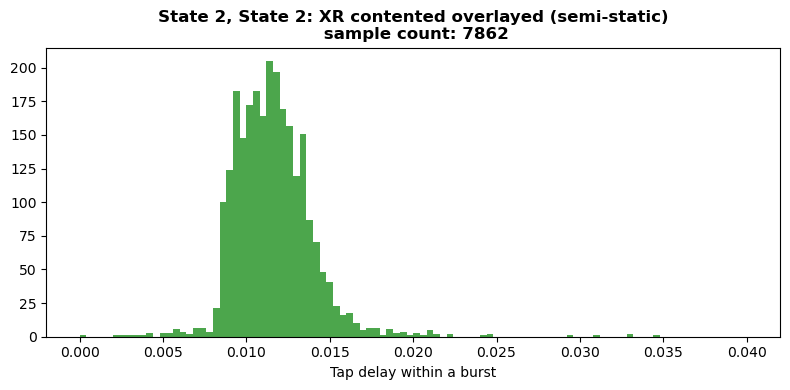

Tap 3 collects 2342 samples


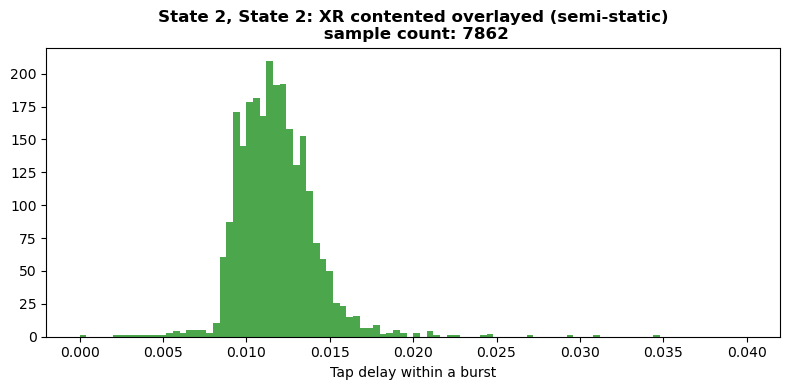

Tap 4 collects 1 samples


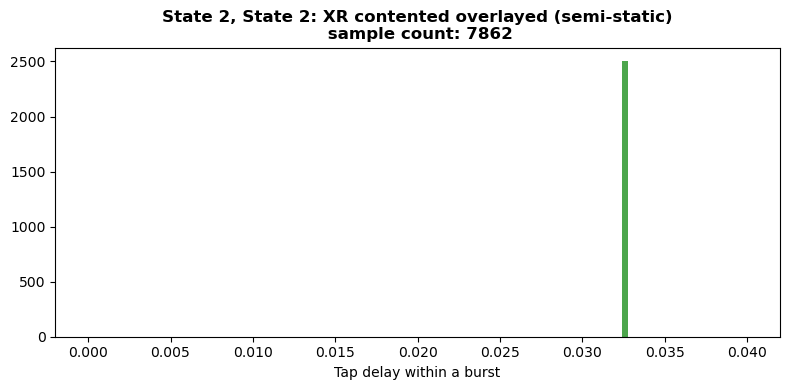

Tap 5 collects 1 samples


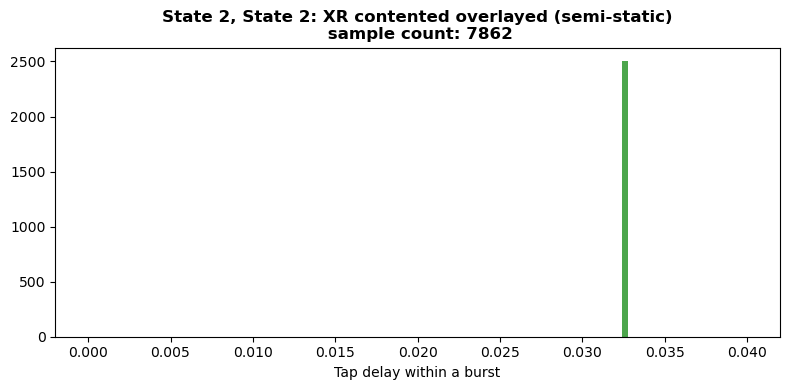

State 3, State 3: user input sensed (one hand in view)
 sample count: 855
Tap 0 collects 855 samples


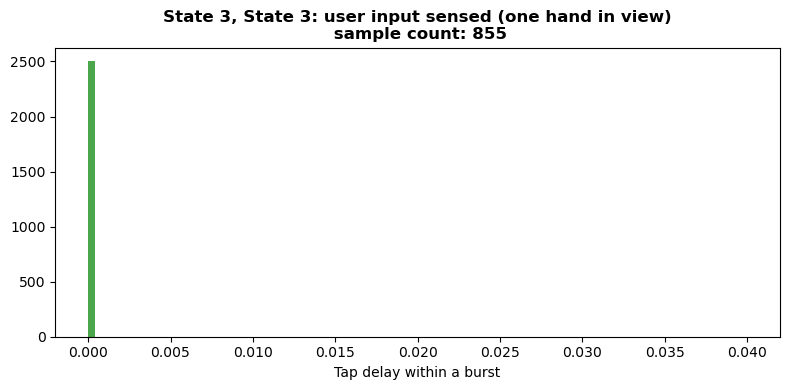

Tap 1 collects 855 samples


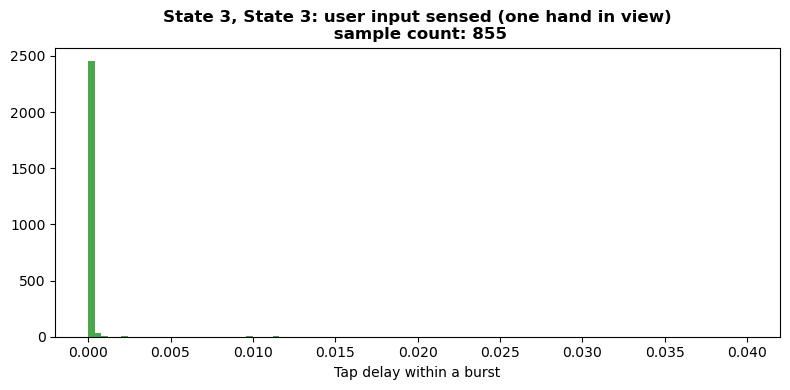

Tap 2 collects 259 samples


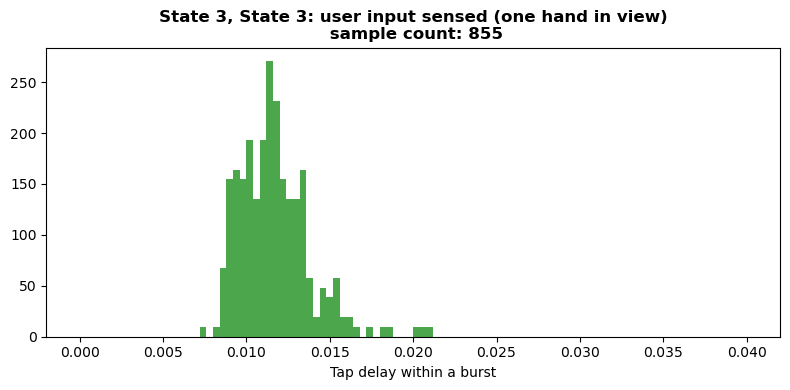

Tap 3 collects 230 samples


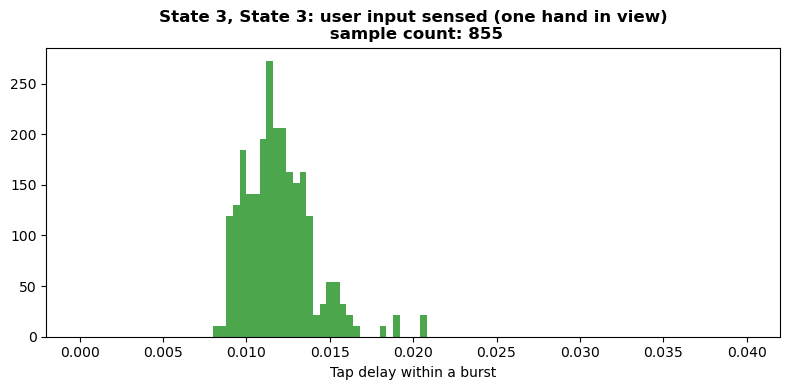

Tap 4 collects 0 samples


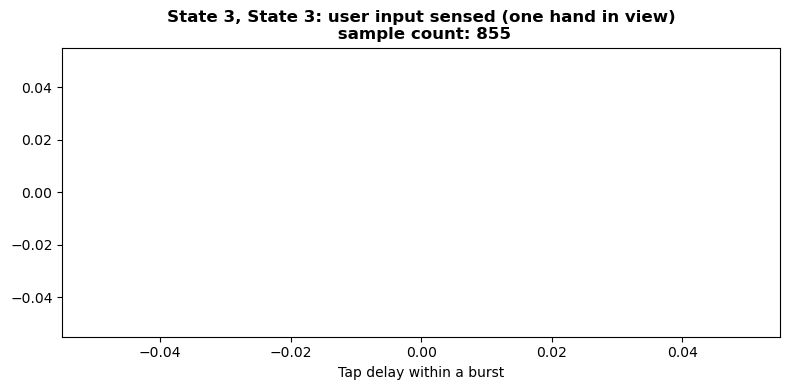

Tap 5 collects 0 samples


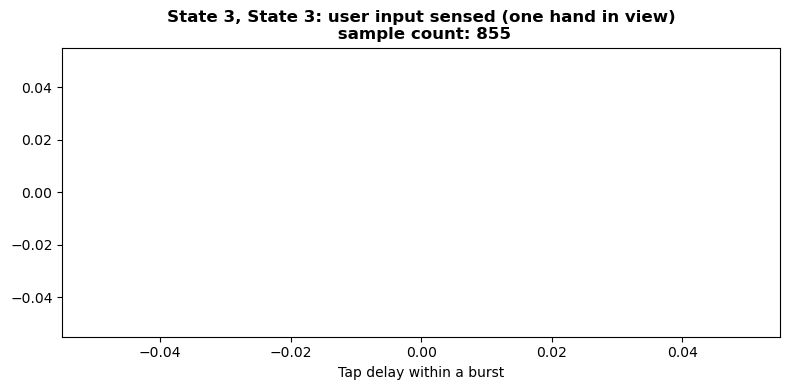

State 4, State 4: user input sensed (two hands in view)
 sample count: 1095
Tap 0 collects 1095 samples


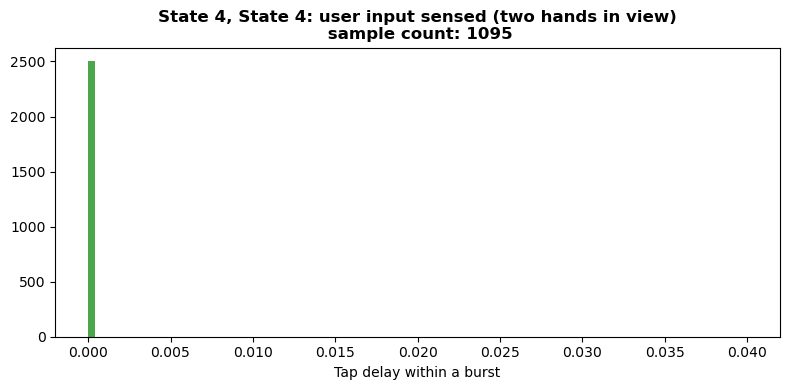

Tap 1 collects 1095 samples


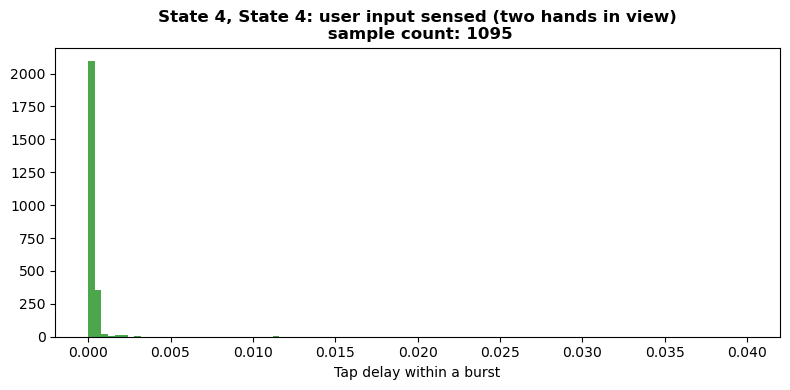

Tap 2 collects 388 samples


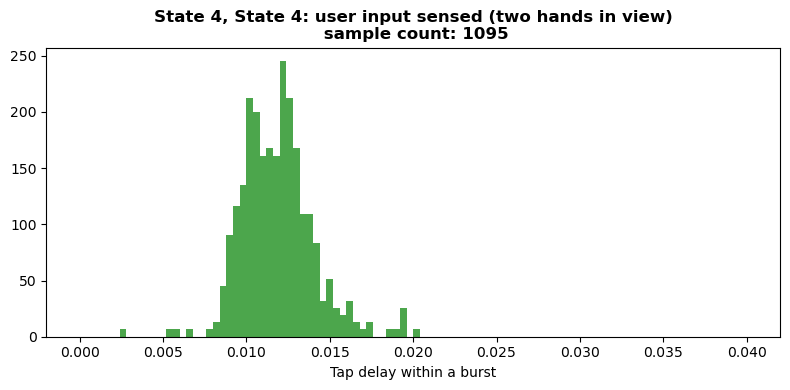

Tap 3 collects 344 samples


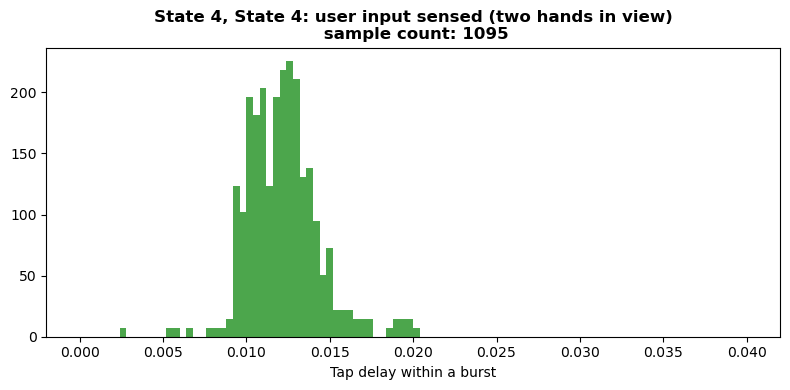

Tap 4 collects 0 samples


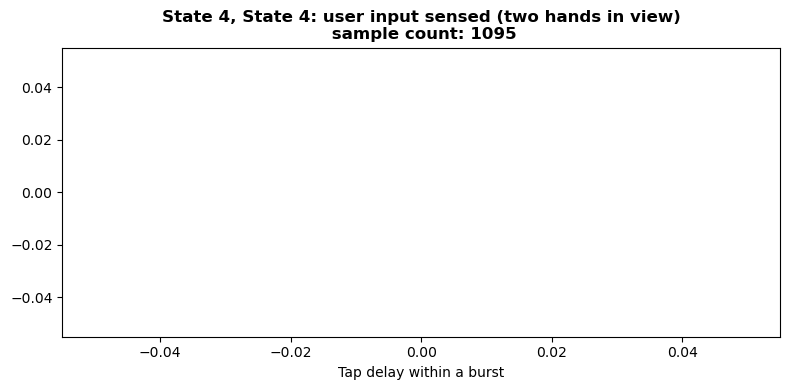

Tap 5 collects 0 samples


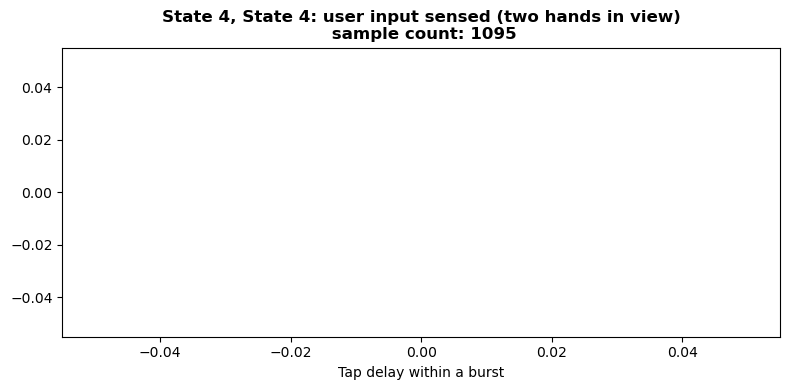

State 5, State 5: user input (one hand, manipulate XR content)
 sample count: 3602
Tap 0 collects 3602 samples


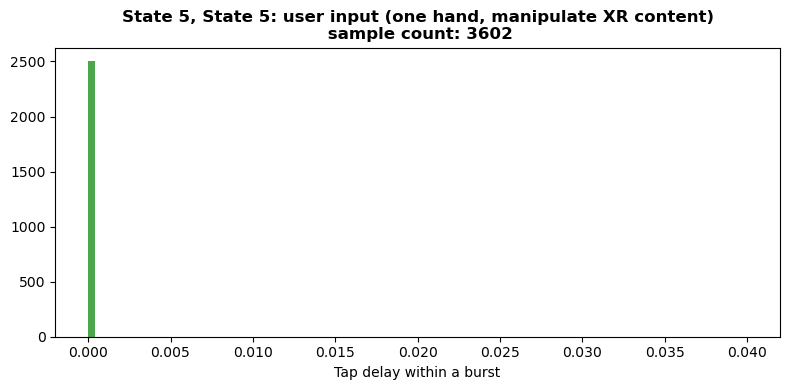

Tap 1 collects 3601 samples


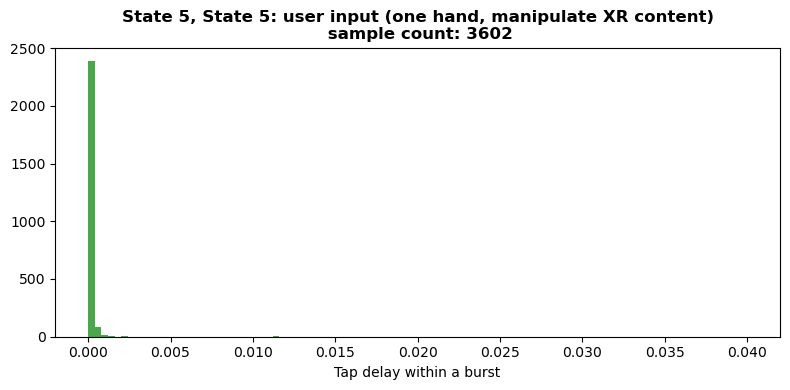

Tap 2 collects 1139 samples


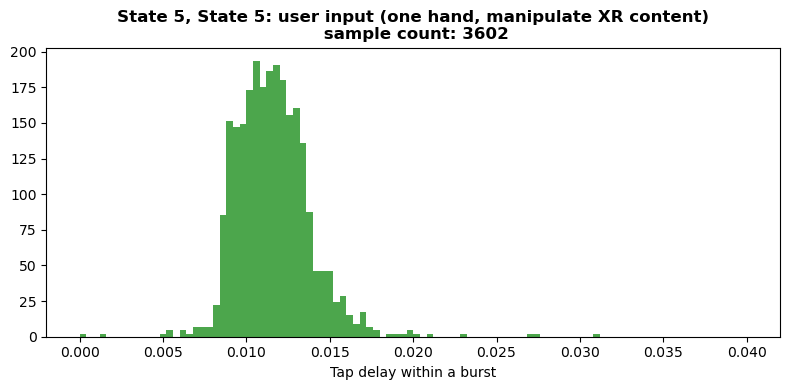

Tap 3 collects 1013 samples


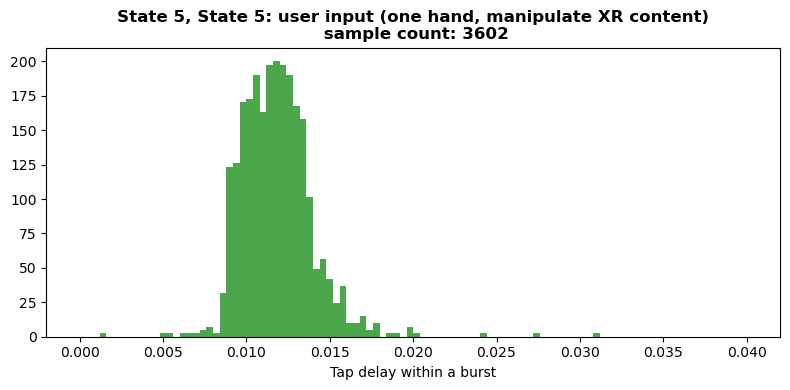

Tap 4 collects 0 samples


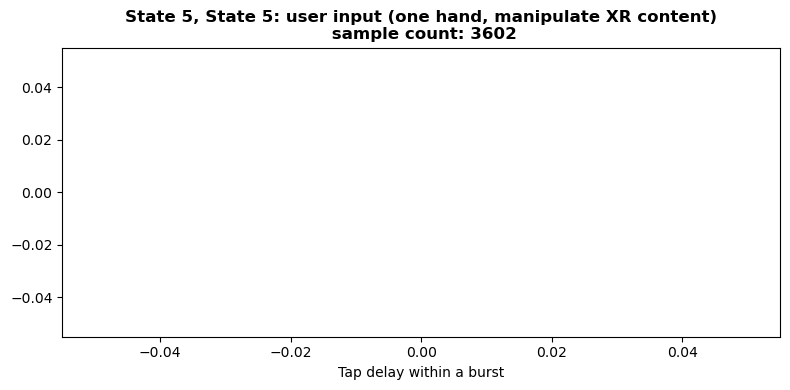

Tap 5 collects 0 samples


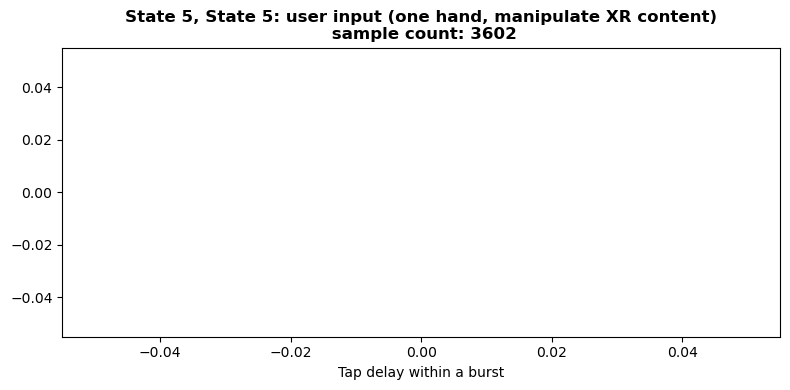

State 6, State 6: user input (two hands, manipulate XR content)
 sample count: 900
Tap 0 collects 900 samples


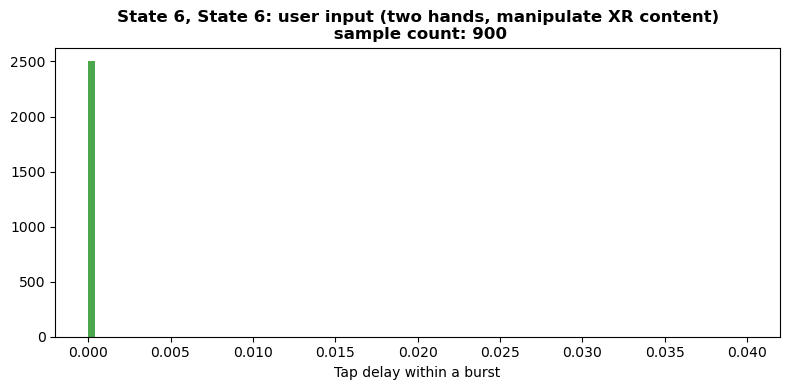

Tap 1 collects 900 samples


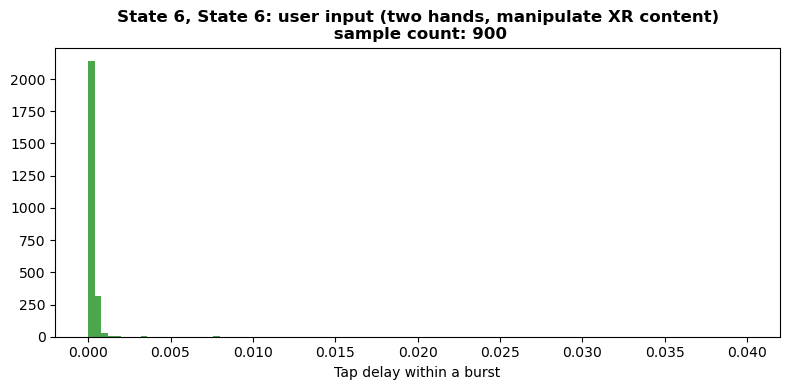

Tap 2 collects 297 samples


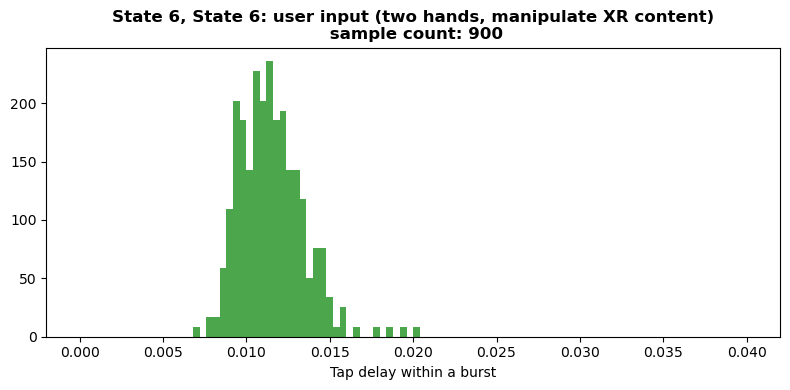

Tap 3 collects 259 samples


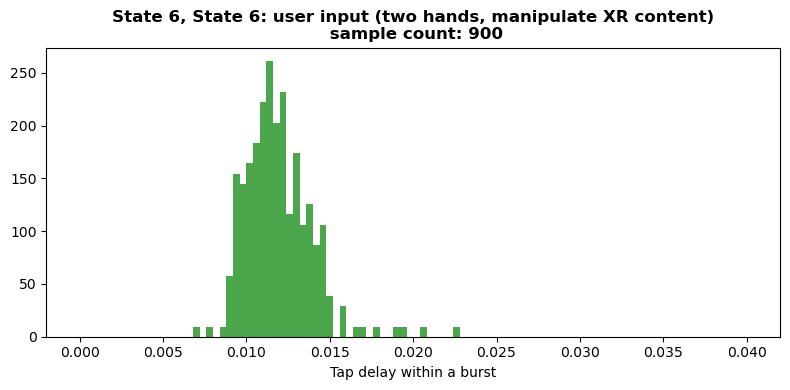

Tap 4 collects 0 samples


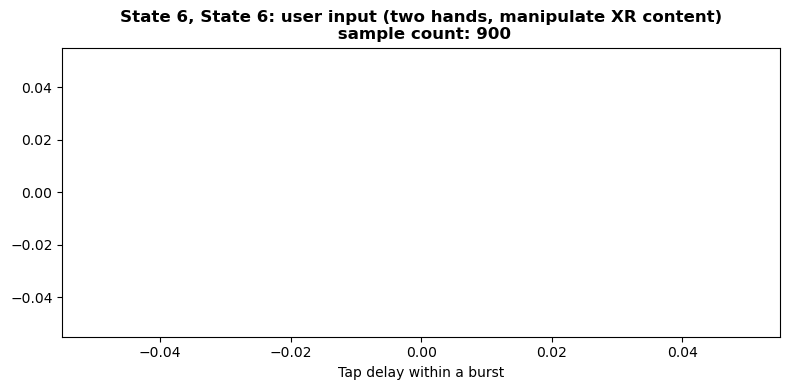

Tap 5 collects 0 samples


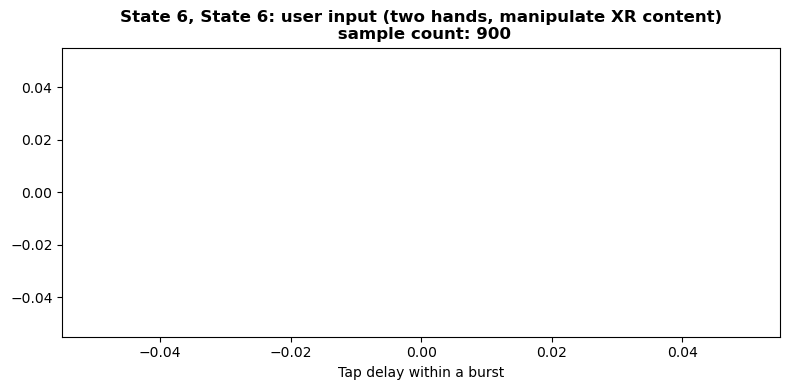

State 7, State 7: XR content change in the view (head rotation)
 sample count: 2703
Tap 0 collects 2703 samples


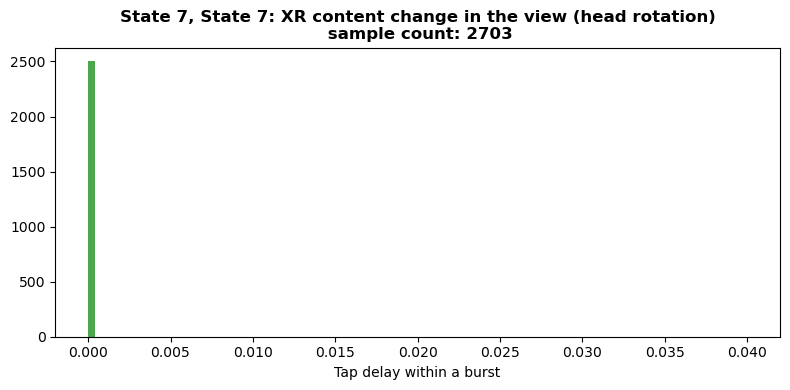

Tap 1 collects 2702 samples


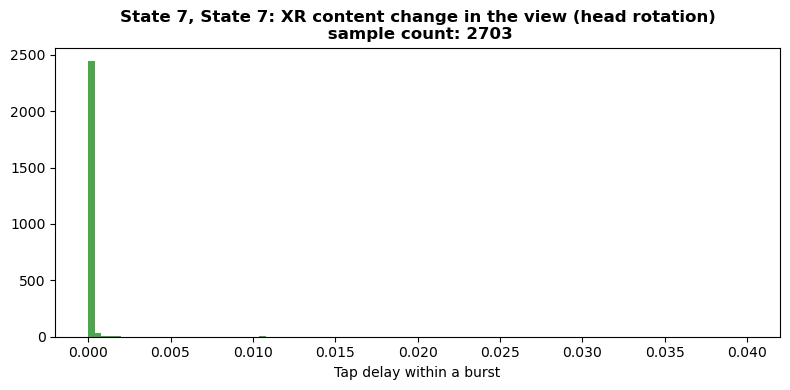

Tap 2 collects 974 samples


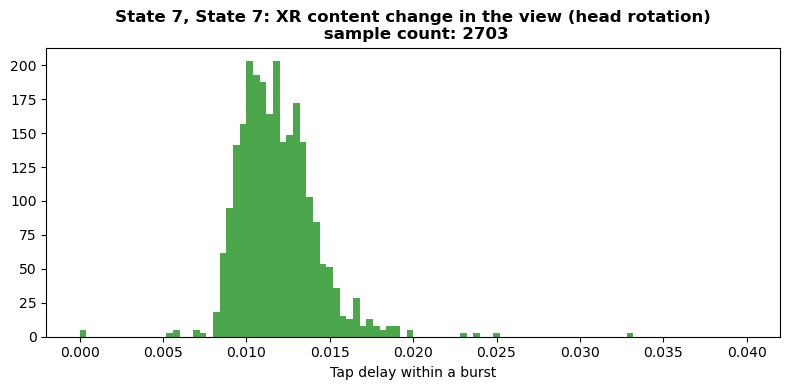

Tap 3 collects 883 samples


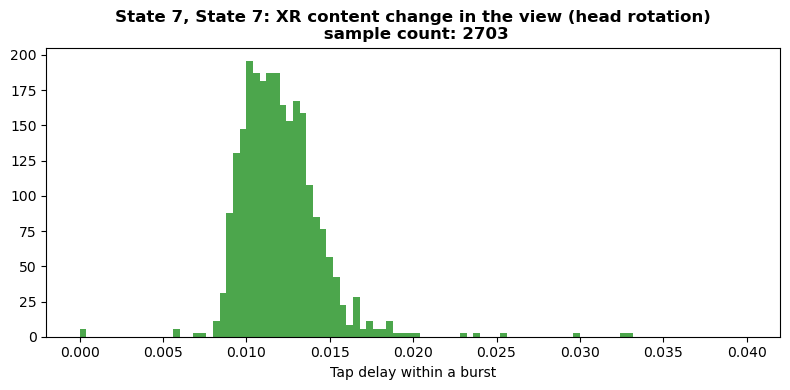

Tap 4 collects 0 samples


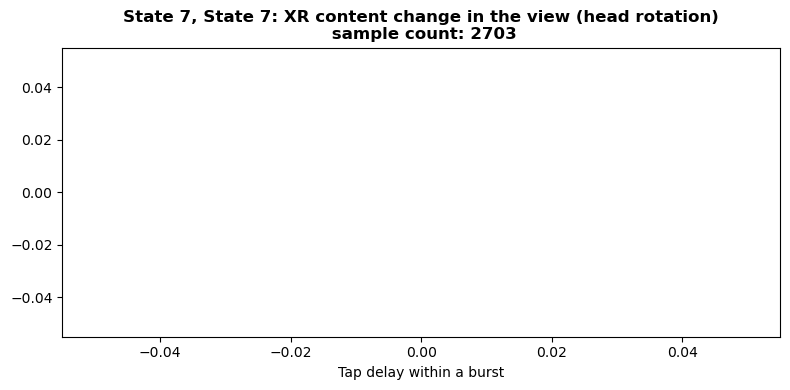

Tap 5 collects 0 samples


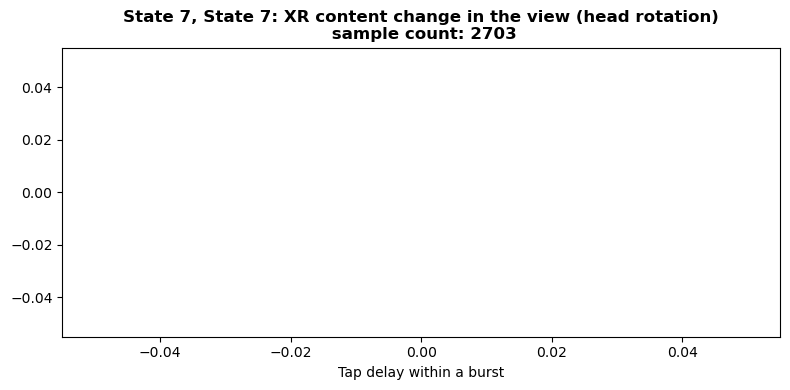

In [42]:
## Intra-burst frame interval distribution, i.e., for each tap frame how long it was sent from the start of 

# Tap 0, 1, 2, 3, 4, 5

# list_of_lst_burst_tap_delays[phase_state].append(i[burst_mat_cols["frame.time.lst"]])
# list_of_lst_burst_tap_sizes[phase_state].append(i[burst_mat_cols["frame.size.lst"]])

for phase_state in range(len(dict_op_state_def)):
    phase_state_term = dict_op_state_def[phase_state]

    title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
                                                                          len(list_of_lst_burst_tap_delays[phase_state]))
    print(title_print)
    
    max_tap_num = 6 
    tap_delay = [[] for i in range(max_tap_num)]
    
    for i in range(max_tap_num):
        tap_delay[i] = [j[i] for j in list_of_lst_burst_tap_delays[phase_state] if i < len(j)]
        print("Tap {} collects {} samples".format(i, len(tap_delay[i])))
        
        # Get the distribution plot
        
        fig, ax = plt.subplots(figsize=(8, 4))

        num_bins = 100#math.ceil(2500 / size_group_step)

        ## Plot the histogram of the i-th tags in segments



        # plot the histogram
        n, bins, patches = ax.hist(tap_delay[i], num_bins, 
                                    range=[0, 0.040],
                                    density = 1,
                                    color ='green',
                                    alpha = 0.7)

        # plot the cumulative histogram
        # n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
        #                            cumulative=True, label='Empirical')


        plt.xlabel("Tap delay within a burst")
        # plt.ylabel('Y-Axis')

    #     title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
    #                                                                           len(list_of_lst_burst_frame_count[phase_state]))


        plt.title(title_print,
                  fontweight = "bold")

        plt.show()
        
        
# Observation:
## Most bursts only have up to 4 taps or two pairs of (head, tail) although the maximum tap number was recorded as 6.
### In the model, we consider a burst contains up to 2 pairs of (head, tail)
### THe first pair with the same delay of 0 at the start of each burst
### The second pair with the similar delay (tap 3 may see slightly fewer samples than tap 2) whose distribution 
### has a distribution shown below.

<Figure size 1200x800 with 0 Axes>

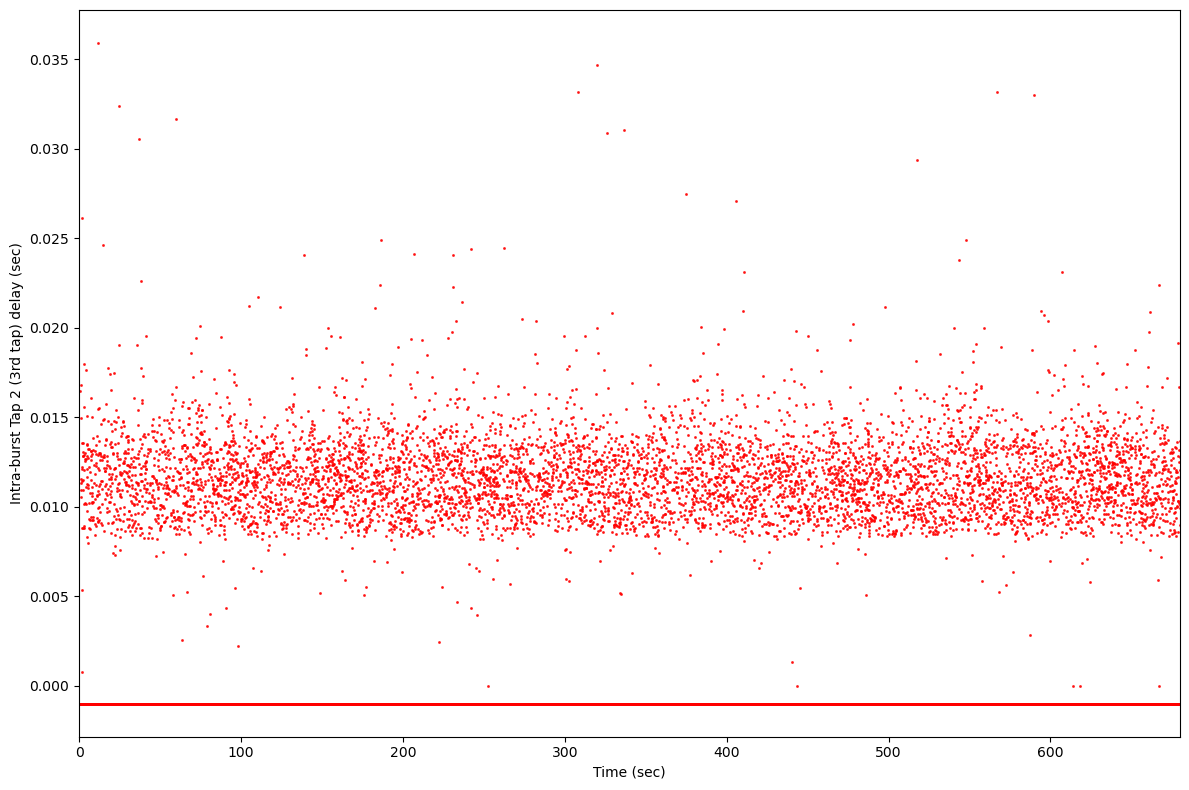

<Figure size 1200x800 with 0 Axes>

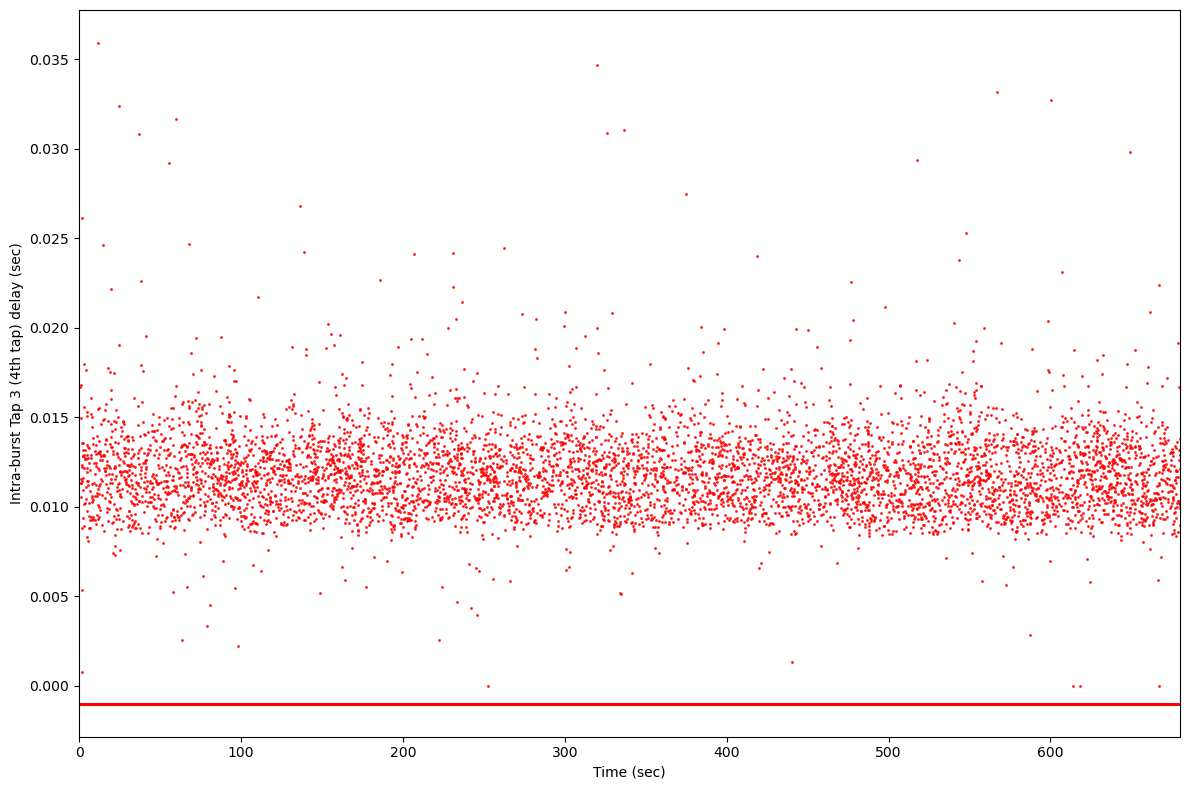

In [43]:
# See Tap2 and Tap3 delay with time

lst_burst_time = []
lst_burst_tap2_delay = []
lst_burst_tap3_delay = []

for i in ana_mat_burst_stat:
    i_burst_time = i[burst_mat_cols["burst.time"]]
    
    if len(i[burst_mat_cols["frame.time.lst"]]) > 2:
        i_burst_tap2_delay = i[burst_mat_cols["frame.time.lst"]][2] - i_burst_time
    else:
        i_burst_tap2_delay = -0.001
        
    if len(i[burst_mat_cols["frame.time.lst"]]) > 3:
        i_burst_tap3_delay = i[burst_mat_cols["frame.time.lst"]][3] - i_burst_time
    else:
        i_burst_tap3_delay = -0.001                               
    
    lst_burst_time.append(i_burst_time)
    lst_burst_tap2_delay.append(i_burst_tap2_delay)
    lst_burst_tap3_delay.append(i_burst_tap3_delay)
    
pic_title = ""#"Packet Transmissions" + "Data Type" + str_displayed_data_type
# print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 680#pcap_end_time
scatterplot(lst_burst_time, lst_burst_tap2_delay, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Intra-burst Tap 2 (3rd tap) delay (sec)", title=pic_title, figSave=True, fig_index="")

x_min_display = 0
x_max_display = 680#pcap_end_time
scatterplot(lst_burst_time, lst_burst_tap3_delay, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Intra-burst Tap 3 (4th tap) delay (sec)", title=pic_title, figSave=True, fig_index="")



In [44]:
list1 = [10, 20, 10, 30, 40, 40]
len(set(list1))

4

## Implementation

In [45]:
# Input
## Time (IBT): lst_ibt_msec (in msec), or lst_core_interval (in sec)
## Burst size (byte) specific to Application State (plot_index): list_of_lst_core_tail_sum_size[plot_index]

# Output
## sequence of (burst time, burst size)

import random
import time


# given an empirical CDF list, return the index of a random variable following the CDF
def rand_index_gen(lst_cdf):
    random.seed(int(str(time.time()).split('.')[1]))
    random.uniform(0, 1)
#     print("Input CDF curve: ", lst_cdf)
    tmp_rand = random.uniform(0, 1) # generate a random number between 0 and 1
#     print("ramdom number in [0, 1]: ", tmp_rand)
    
    # the input, lst_cdf, is supported to be sorted in the ascending order
    lst_less_eq = [i for i in lst_cdf if i <= tmp_rand]
#     print(lst_less_eq)
    
    idx_return = len(lst_less_eq)-1
    
#     print("random number {} picks index {}".format(tmp_rand, idx_return))
    
    return idx_return


# given the predefined state list and state transition probability, return the next state from the current state
def frame_size_gen_ds(in_size_cdf, in_size_range):
    # initiate the returned value
    out_size = 0
    # Get the index of the random size value
    tmp_size_idx = rand_index_gen(in_size_cdf)
    # Get the random size value
    out_size = in_size_range[tmp_size_idx]
    
    return out_size


# given the interval CDF, return the next frame time from the current frame time
def frame_next_time_gen_ds(in_time_curr, in_interval_cdf, in_interval_range):
    tmp_frame_interval_idx = rand_index_gen(in_interval_cdf)
#     print("in func: index: ", tmp_frame_interval_idx)
    tmp_frame_interval_gen = in_interval_range[tmp_frame_interval_idx]
#     print("in func: interval: ", tmp_frame_interval_gen)
    out_time_next = in_time_curr + tmp_frame_interval_gen
    out_time_next = np.round_(out_time_next, decimals=5)
#     print("in func: new frame time: ", out_time_next)
    
    return out_time_next

[250, 550, 900, 1200, 1250, 1400, 1550, 1750, 1800, 2300, 2400, 2450]


C:\Users\Yongkang.Liu\AppData\Local\Temp\1\ipykernel_24120\42424716.py:67: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  frame_time_next = frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)
C:\Users\Yongkang.Liu\AppData\Local\Temp\1\ipykernel_24120\42424716.py:80: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  frame_time_next = frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)


Sim data size:  9000


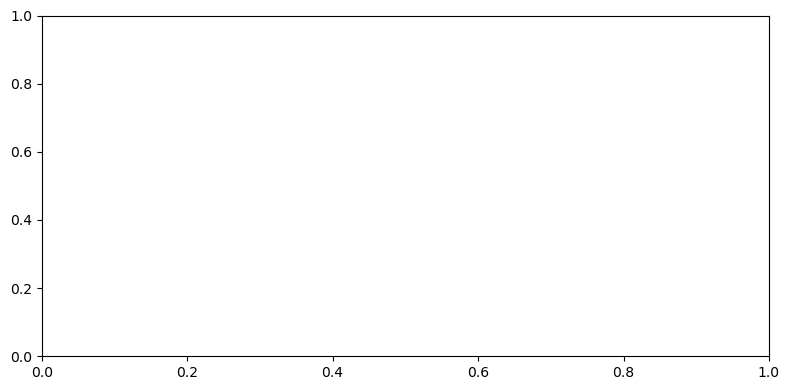

In [46]:
## Simulate the US traffic at a specific Application State

# pick the app state
sim_app_state = 6

# plot the cdf of the frame size at the selected state
fig, ax = plt.subplots(figsize=(8, 4))
num_bins = 100

lst_burst_size_selected = list_of_lst_unique_sizes_val[sim_app_state]
lst_burst_size_prob_selected = list_of_lst_unique_sizes_prob[sim_app_state]

print(lst_burst_size_selected)

# # plot the histogram
# n, bins, patches = ax.hist(lst_burst_size_selected, num_bins, 
# #                            range=[-0.005, 20000], 
# #                            range=[1400, 5000], 
#                             density = 1, histtype='step', 
# #                             color =color_vec[sim_app_state],
#                            cumulative=False,
#                             alpha = 0.7)
# plt.xlabel('Core and Tail size per burst (bytes)')
# plt.ylabel('CDF')
# plt.legend(loc='lower right') #(loc='upper right') 
# plt.show()

sim_mat = [] # store the simulated frame size and time instances per the distribution of the samples

# ## Obtain Burst size CDF lists
# lst_burst_size_vals = list_of_lst_unique_sizes_val[sim_app_state]
# # calculate the proportional values of samples
# lst_burst_size_probs = []
# cdf_tmp = 0
# for i in list_of_lst_unique_sizes_prob[sim_app_state]:
#     cdf_tmp += i
#     lst_burst_size_probs.append(cdf_tmp)
    
## Obtain Burst size CDF lists
lst_burst_size_selected = list_of_lst_burst_size[sim_app_state]
lst_burst_size_vals = np.sort(lst_burst_size_selected)
# calculate the proportional values of samples
lst_burst_size_probs = 1. * np.arange(len(lst_burst_size_selected)) / (len(lst_burst_size_selected) - 1)    



## Obtain IBT CDF lists
lst_ibt_selected = lst_seg_interval
lst_ibt_vals = np.sort(lst_ibt_selected)
lst_ibt_probs = 1. * np.arange(len(lst_ibt_selected)) / (len(lst_ibt_selected) - 1)

# Step 1. Determine the initial frame size
# Generate a random number, and pick the initial frame size according to the ECDF distribution

# print("Step 1: Initial frame size")
frame_size_curr_idx = rand_index_gen(lst_burst_size_probs)
frame_size_curr = lst_burst_size_vals[frame_size_curr_idx]
# print("Initial frame size is ", frame_size_curr)

frame_time_curr = 0

# Save the first generated frame info
sim_mat.append([frame_time_curr, frame_size_curr])

# Create the following frames
# Determine the interval length from the current frame to the next frame 
frame_time_next = frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)
# frame_time_next = frame_time_curr + 0.033 #frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)
# print("Current frame time: {}, Next frame time: {}".format(frame_time_curr, frame_time_next))

sim_time_stop = 300

while frame_time_curr <= sim_time_stop:
#     print("Generate frame at {} with size {}".format(frame_time_curr, frame_size_curr))
    sim_mat.append([frame_time_curr, frame_size_curr])
  
    frame_size_curr = lst_burst_size_vals[rand_index_gen(lst_burst_size_probs)]
    
    frame_time_curr = frame_time_next
    frame_time_next = frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)
#     frame_time_next = frame_time_curr + 0.033
    
    
print('Sim data size: ', len(sim_mat))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


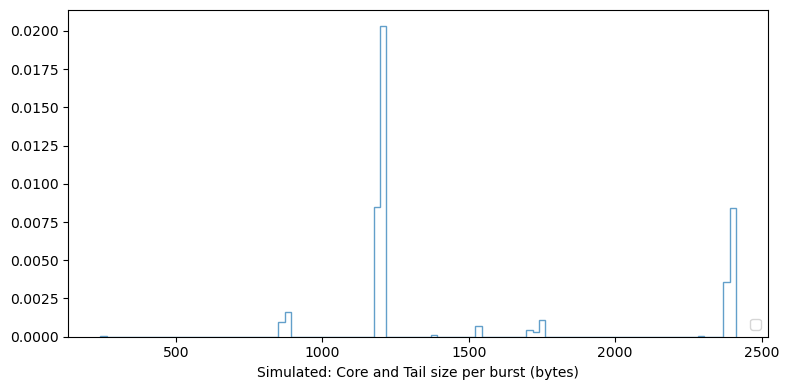

In [47]:
# Plot the burst size distribution in the simulated data set

lst_sim_size = [i[1] for i in sim_mat]

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 100

# plot the histogram
n, bins, patches = ax.hist(lst_sim_size, num_bins, 
#                            range=[-0.005, 20000], 
#                            range=[1400, 5000], 
                            density = 1, histtype='step', 
#                             color =color_vec[plot_index],
#                            label = ["", "$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
                           cumulative=False,
                            alpha = 0.7)


#plot the cumulative histogram
#     n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size[phase_state], num_bins, density=True, histtype='step',
#                                cumulative=True, label='Empirical')


plt.xlabel('Simulated: Core and Tail size per burst (bytes)')
# plt.ylabel('Y-Axis')

# title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
#                                                                       len(list_of_lst_core_tail_sum_size[phase_state]))

# plt.title(title_print,
#           fontweight = "bold")
plt.legend(loc='lower right') #(loc='upper right') 
plt.show()

In [48]:
# To compare the simulated traffic with the actual traffic measured in the link (named benchmark, or bench here)
# Obtain all bench traffic data segment from the measured data
list_of_lst_time_ranges_state = []
for i in lst_phase_record:
    if i[2] == sim_app_state:
        list_of_lst_time_ranges_state.append([i[0], i[1]])
        
print("State {} data in the time segments: {}".format(sim_app_state, list_of_lst_time_ranges_state))

State 6 data in the time segments: [[450, 480]]


In [49]:
# Get throughput of the selected data stream

segment_start_time_shift = 0

ana_mat_bench = []

for i in range(len(list_of_lst_time_ranges_state)):
    
    i_start_t = list_of_lst_time_ranges_state[i][0]
    i_end_t = list_of_lst_time_ranges_state[i][1]
    print("collecting in State {}, Segment {}: from {} to {}".format(sim_app_state, i, i_start_t, i_end_t))
    
    ana_mat_bench_i = [j for j in ana_mat_burst \
                     if j[cols["data.type.name"]] in ["head", "tail"] \
                    and j[cols["frame.time_epoch"]] > i_start_t \
                     and j[cols["frame.time_epoch"]] < i_end_t ]
    
    if i > 0:
        # for a new segment of traffic, their timestamp will be shifted
        # The new start time will reference the last timestamp in the previous segement
        # a 33.3 msec interval is added    
        segment_start_time_shift = ana_mat_bench[-1][0] + 0.0333 
        
    segment_start_time_origin = ana_mat_bench_i[0][cols["frame.time_epoch"]]
    for j in ana_mat_bench_i:
        tmp_j = [j[cols["frame.time_epoch"]]-segment_start_time_origin+segment_start_time_shift, j[cols["data.len"]]]
        ana_mat_bench.append(tmp_j)
        
    print("Collected frame counts: ", len(ana_mat_bench))

collecting in State 6, Segment 0: from 450 to 480
Collected frame counts:  2356


[380.84, 345.576, 337.976, 362.4, 353.168, 364.648, 355.832, 327.464, 348.312, 336.184]
Figure saved as  Packet TransmissionsData Type_80:00


<Figure size 1200x800 with 0 Axes>

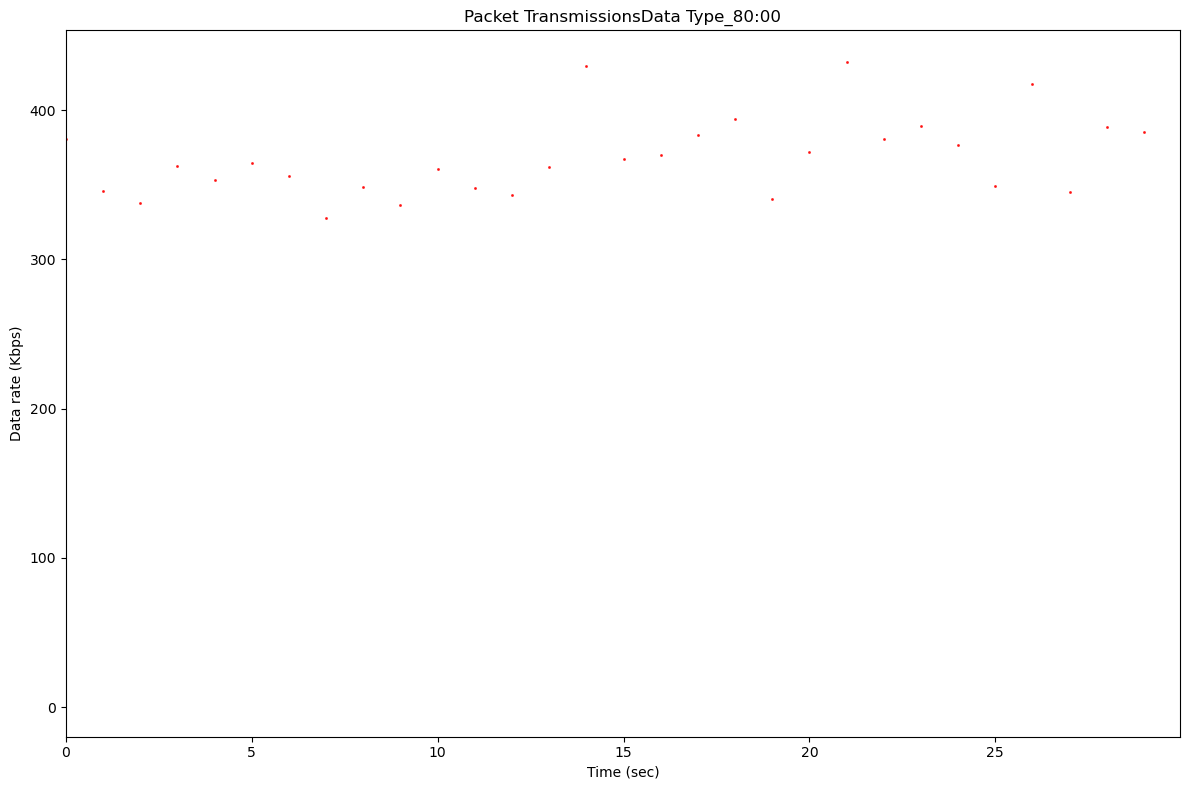

In [50]:
# Throughput of the selected data stream

# Pick only 
# ana_mat_bench = [i for i in ana_mat_burst \
#                  if i[cols["data.type.name"]] in ["core", "tail"] \
#                     and i[cols["frame.time_epoch"]] > state_start_time \
#                      and i[cols["frame.time_epoch"]] < state_end_time ]

start_time = ana_mat_bench[0][0]
ana_mat_bench_t0 = []
for i in ana_mat_bench:
    tmp_i = i.copy()
    tmp_i[0] = i[0] - start_time
    ana_mat_bench_t0.append(tmp_i)

import math

step = 1 #sec

start_time = 0
end_time = math.ceil(ana_mat_bench_t0[-1][0]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat_bench_t0:
    len_tmp = int(i[1])
    time_tmp = i[0]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

print(lst_rate_kbps[:10])

lst_rate_kbps_bench = []
for i in lst_rate_kbps:
    lst_rate_kbps_bench.append(i)


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = ana_mat_bench_t0[-1][0]#state_end_time - state_start_time#pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")


[391.072, 418.264, 412.96, 421.568, 395.08, 364.192, 341.296, 352.36, 340.152, 368.84]
Figure saved as  Packet TransmissionsData Type_80:00


<Figure size 1200x800 with 0 Axes>

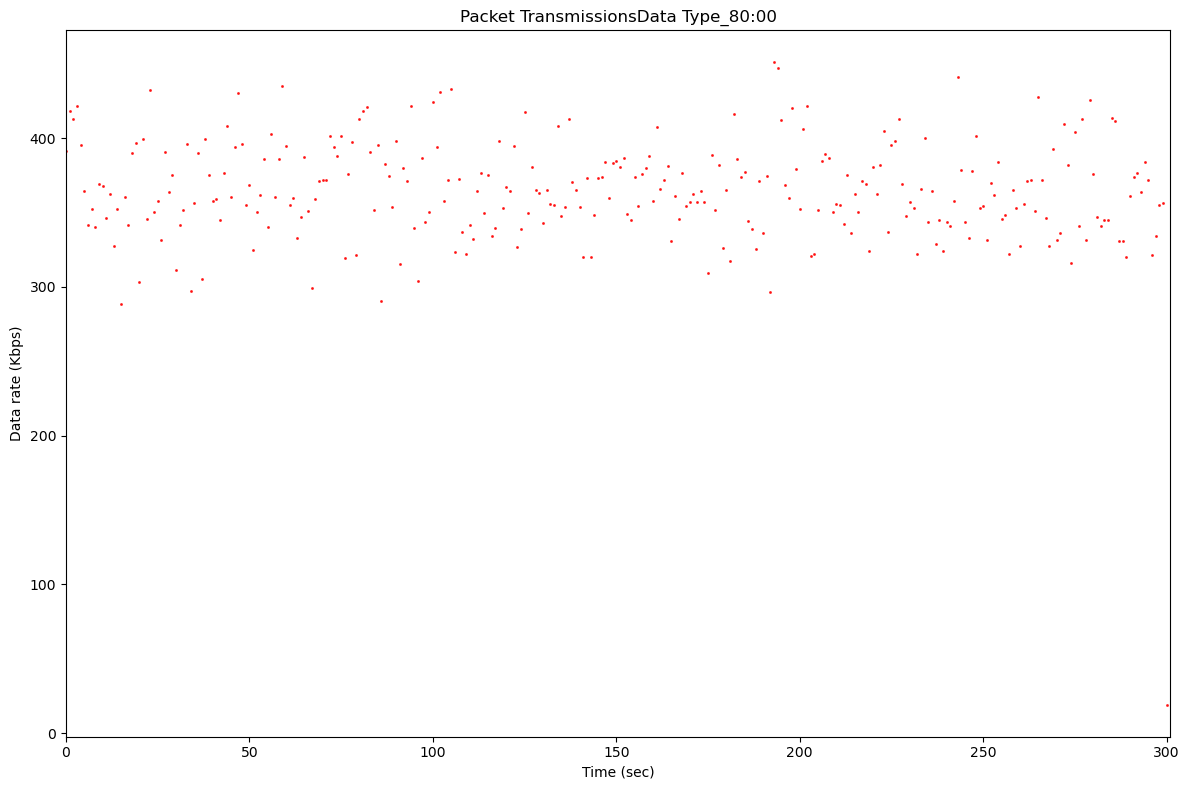

In [51]:
# Throughput of the simulated data stream

# # Pick only 
# ana_mat_bench = [i for i in ana_mat_burst \
#                  if i[cols["data.type.name"]] in ["core", "tail"] \
#                     and i[cols["frame.time_epoch"]] > 450 \
#                      and i[cols["frame.time_epoch"]] < 480 ]

# start_time = ana_mat_bench[0][cols["frame.time_epoch"]]
# ana_mat_bench_t0 = []
# for i in ana_mat_bench:
#     tmp_i = i.copy()
#     tmp_i[cols["frame.time_epoch"]] = i[cols["frame.time_epoch"]] - start_time
#     ana_mat_bench_t0.append(tmp_i)

import math

step = 1 #sec

start_time = 0
end_time = math.ceil(sim_mat[-1][0]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in sim_mat:
    len_tmp = i[1]#int(i[cols["data.len"]])
    time_tmp = i[0]#i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

lst_rate_kbps_sim = []
for i in lst_rate_kbps:
    lst_rate_kbps_sim.append(i)

print(lst_rate_kbps[:10])


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = end_time - start_time #40#pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

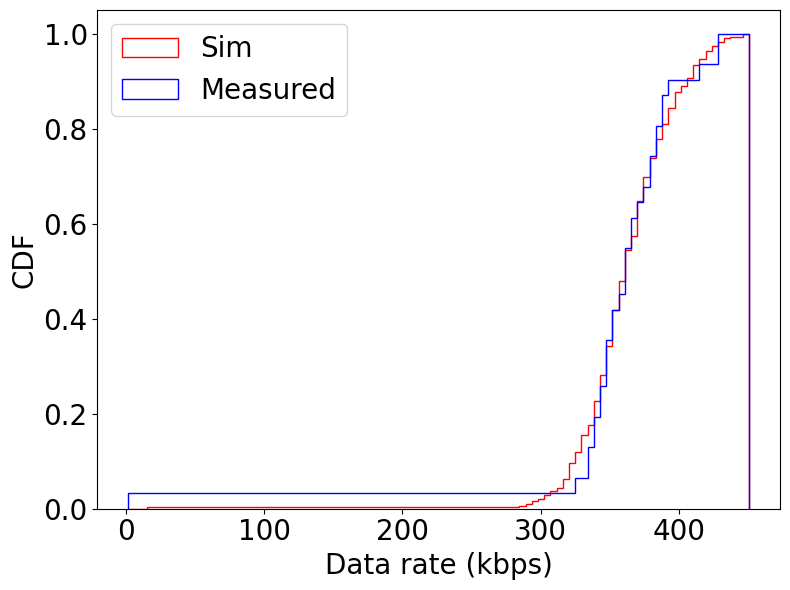

In [52]:
list_of_lst_rate_kbps = [lst_rate_kbps_bench, lst_rate_kbps_sim]
color_vec = ["b", "r"]

fig, ax = plt.subplots(figsize=(8, 6))

num_bins = 100

# plot the histogram
n, bins, patches = ax.hist(list_of_lst_rate_kbps, num_bins, 
#                            range=[-0.005, 20000], 
#                            range=[1400, 5000], 
                            density = 1, histtype='step', 
                            color =color_vec,
                           label = ["Measured", "Sim"],
#                            label = ["", "$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
                           cumulative=True,
                            alpha = 1)


#plot the cumulative histogram
#     n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size[phase_state], num_bins, density=True, histtype='step',
#                                cumulative=True, label='Empirical')


# plt.xlabel('Data rate (kbps)')
# # plt.ylabel('Y-Axis')

# # title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
# #                                                                       len(list_of_lst_core_tail_sum_size[phase_state]))

# # plt.title(title_print,
# #           fontweight = "bold")
# plt.legend(loc='lower right') #(loc='upper right') 
# plt.show()



ax.set_xlabel("Data rate (kbps)", fontsize = 20)
ax.set_ylabel("CDF", color='k', fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# ax1.set_ylim([0, 0.06])
# plt.xlabel('Data rate (kbps)')
# plt.ylabel('Y-Axis')


plt.legend(loc='upper left', fontsize=20) #(loc='upper right') 
plt.show()

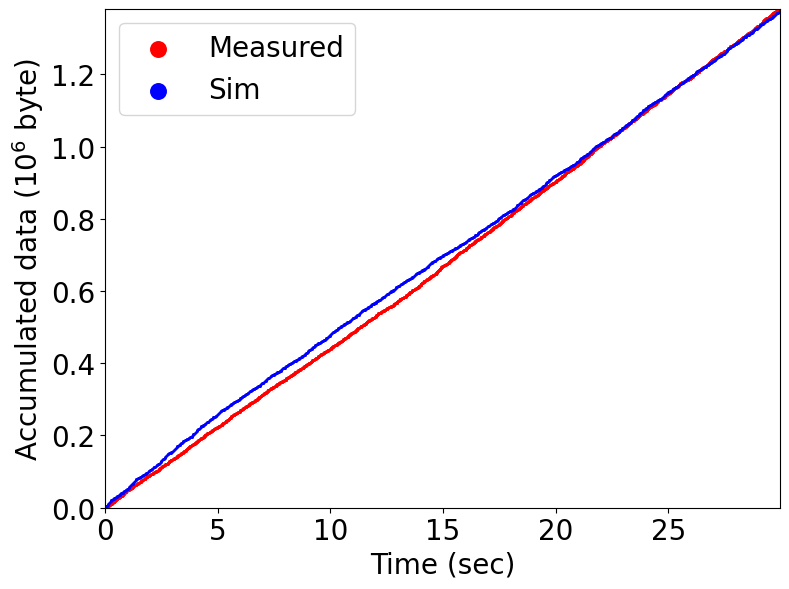

In [53]:
lst_sim_time_to_sec = [i[0] for i in sim_mat]
size_accum = 0
lst_sim_size_accum = []
for i in sim_mat:
    size_accum += i[1]
    lst_sim_size_accum.append(size_accum)
    

lst_bench_time = [i[0] for i in ana_mat_bench_t0]
size_accum = 0
lst_bench_size_accum = []
for i in ana_mat_bench_t0:
    size_accum += int(i[1])
    lst_bench_size_accum.append(size_accum)

# def scatterplot(x_data, y_data, x_xlim=[0, 0], x_label="", y_label="", \
#                 title="", color = "r", yscale_log=False, figSave=False, fig_index=""):

# Create the plot object
_, ax = plt.subplots(figsize=(8, 6))

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
ax.scatter(lst_bench_time, [i/1000000 for i in lst_bench_size_accum], s = 5, color = 'r', label = 'Measured', alpha = 1, marker='.')


ax.scatter(lst_sim_time_to_sec, [i/1000000 for i in lst_sim_size_accum], s = 5, color = 'b', label = 'Sim', alpha = 1, marker='.')


# if yscale_log == True:
#     ax.set_yscale('log')

# # Label the axes and provide a title
# ax.set_title(title)

# if x_xlim[0]<x_xlim[1]:
# ax.set_xlim(0, lst_bench_time[-1])#state_end_time-state_start_time)
# ax.legend()
# #     ax.set_xticks(np.arange(x_xlim[0], x_xlim[1], round((x_xlim[1]-x_xlim[0])/10)+1))
# #     ax.set_xticks(np.arange(0, 690, step=30))

# if figSave:
#     plt.rcParams["figure.figsize"] = [12.00, 8.0]
#     plt.rcParams["figure.autolayout"] = True
#     plt.savefig('test_'+fig_index+'.png', bbox_inches='tight')
#         plt.savefig('test_'+fig_index+'.svg', format='svg', dpi=1200)



# if yscale_log == True:
#     ax.set_yscale('log')

# # Label the axes and provide a title
# ax.set_title(title)
ax.set_xlabel("Time (sec)", fontsize = 20)
ax.set_ylabel("Accumulated data ($10^6$ byte)", fontsize = 20)

ax.set_xlim(0, lst_bench_time[-1])#state_end_time-state_start_time)
ax.set_ylim(0, lst_bench_size_accum[-1]/1000000)#state_end_time-state_start_time)


ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

plt.legend(loc='upper left', fontsize=20, markerscale=10) #(loc='upper right') 
# ax.legend(fontsize = 20, bbox_to_anchor=(0.5, 0.1), loc='upper left', ncol=3, markerscale=10)

Figure saved as  Application Data Rate


<Figure size 1200x800 with 0 Axes>

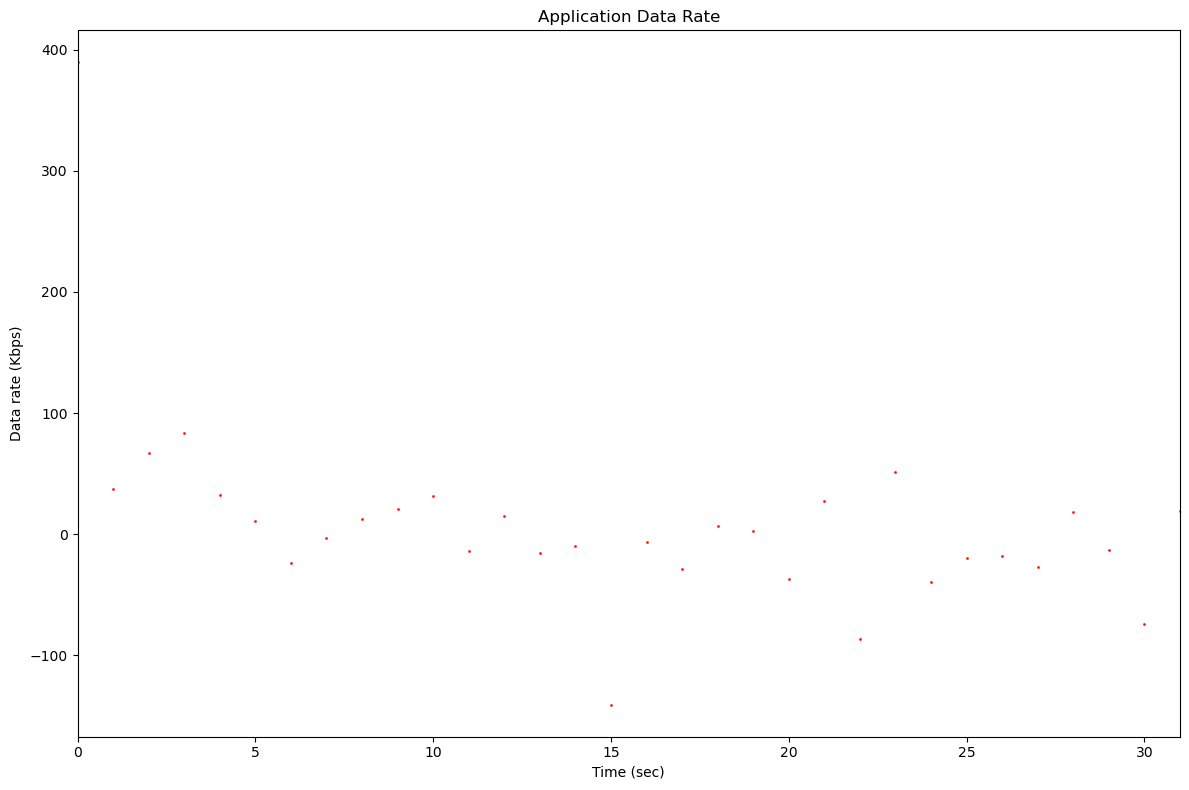

In [54]:
# Traffic load difference between the simulated and measured traffic
import math

step = 1 # sec

start_time = 0
end_time = math.ceil(lst_bench_time[-1])+1#220 # sim_mat_silent[-1][0] / 1000
arr_time = np.arange(start_time, end_time+1, step = step)
arr_time[1]


# Simulated rate   
lst_byte = [0 for i in range(len(arr_time))]
for i in sim_mat:   
    if i[0] <= end_time:
        idx = math.ceil(i[0] / step)
        lst_byte[idx-1] += i[1]

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

lst_rate_kbps_sim = [i for i in lst_rate_kbps]


# Measured rate
lst_byte = [0 for i in range(len(arr_time))]
for i in ana_mat_bench_t0:
    len_tmp = int(i[1])
    time_tmp = i[0]
    
    if time_tmp <= end_time:    
        idx = math.ceil(time_tmp / step)
        lst_byte[idx] += len_tmp

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

lst_rate_kbps_meas = [i for i in lst_rate_kbps]


lst_rate_kbps_diff = [lst_rate_kbps_sim[i]-lst_rate_kbps_meas[i] for i in range(len(arr_time))]


    
pic_title = "Application Data Rate"
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = end_time#pcap_end_time
scatterplot(arr_time, lst_rate_kbps_diff, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")




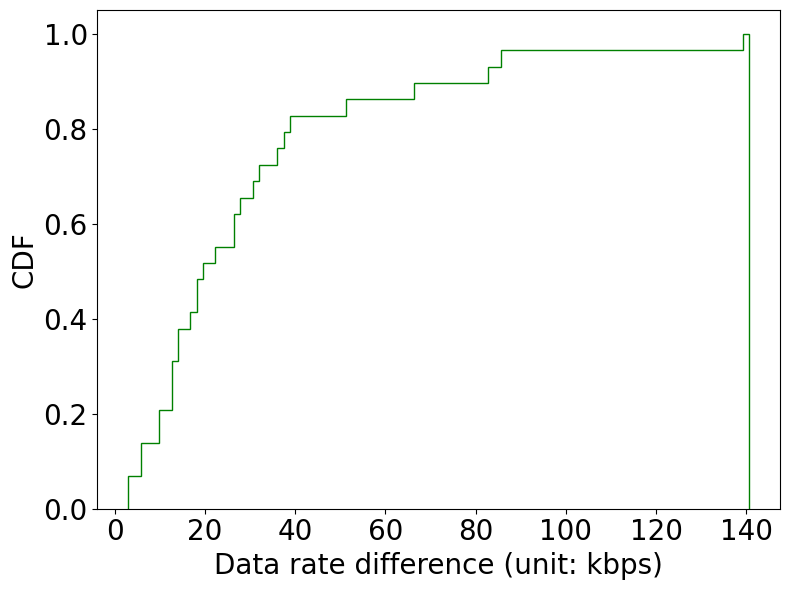

Outliers:  1


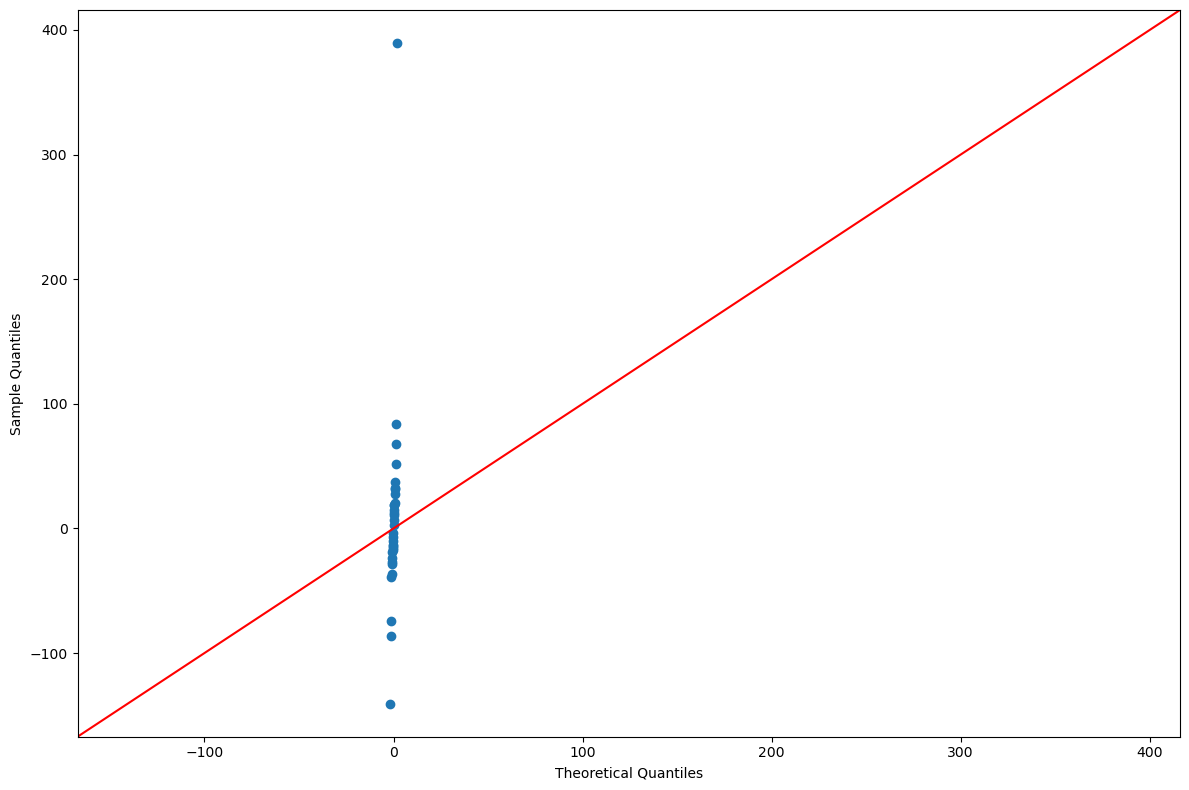

In [55]:
# We further compare the difference between the simulated and measured traffic rate

fig, ax = plt.subplots(figsize=(8, 6))

num_bins = 100

lst_rate_kbps_diff_abs = [np.abs(i) for i in lst_rate_kbps_diff[1:-2]]

 
# plot the histogram
n, bins, patches = ax.hist(lst_rate_kbps_diff_abs, num_bins,
#                            range=[.006, .012],
                            density = 1,
                            color ='green',histtype='step',
                            cumulative=True,
                            alpha = 1)

# plot the cumulative histogram
# n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')
  

plt.xlabel('Data rate difference (unit: kbps)', fontsize=20)
plt.ylabel('CDF', fontsize=20)
# plt.ylabel('Y-Axis')
 
# plt.title('Histogram of data rate difference between the measured and simulated traffics\n',
#           fontweight = "bold")
# ax.set_xlim(0, 100)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

plt.show()

lst_rate_kbps_diff_outliers = [i for i in lst_rate_kbps_diff if i < -200 or i > 200]
print("Outliers: ", len(lst_rate_kbps_diff_outliers))



import statsmodels.api as sm

lst_frame_interval_select_qqplot = lst_rate_kbps_diff.copy()

lst_frame_interval_select_qqplot.sort()

data = np.array(lst_frame_interval_select_qqplot)

fig = sm.qqplot(data, line='45')
plt.show()

#The Q-Q plot indicates the inter-burst time is not normally distributed.

# End of Analysis Report